In [1]:
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch
from lib.ds.bird_combiner import combine_birds
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [5]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [6]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [65]:
combined_ds = combine_birds(NumpyDataset(data_raw, labels), sequence_length=250, random_seed=42)
print(f'{combined_ds.data.shape = }')
print(f'{combined_ds.labels.shape = }')

Creating random sequence: 100%|██████████████████████████████████████████████| 120000/120000 [01:25<00:00, 1409.52it/s]


combined_ds.data.shape = (480, 250, 548)
combined_ds.labels.shape = (480, 250)


In [13]:
data_train_raw, labels_train, data_test_raw, labels_test = split(data_raw, labels, seed=69421)

print(f'{data_train_raw.shape = }')
print(f'{labels_train.shape   = }')
print(f'{data_test_raw.shape  = }')
print(f'{labels_test.shape    = }')

data_train, data_test = data_train_raw, data_test_raw

data_train_raw.shape = (960, 100, 548)
labels_train.shape   = (960, 100)
data_test_raw.shape  = (240, 100, 548)
labels_test.shape    = (240, 100)


In [14]:
data_train, data_test = data_train_raw, data_test_raw

In [28]:
# data_train, data_test = remove_correlated_columns(data_train, data_test)
# 
# print(f'{data_train.shape}')
# print(f'{data_test.shape}')

In [5]:
# N_COMPONENTS = 50
# 
# data_train_raw_shape = data_train_raw.shape
# data_test_raw_shape = data_test_raw.shape
# 
# data_train_flat = data_train_raw.reshape(-1, data_train_raw.shape[-1])
# data_test_flat = data_test_raw.reshape(-1, data_test_raw.shape[-1])
# 
# pca = sklearn.decomposition.PCA(n_components=N_COMPONENTS)
# pca.fit(data_train_flat)
# 
# data_train_downprojected = pca.transform(data_train_flat)
# data_test_downprojected = pca.transform(data_test_flat)
# 
# data_train = np.reshape(data_train_downprojected, (data_train_raw_shape[0], data_train_raw_shape[1], N_COMPONENTS))
# data_test = np.reshape(data_test_downprojected, (data_test_raw_shape[0], data_test_raw_shape[1], N_COMPONENTS))
# 
# print(f'{data_train.shape}')
# print(f'{data_test.shape}')

In [27]:
# set_random_seed(42)
# subset_indices = [
#     bird * data_train.shape[0] // 6 + sample_nr
#     for bird in range(6)
#     for sample_nr in range(10)
# ]
# # data_train_subset = data_train[subset_indices, :, :]
# # labels_train_subset = labels_train[subset_indices, :]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
# print(data_train_subset.shape)
# print(labels_train_subset.shape)

# Hyper Parameters

In [56]:
hyper_parameters = AttentionClassifierHyperParameters(
    attention_window_size=250,
    
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    self_attention=True,
    d_model=60,
    num_heads=12,
    stack_size=1,
    attention_dropout=0.2,
    
    in_linear_hidden_out_features=[48, 32],
    out_linear_hidden_out_features=[16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.2,
)

In [51]:
def create_training_hyper_parameters(epoch_multiplier: float, lr_multiplier: float):
    return TrainingHyperParameters(
        batch_size=32,

        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(100 * epoch_multiplier),
        
        lr=1e-2 * lr_multiplier,
        lr_scheduler_milestones=[int(m * epoch_multiplier) for m in [10, 20, 40, 60, 80]],
        lr_scheduler_gamma=0.5,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones,
            gamma=gamma
        )
    )

# Training

## Cross Validation

Creating 8 folds
Executing CV for fold 0
Training fold 0
Training AttentionClassifier with 45635 parameters
train label counts = [74913, 5132, 7428, 7196, 2067, 4397, 3867]
loss weights = [1.0, 14.6, 10.09, 10.41, 36.24, 17.04, 19.37]
eval label counts = [10445, 701, 1526, 1002, 257, 714, 355]
eval loss weights = [1.0, 14.9, 6.84, 10.42, 40.64, 14.63, 29.42]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000261, num_samples = 105000, num_correct =  5587, acc = 0.053210, bacc = 0.136234
Evaluation Epoch   1/200: avg_loss = 0.000260, num_samples = 15000, num_correct =   732, acc = 0.048800, bacc = 0.141626
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  9330, acc = 0.088857, bacc = 0.142507
Evaluation Epoch   2/200: avg_loss = 0.000257, num_samples = 15000, num_correct =  2696, acc = 0.179733, bacc = 0.145841
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000259, num_samples = 105000, num_correct = 35553, acc = 0.338600, bacc = 0.169878
E

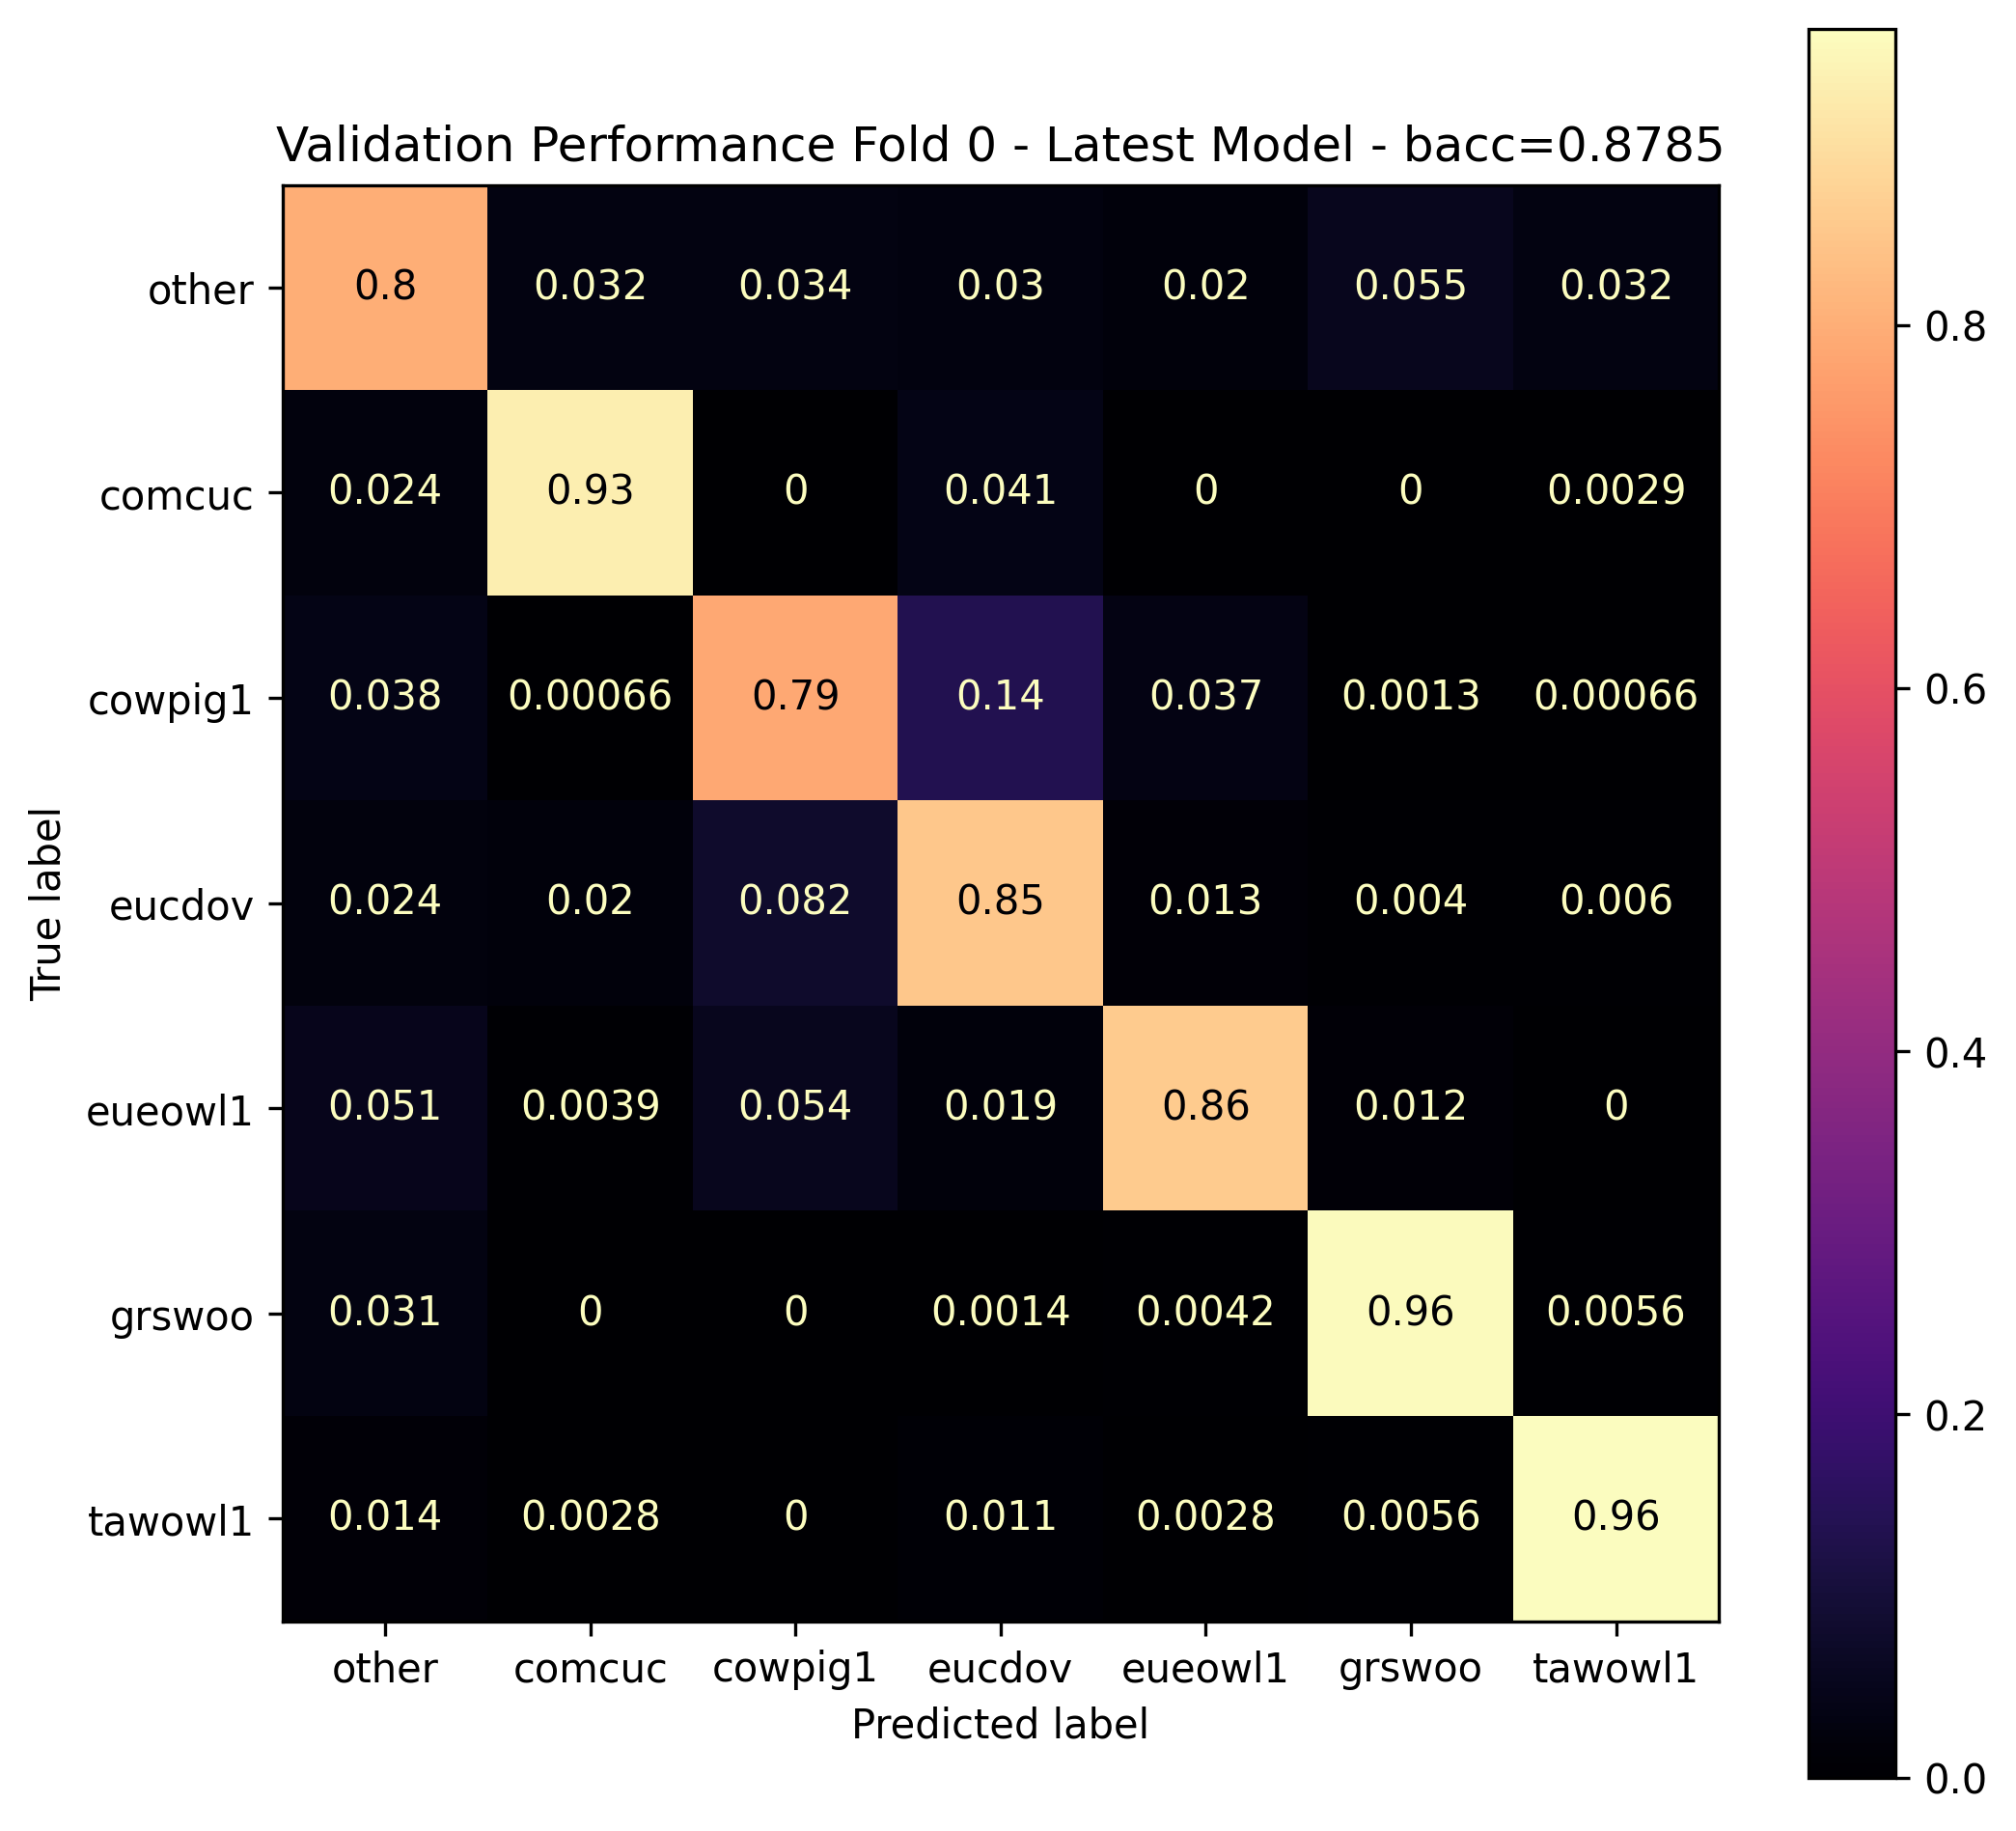

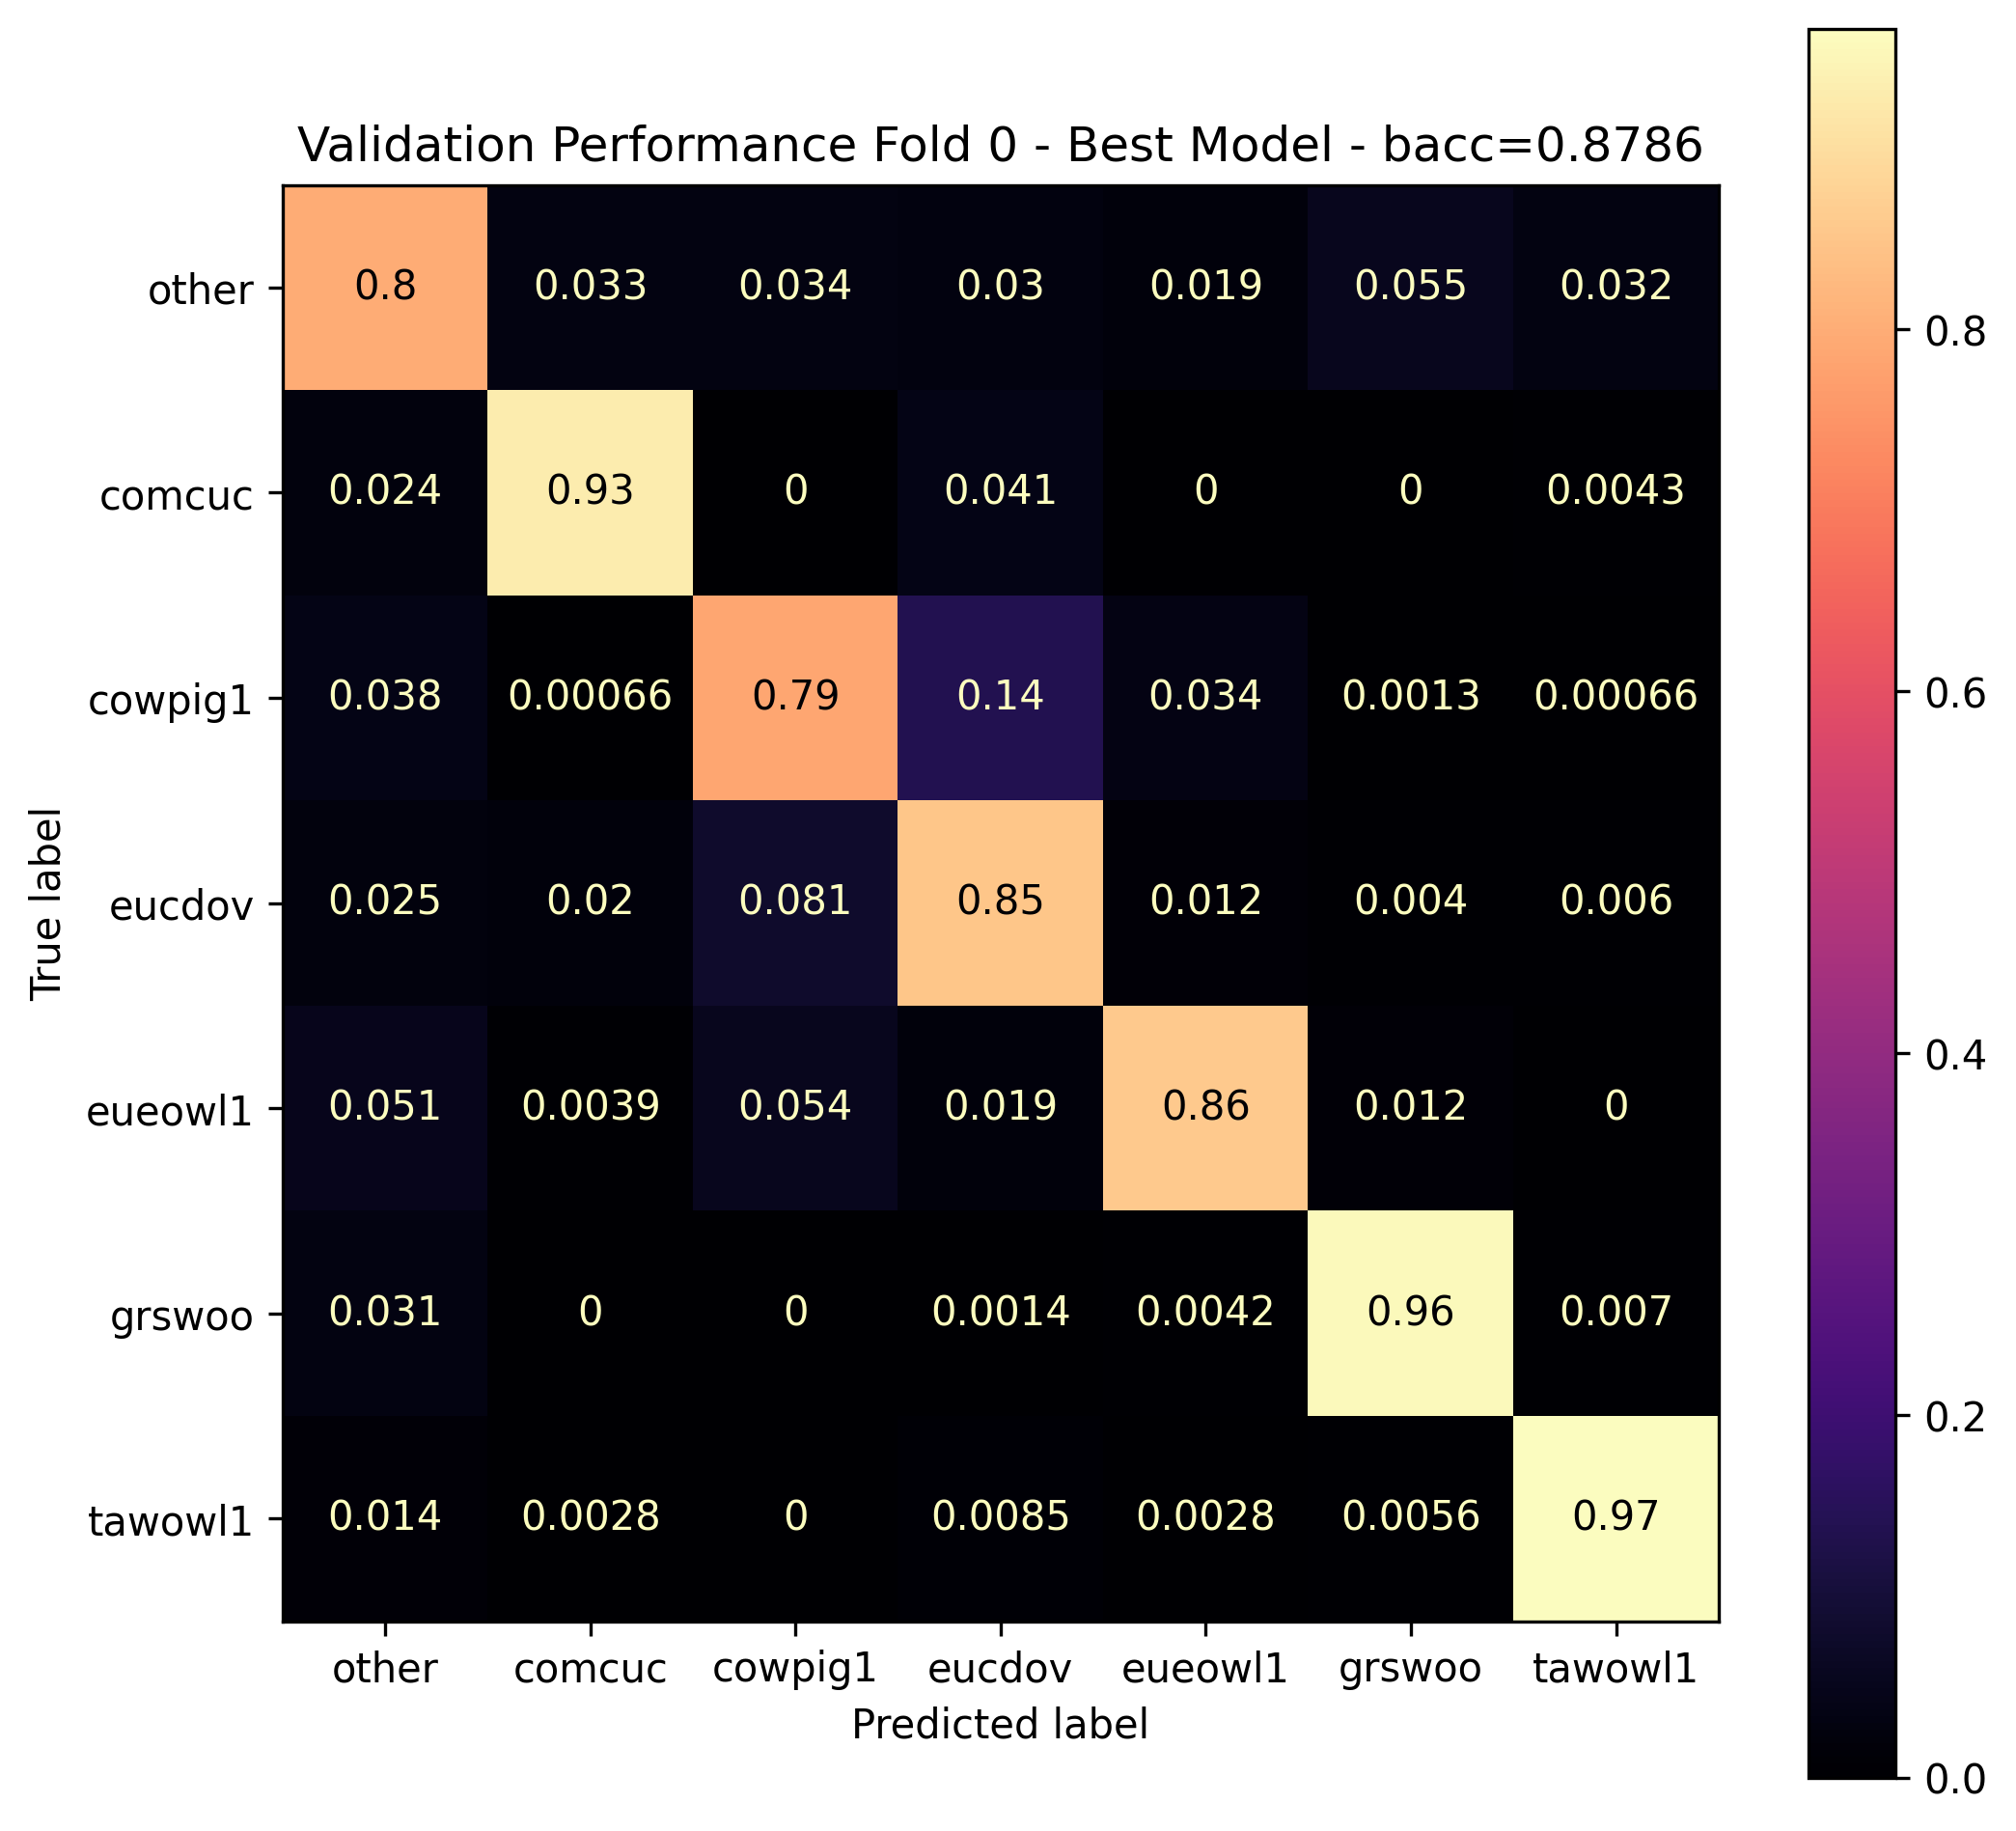

Executing CV for fold 1
Training fold 1
Training AttentionClassifier with 45635 parameters
train label counts = [74672, 5102, 7959, 7134, 2050, 4358, 3725]
loss weights = [1.0, 14.64, 9.38, 10.47, 36.43, 17.13, 20.05]
eval label counts = [10686, 731, 995, 1064, 274, 753, 497]
eval loss weights = [1.0, 14.62, 10.74, 10.04, 39.0, 14.19, 21.5]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000261, num_samples = 105000, num_correct =  4916, acc = 0.046819, bacc = 0.142311
Evaluation Epoch   1/200: avg_loss = 0.000258, num_samples = 15000, num_correct =   564, acc = 0.037600, bacc = 0.136502
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000259, num_samples = 105000, num_correct =  6004, acc = 0.057181, bacc = 0.159788
Evaluation Epoch   2/200: avg_loss = 0.000255, num_samples = 15000, num_correct =  1463, acc = 0.097533, bacc = 0.190222
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000255, num_samples = 105000, num_correct =  7049, acc = 0.067133, bacc = 0.182758
Evaluation Epoch   

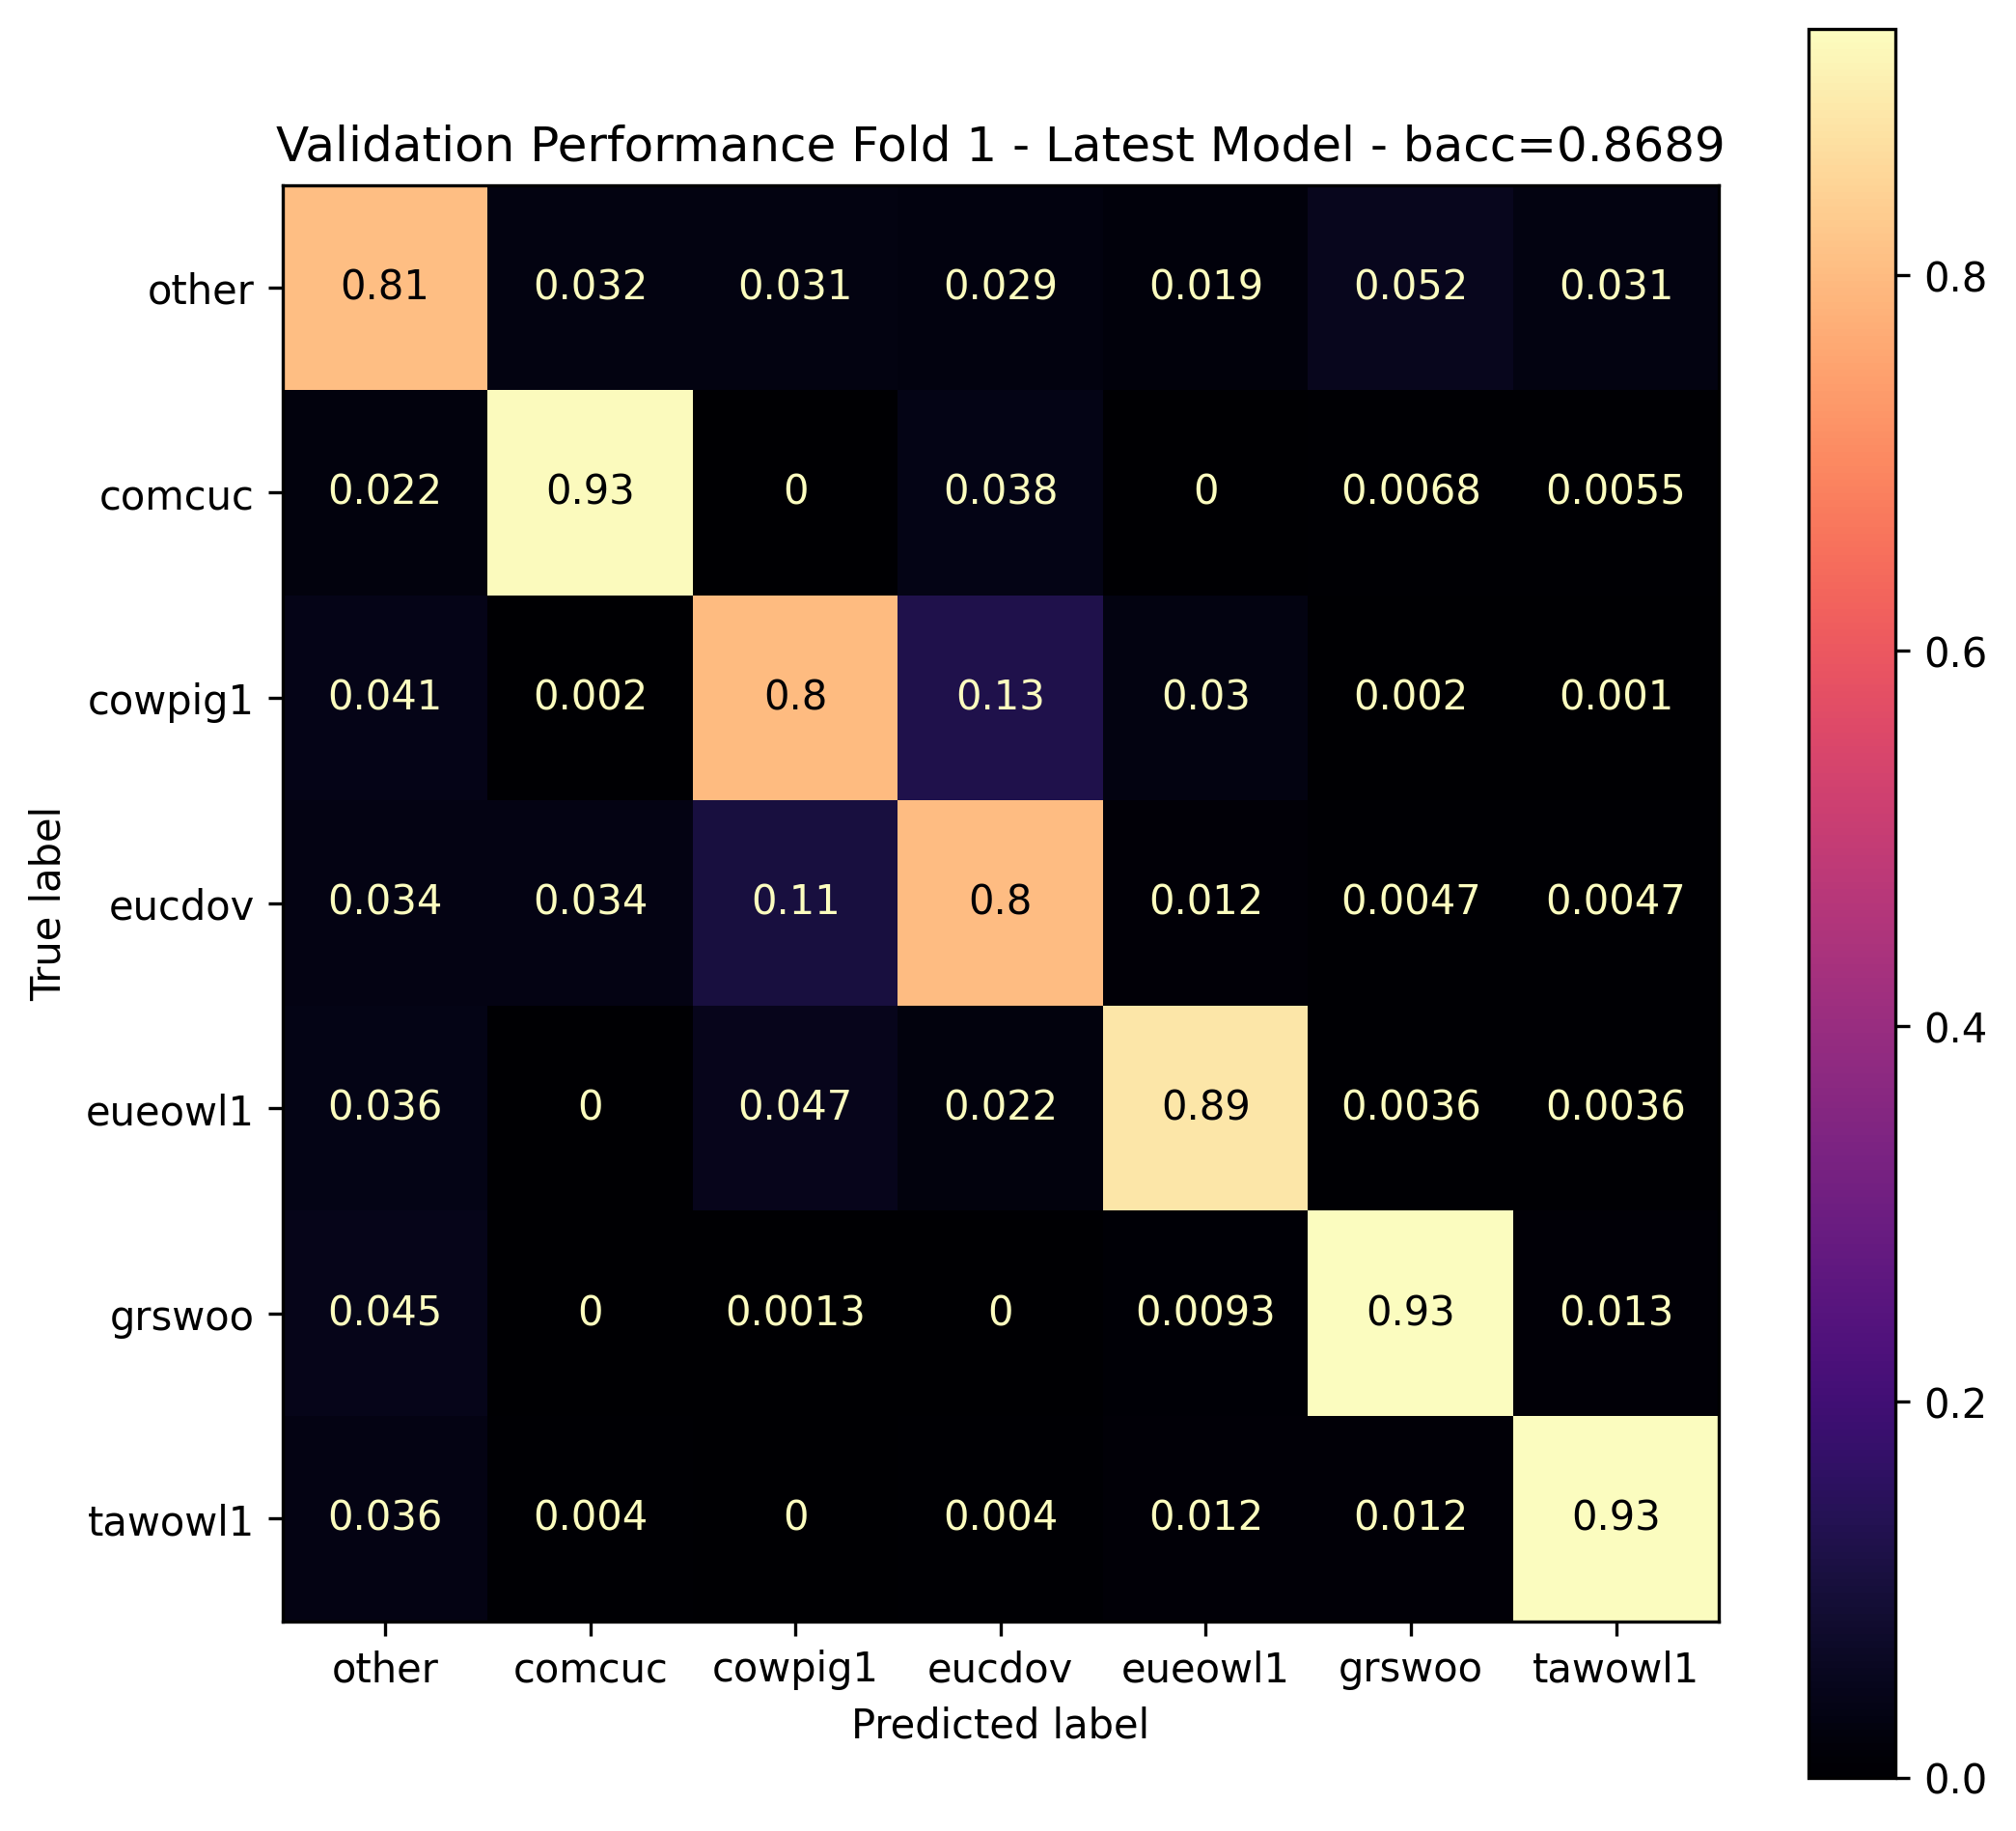

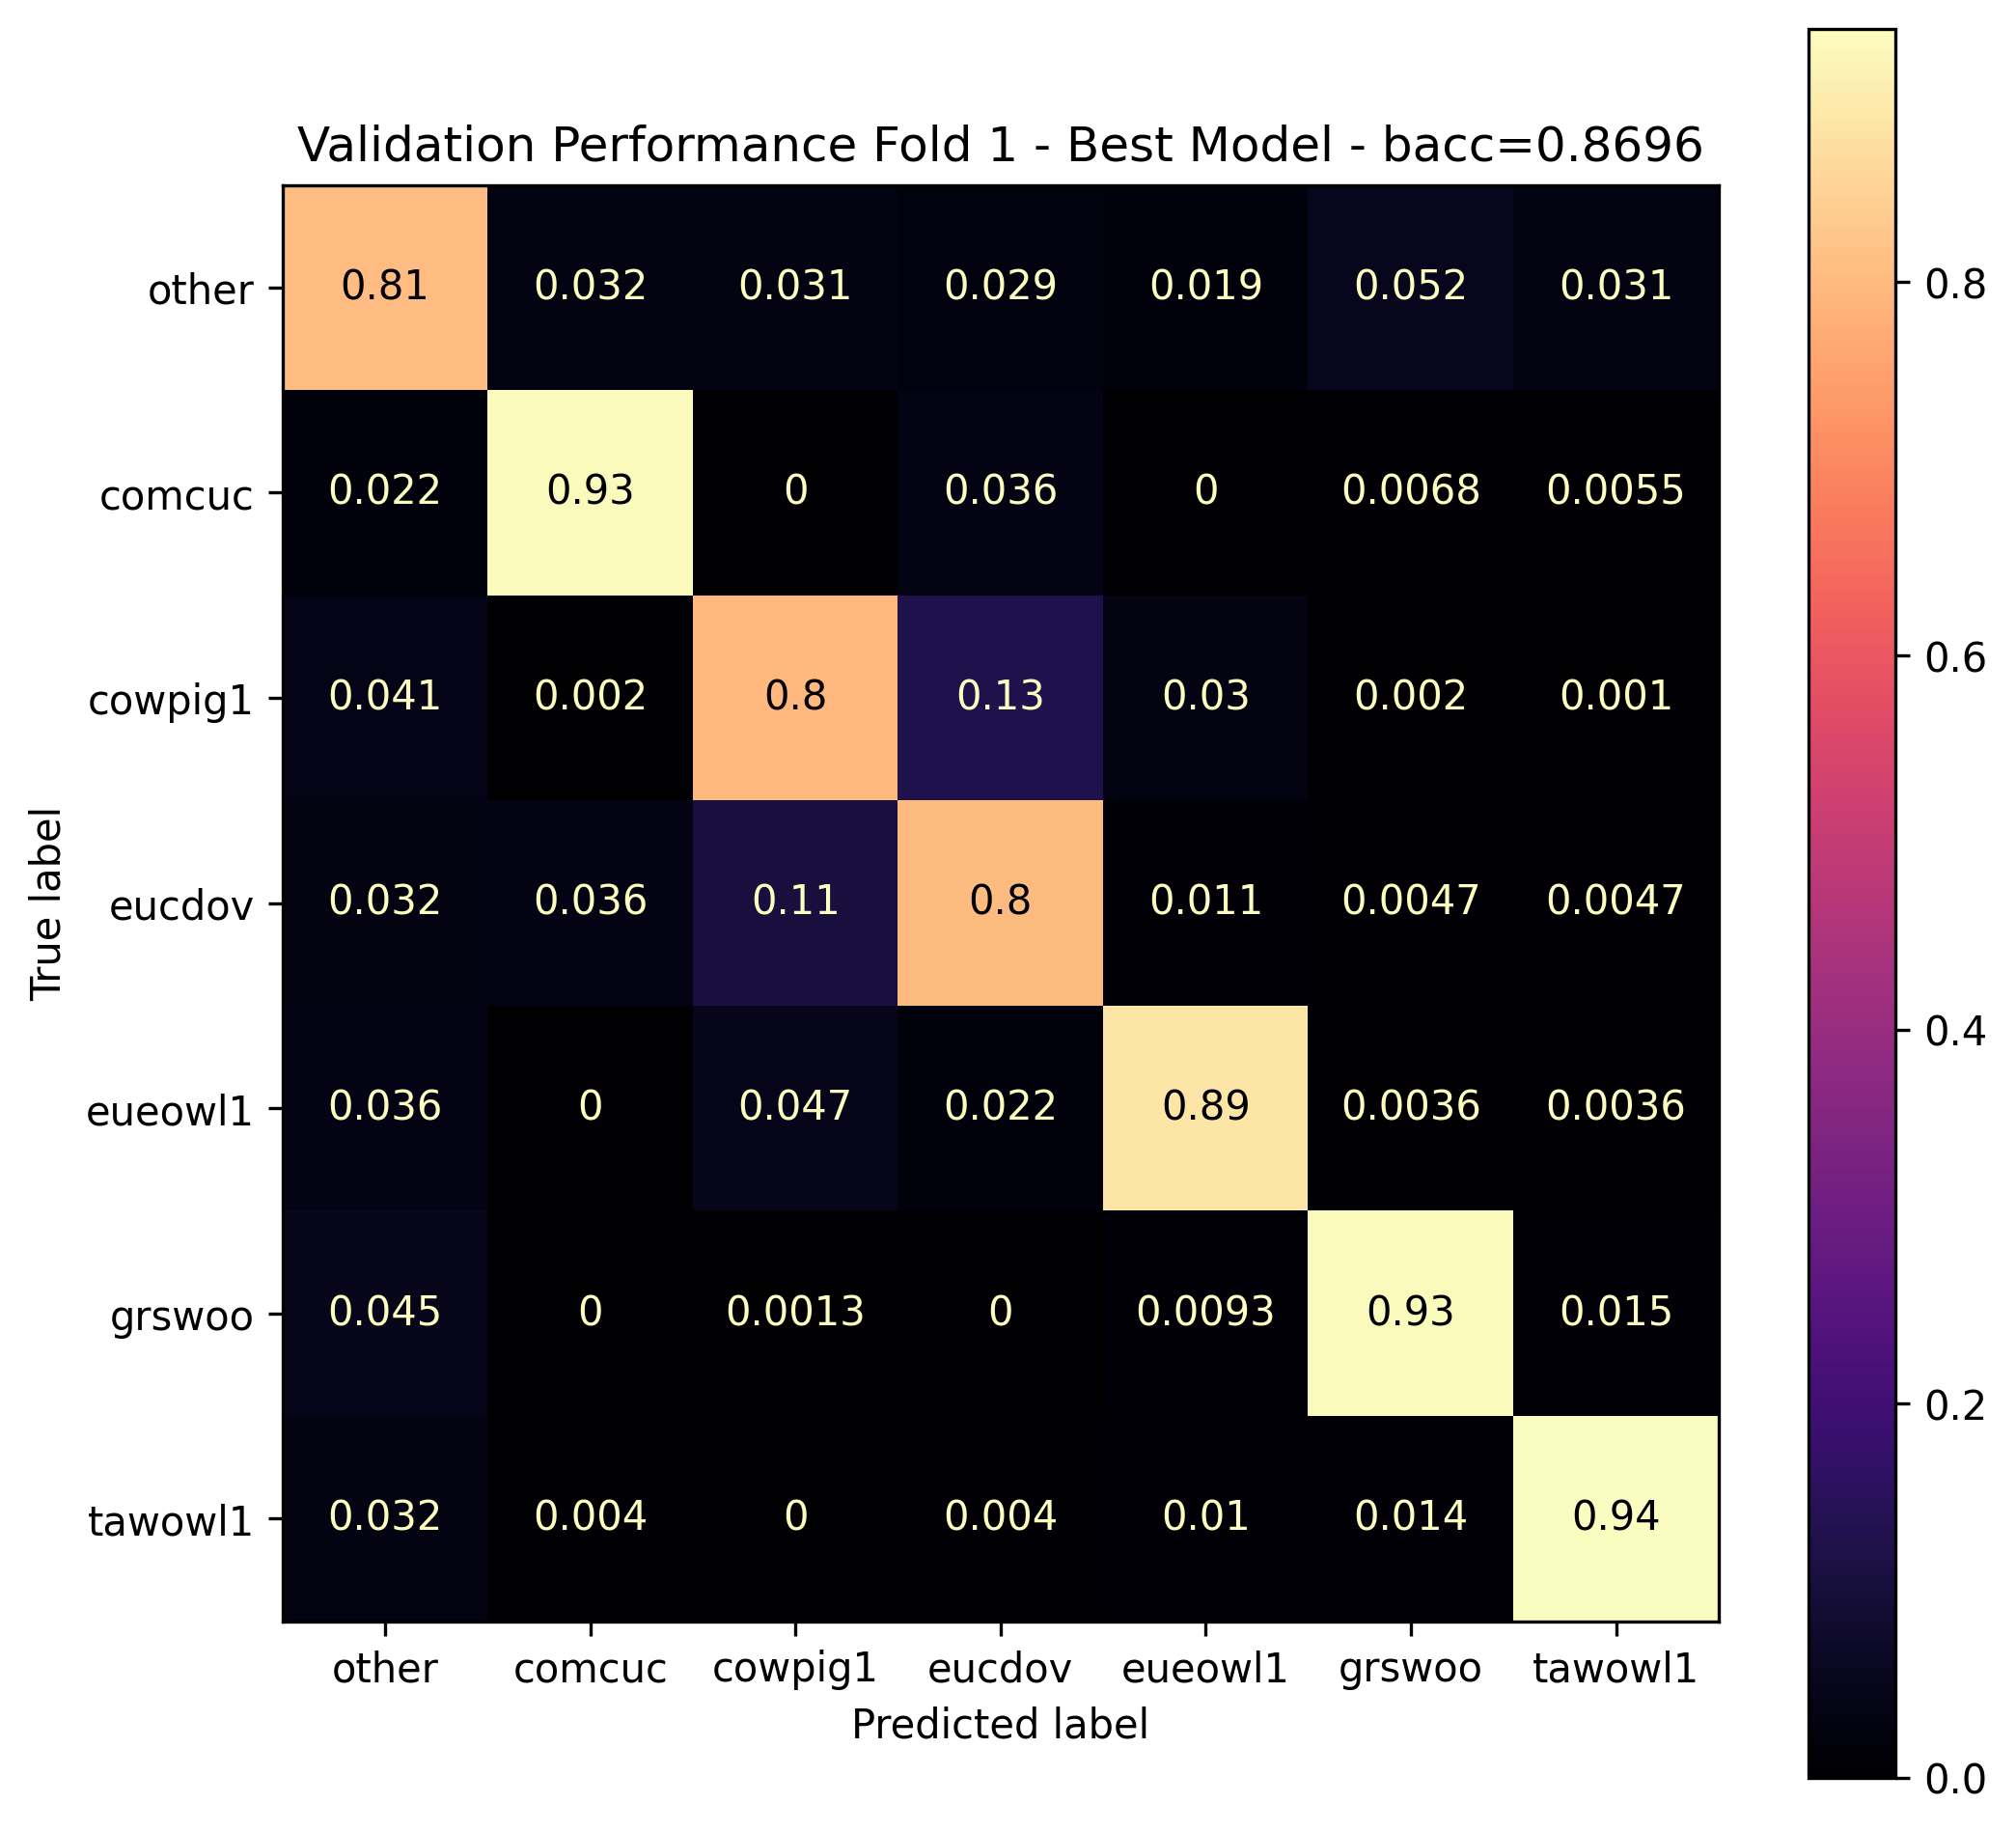

Executing CV for fold 2
Training fold 2
Training AttentionClassifier with 45635 parameters
train label counts = [74697, 5158, 7777, 7077, 1998, 4550, 3743]
loss weights = [1.0, 14.48, 9.6, 10.55, 37.39, 16.42, 19.96]
eval label counts = [10661, 675, 1177, 1121, 326, 561, 479]
eval loss weights = [1.0, 15.79, 9.06, 9.51, 32.7, 19.0, 22.26]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000261, num_samples = 105000, num_correct = 23071, acc = 0.219724, bacc = 0.138053
Evaluation Epoch   1/200: avg_loss = 0.000253, num_samples = 15000, num_correct =   636, acc = 0.042400, bacc = 0.143138
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  5029, acc = 0.047895, bacc = 0.143078
Evaluation Epoch   2/200: avg_loss = 0.000257, num_samples = 15000, num_correct =   674, acc = 0.044933, bacc = 0.146755
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000259, num_samples = 105000, num_correct =  5283, acc = 0.050314, bacc = 0.143562
Evaluation Epoch   3/

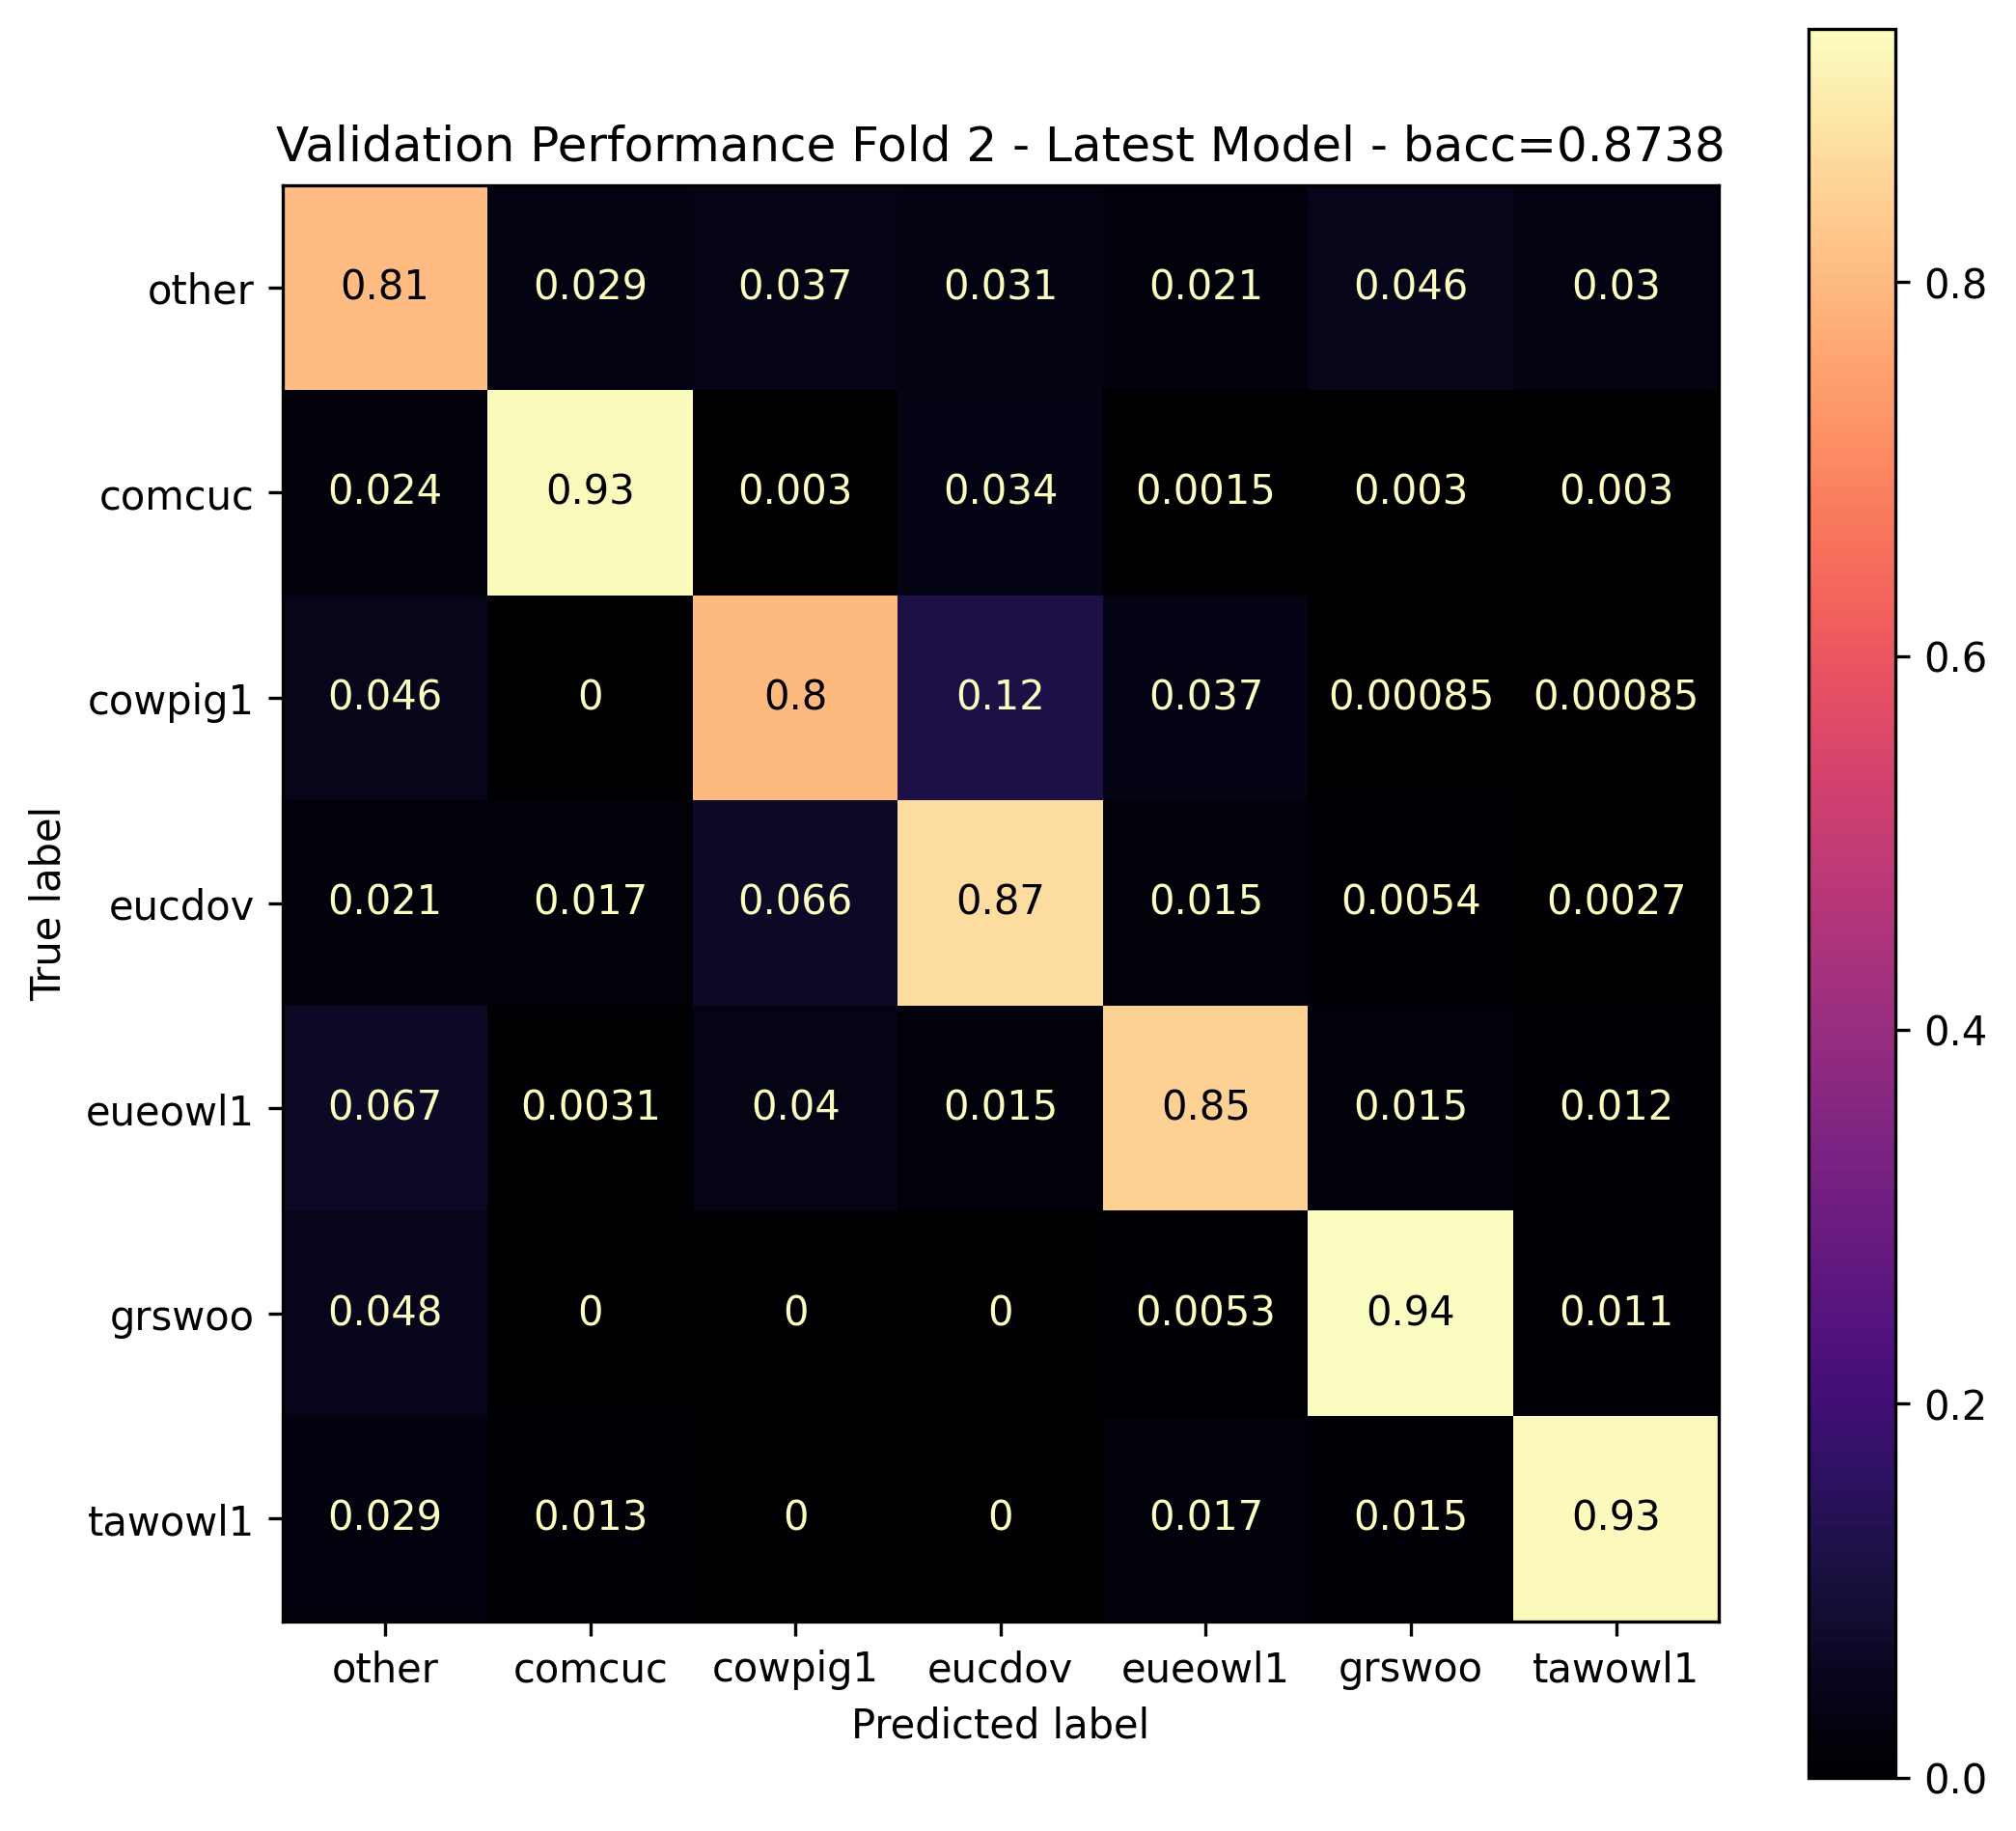

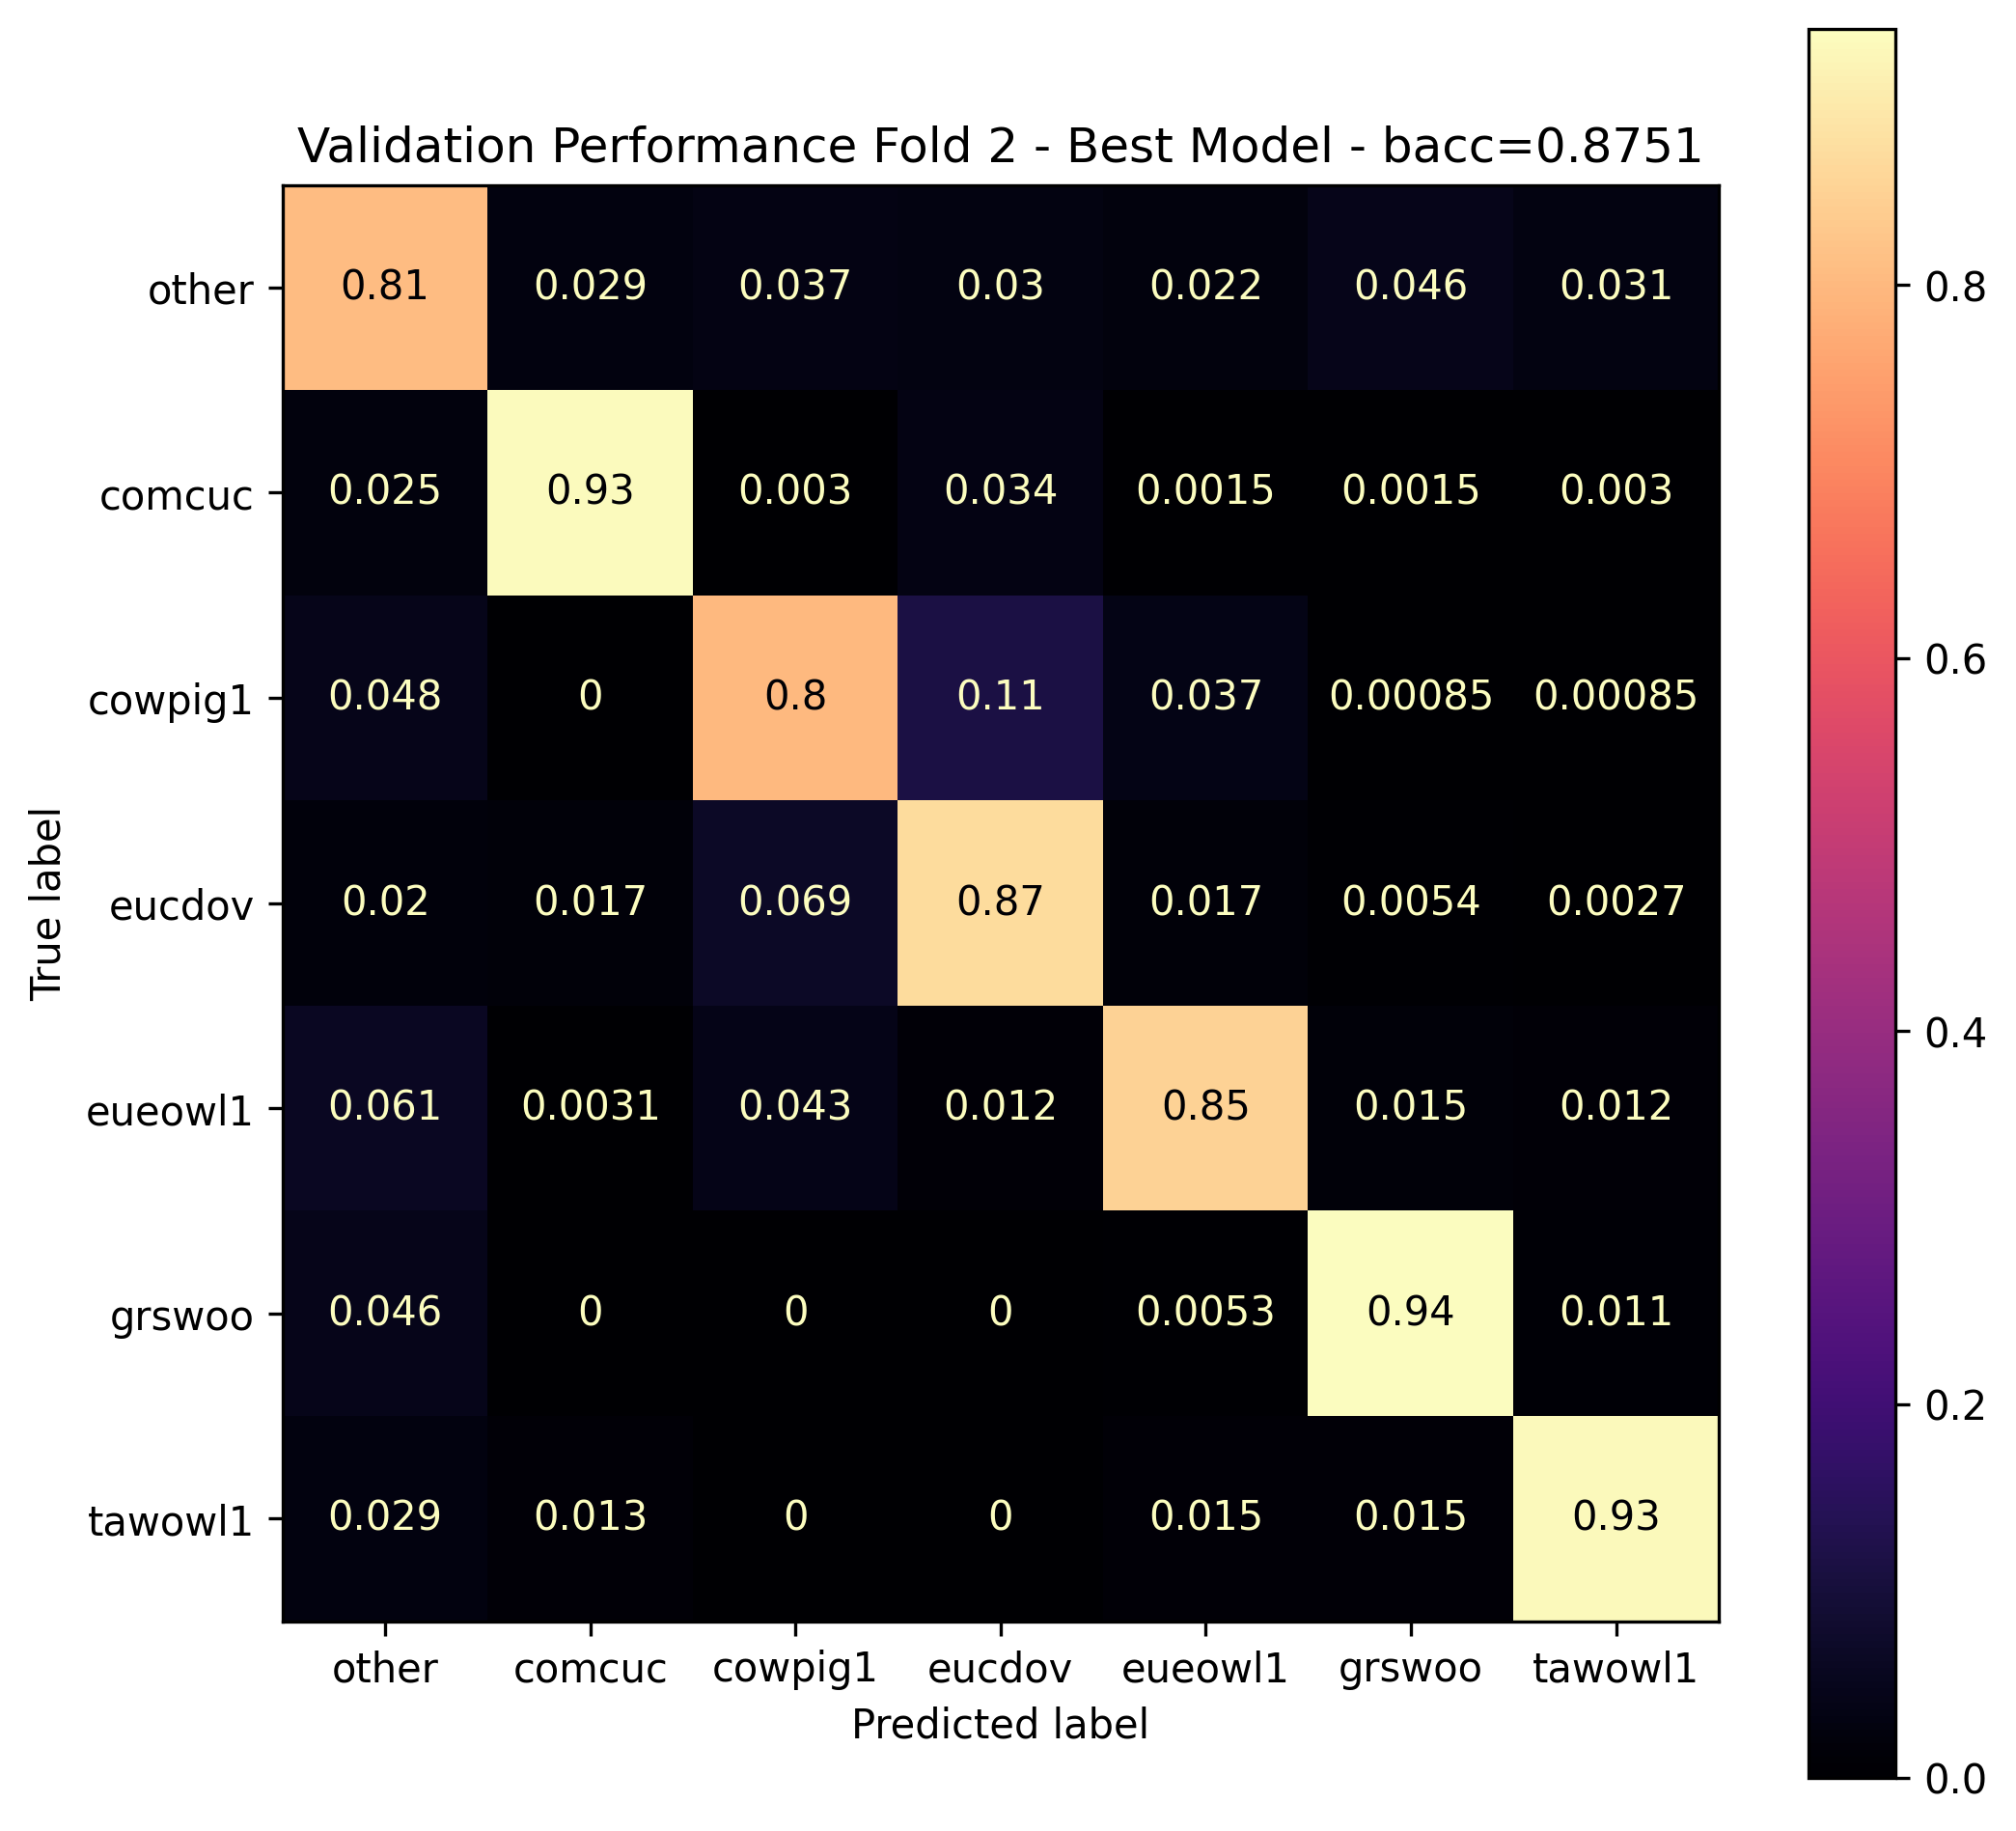

Executing CV for fold 3
Training fold 3
Training AttentionClassifier with 45635 parameters
train label counts = [74697, 5059, 7791, 7269, 2041, 4342, 3801]
loss weights = [1.0, 14.77, 9.59, 10.28, 36.6, 17.2, 19.65]
eval label counts = [10661, 774, 1163, 929, 283, 769, 421]
eval loss weights = [1.0, 13.77, 9.17, 11.48, 37.67, 13.86, 25.32]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000261, num_samples = 105000, num_correct =  4614, acc = 0.043943, bacc = 0.142408
Evaluation Epoch   1/200: avg_loss = 0.000263, num_samples = 15000, num_correct =   432, acc = 0.028800, bacc = 0.142272
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  6229, acc = 0.059324, bacc = 0.141524
Evaluation Epoch   2/200: avg_loss = 0.000257, num_samples = 15000, num_correct =  1653, acc = 0.110200, bacc = 0.135010
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000259, num_samples = 105000, num_correct = 14977, acc = 0.142638, bacc = 0.143331
Evaluation Epoch   3

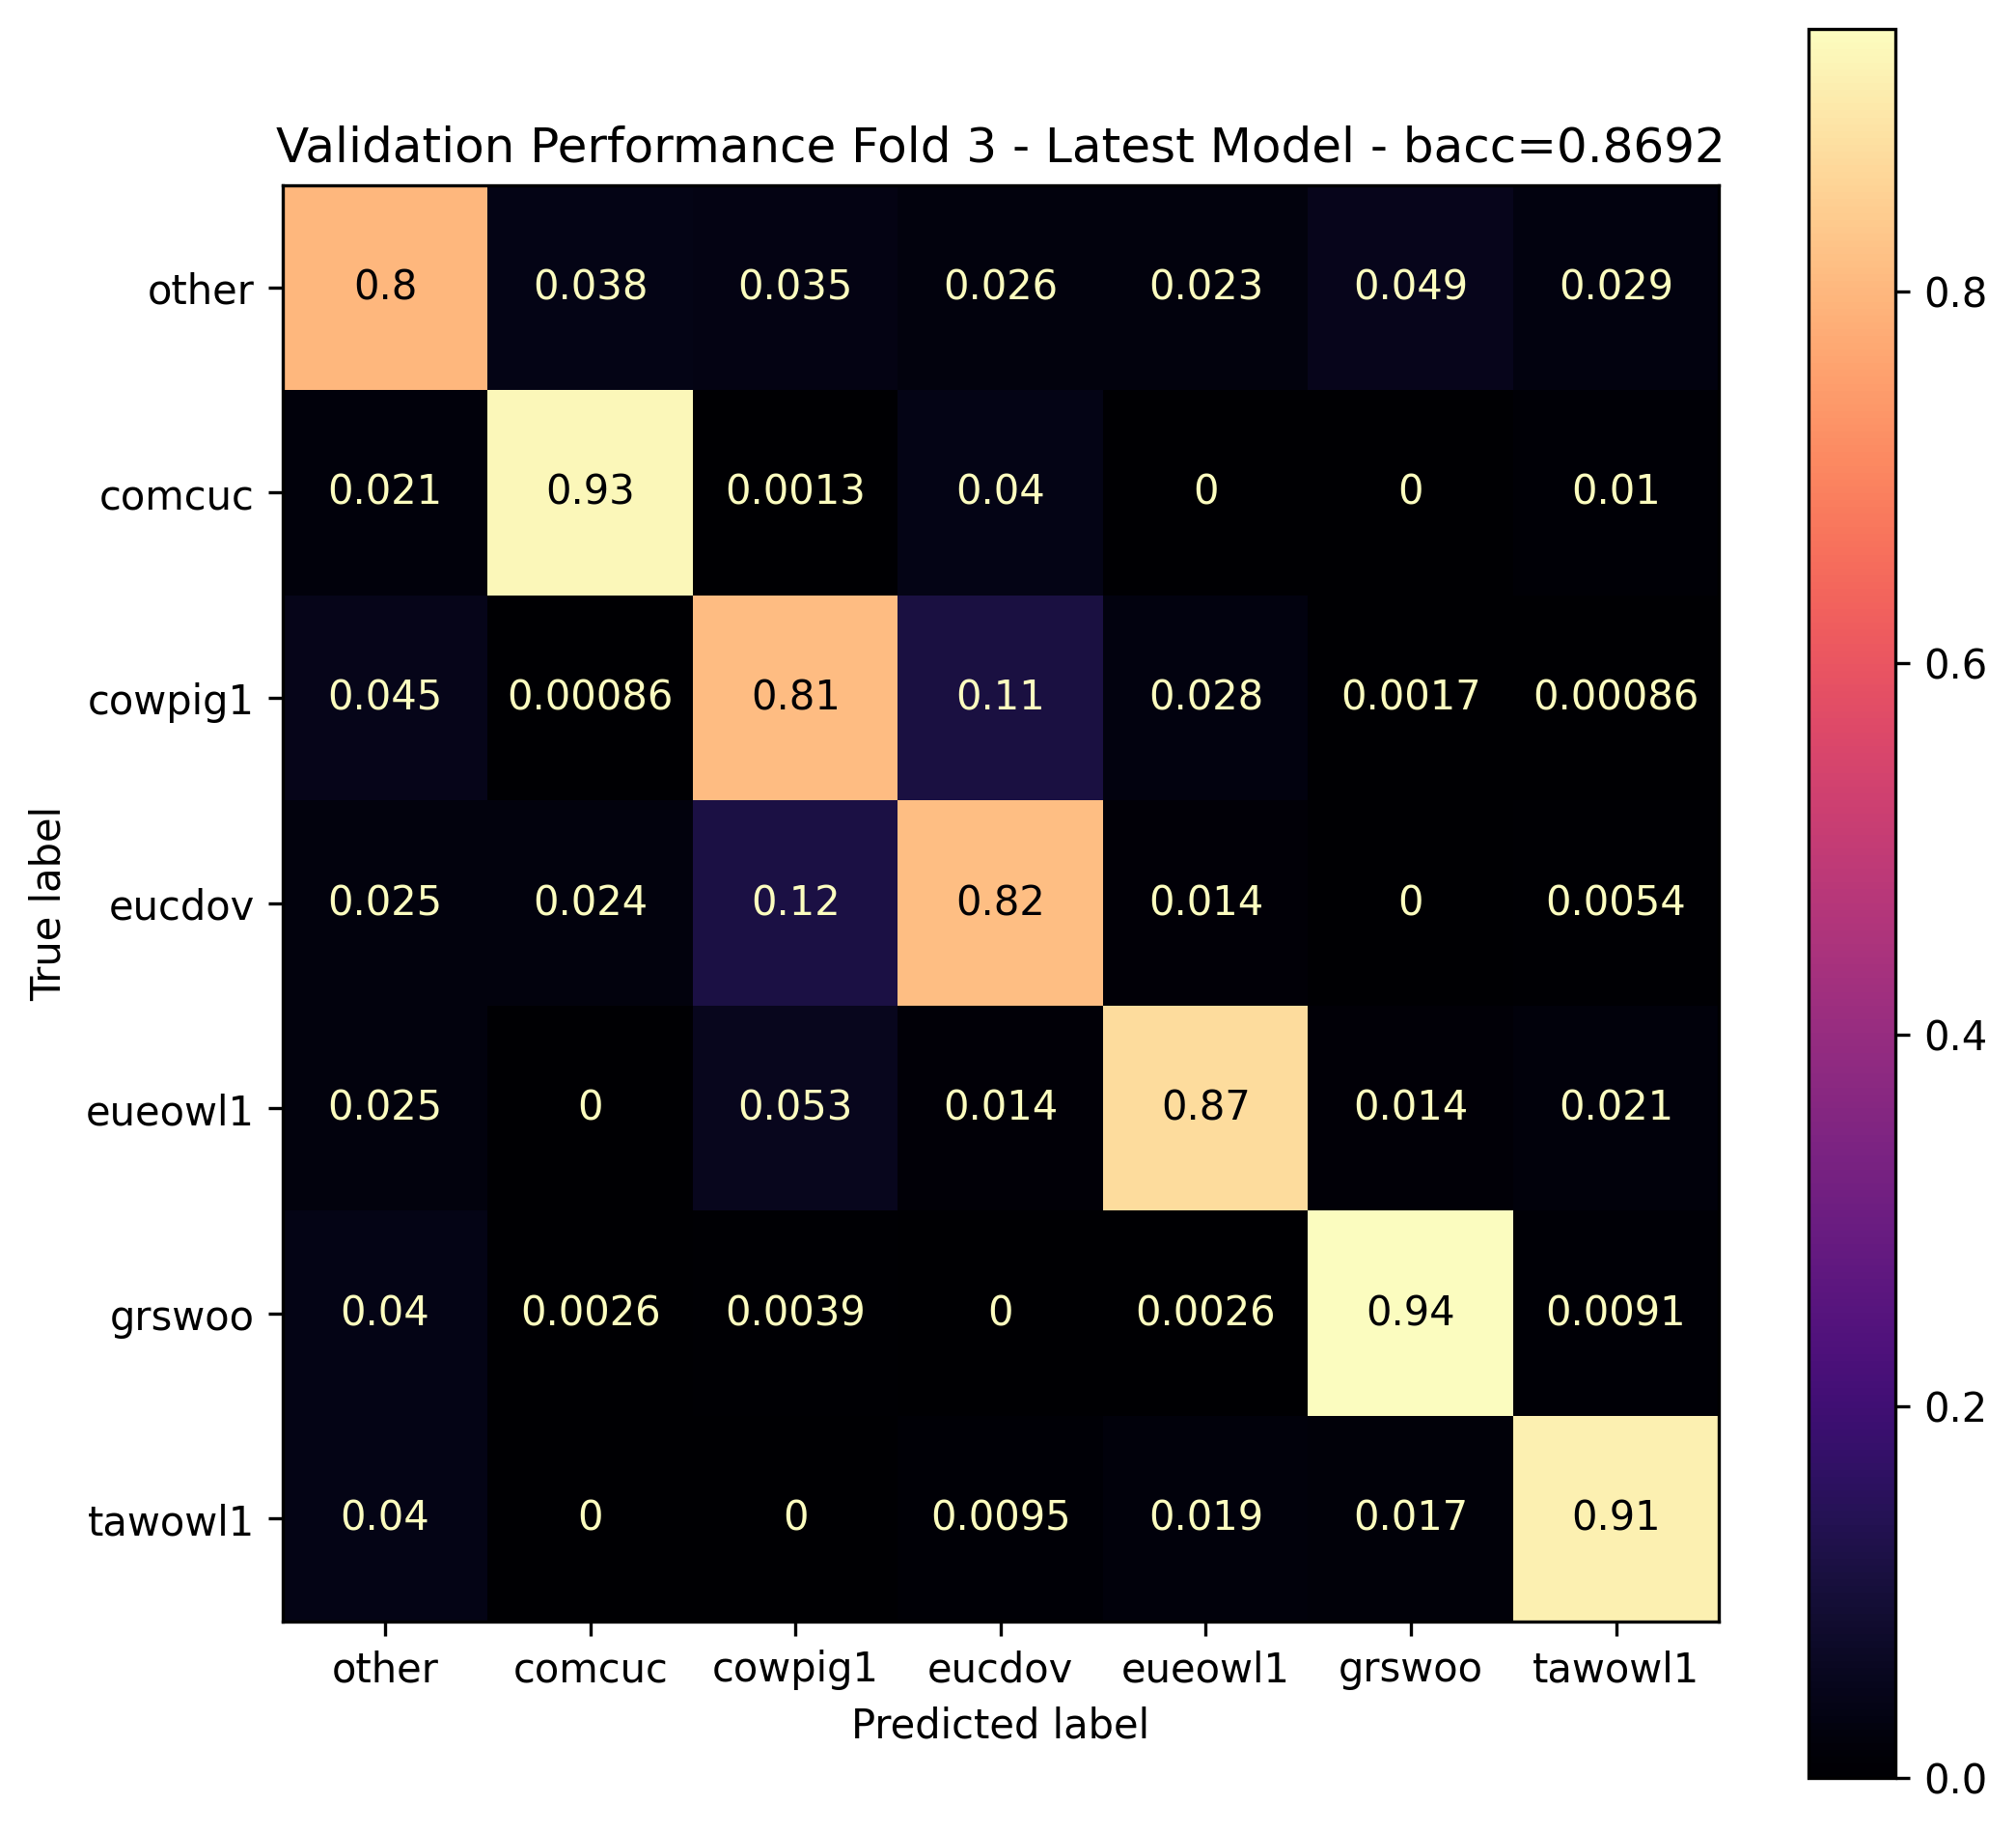

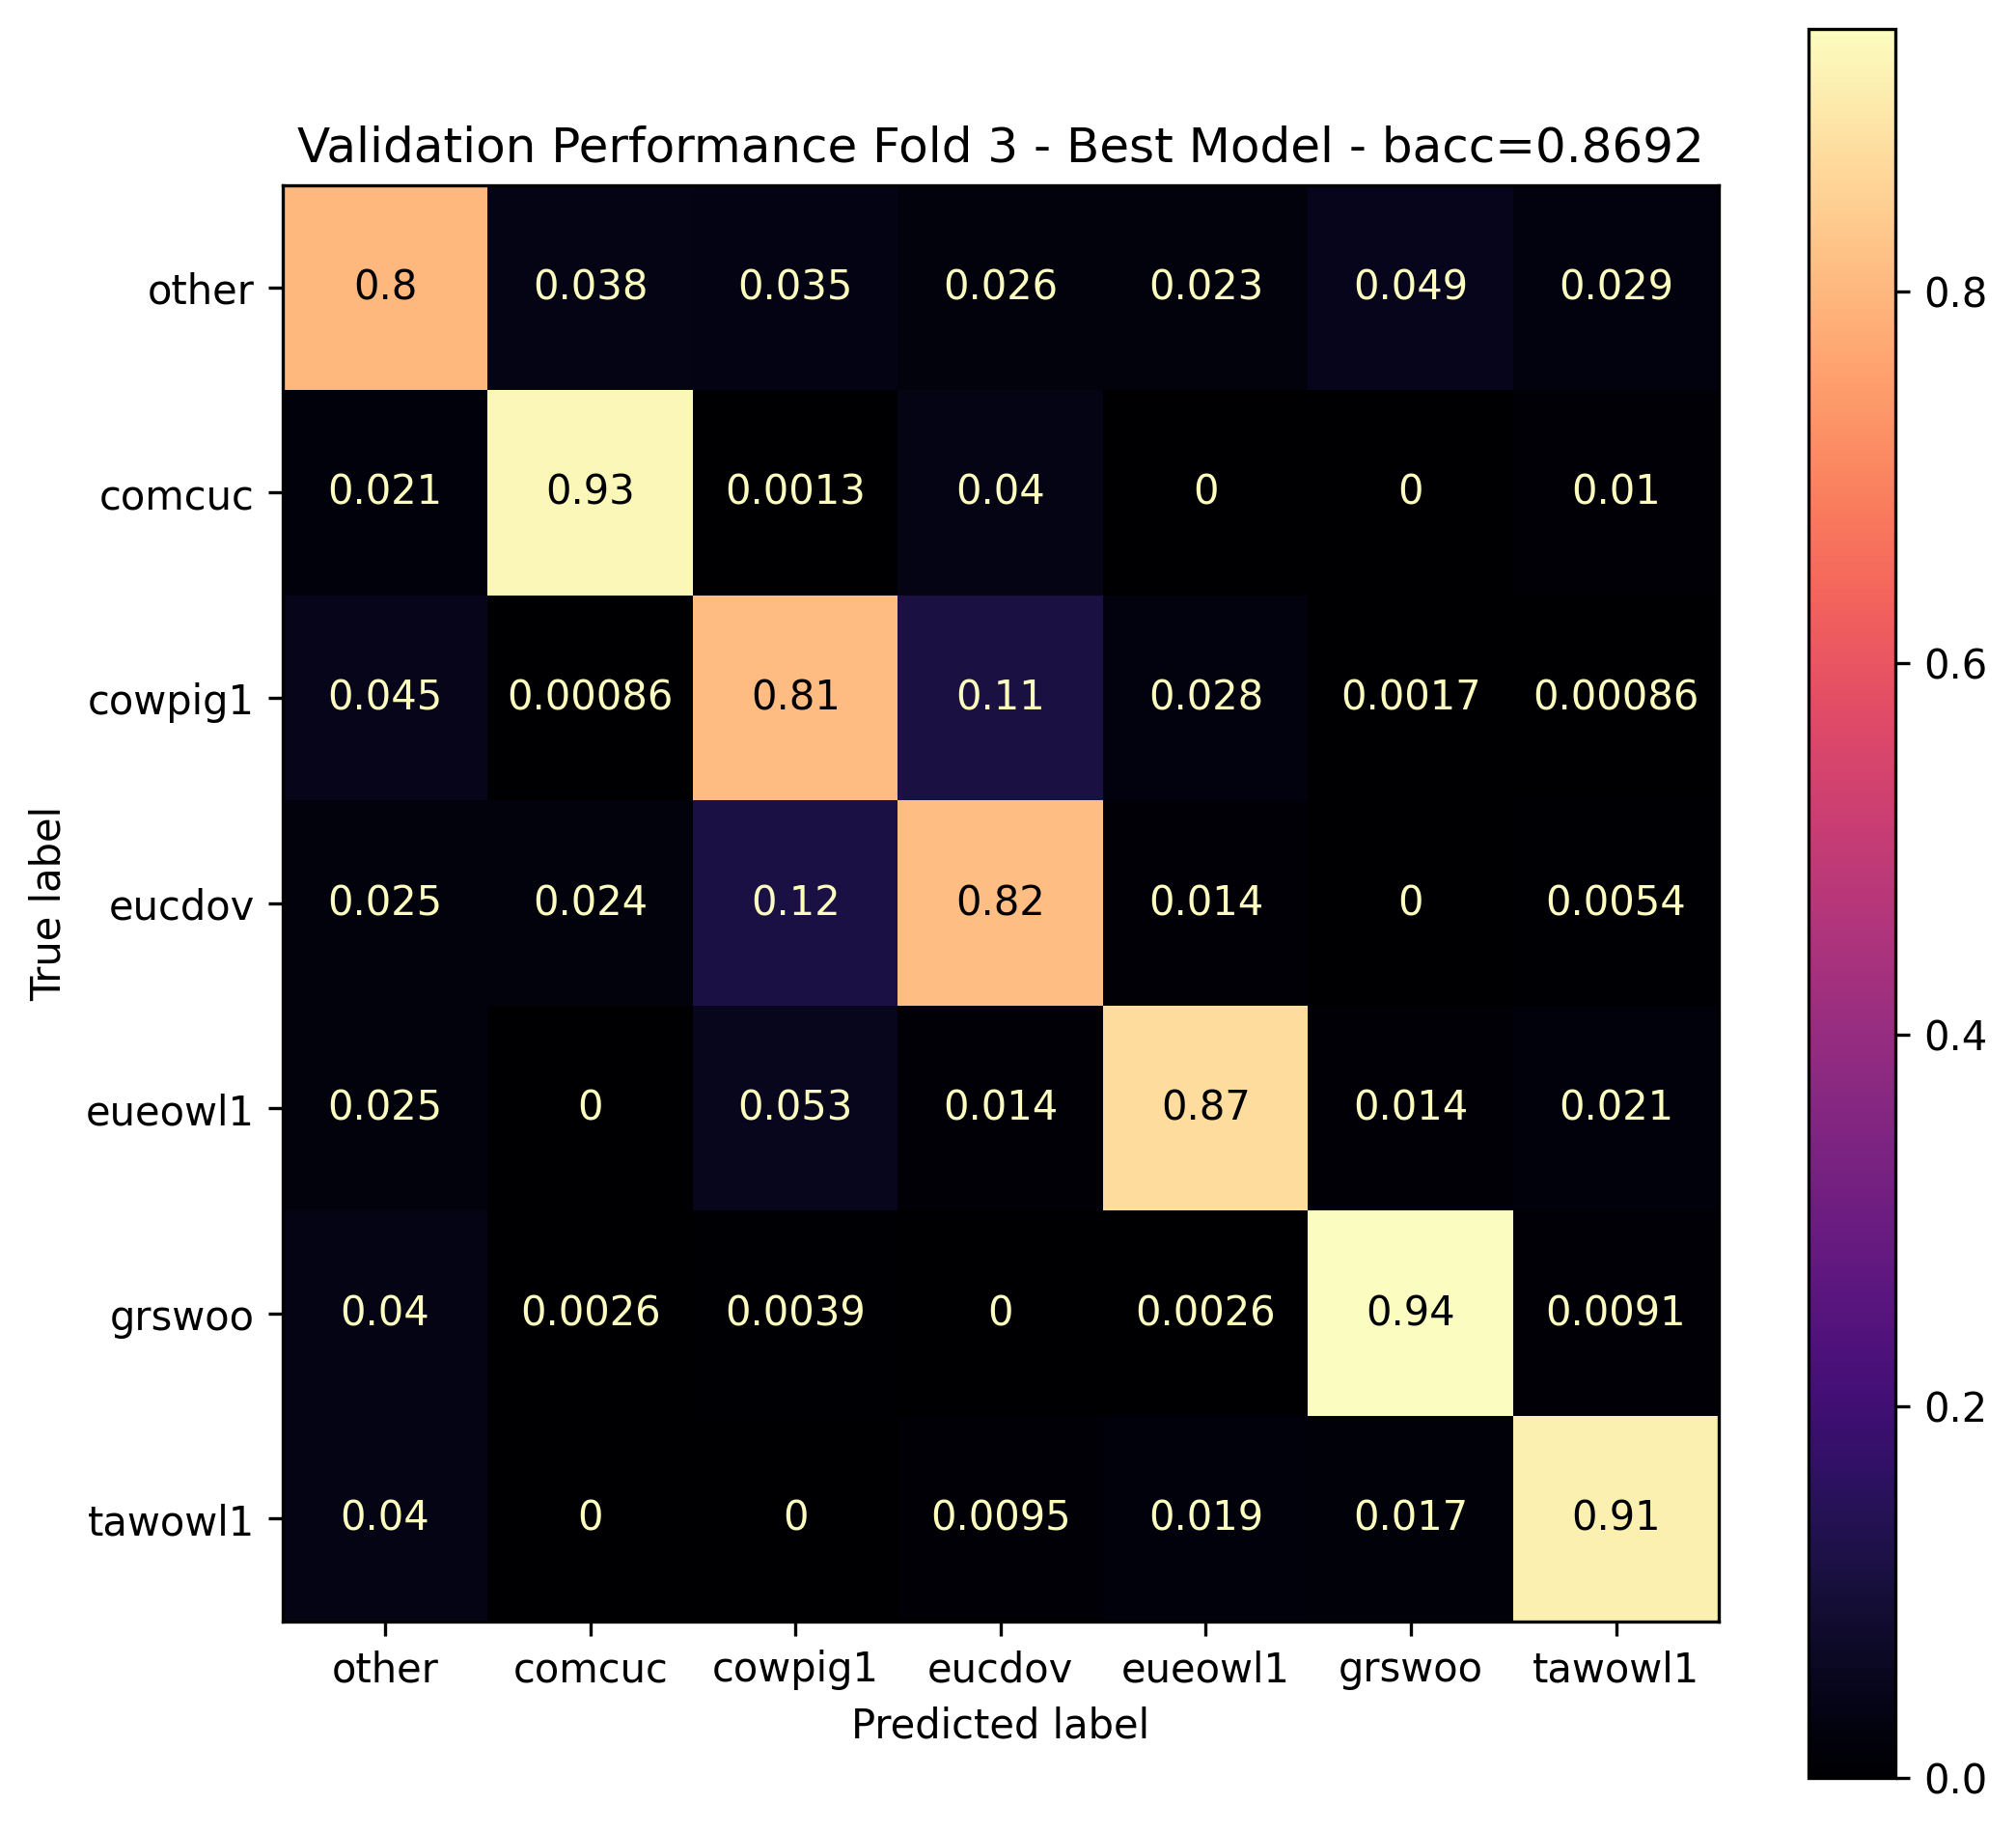

Executing CV for fold 4
Training fold 4
Training AttentionClassifier with 45635 parameters
train label counts = [74757, 5135, 7629, 7325, 2057, 4436, 3661]
loss weights = [1.0, 14.56, 9.8, 10.21, 36.34, 16.85, 20.42]
eval label counts = [10601, 698, 1325, 873, 267, 675, 561]
eval loss weights = [1.0, 15.19, 8.0, 12.14, 39.7, 15.71, 18.9]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct = 21244, acc = 0.202324, bacc = 0.145094
Evaluation Epoch   1/200: avg_loss = 0.000252, num_samples = 15000, num_correct =  4835, acc = 0.322333, bacc = 0.135780
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct = 26264, acc = 0.250133, bacc = 0.143724
Evaluation Epoch   2/200: avg_loss = 0.000254, num_samples = 15000, num_correct =  2479, acc = 0.165267, bacc = 0.138687
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000259, num_samples = 105000, num_correct = 14508, acc = 0.138171, bacc = 0.152785
Evaluation Epoch   3/2

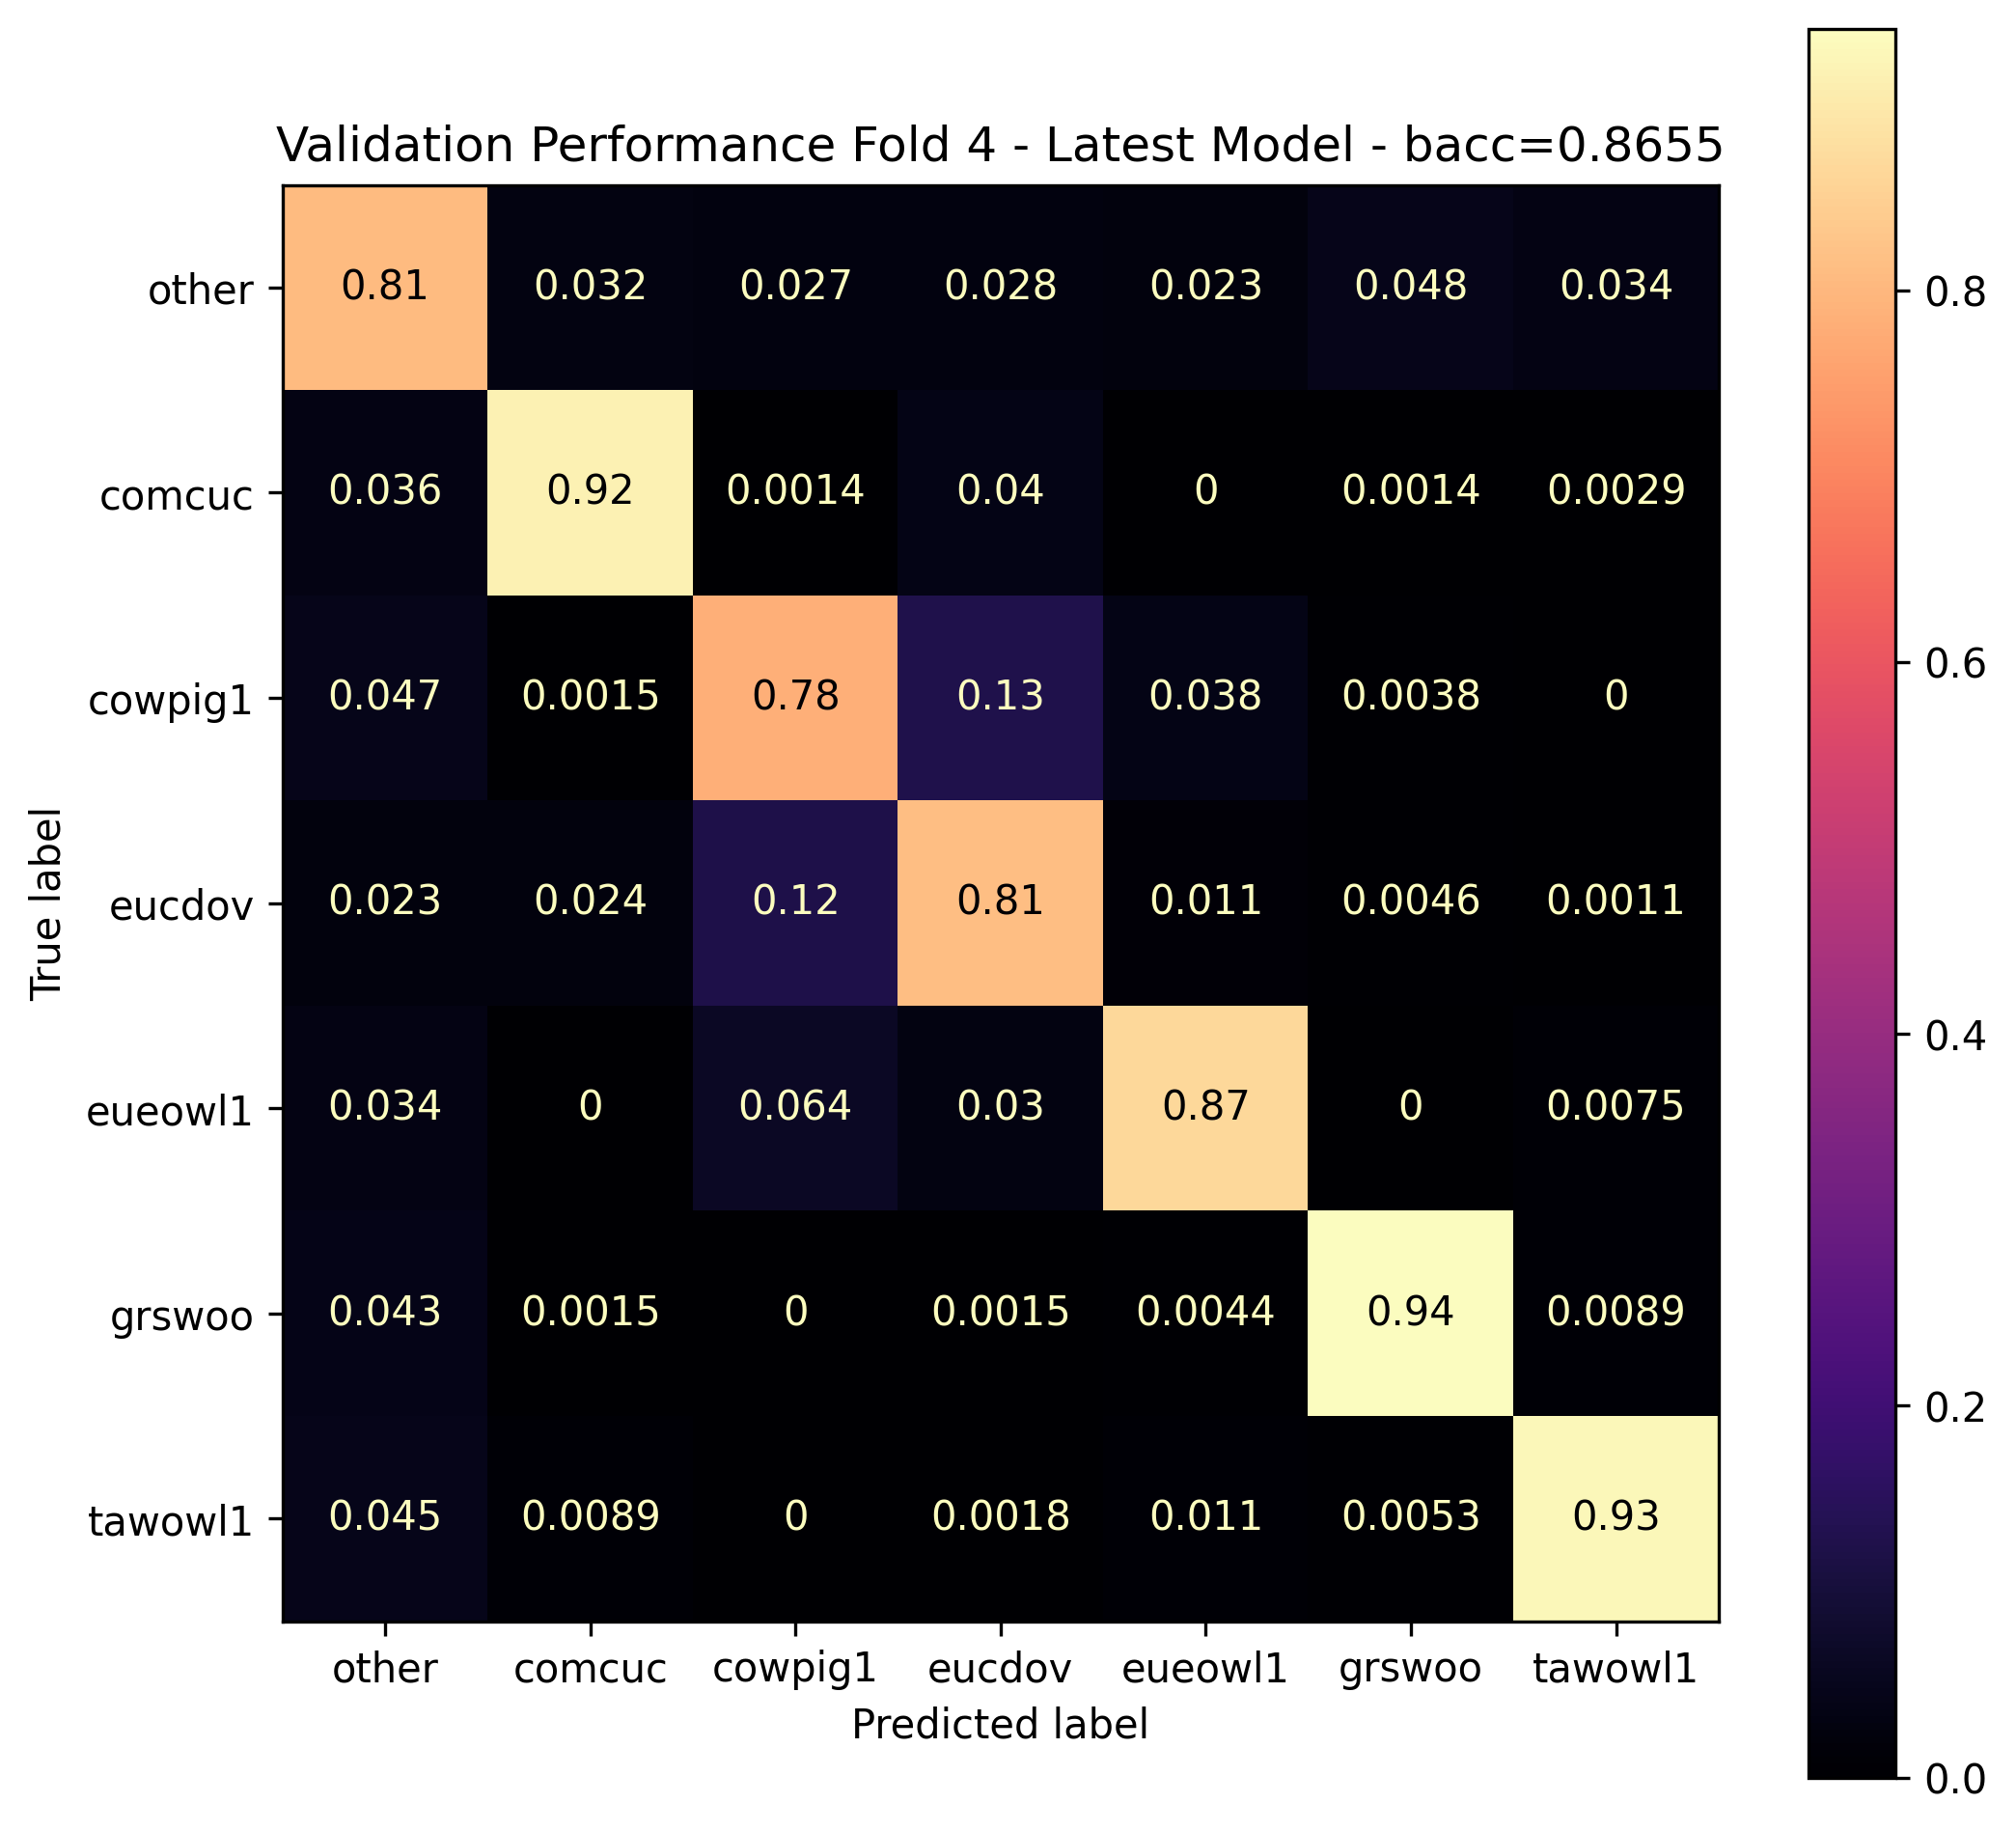

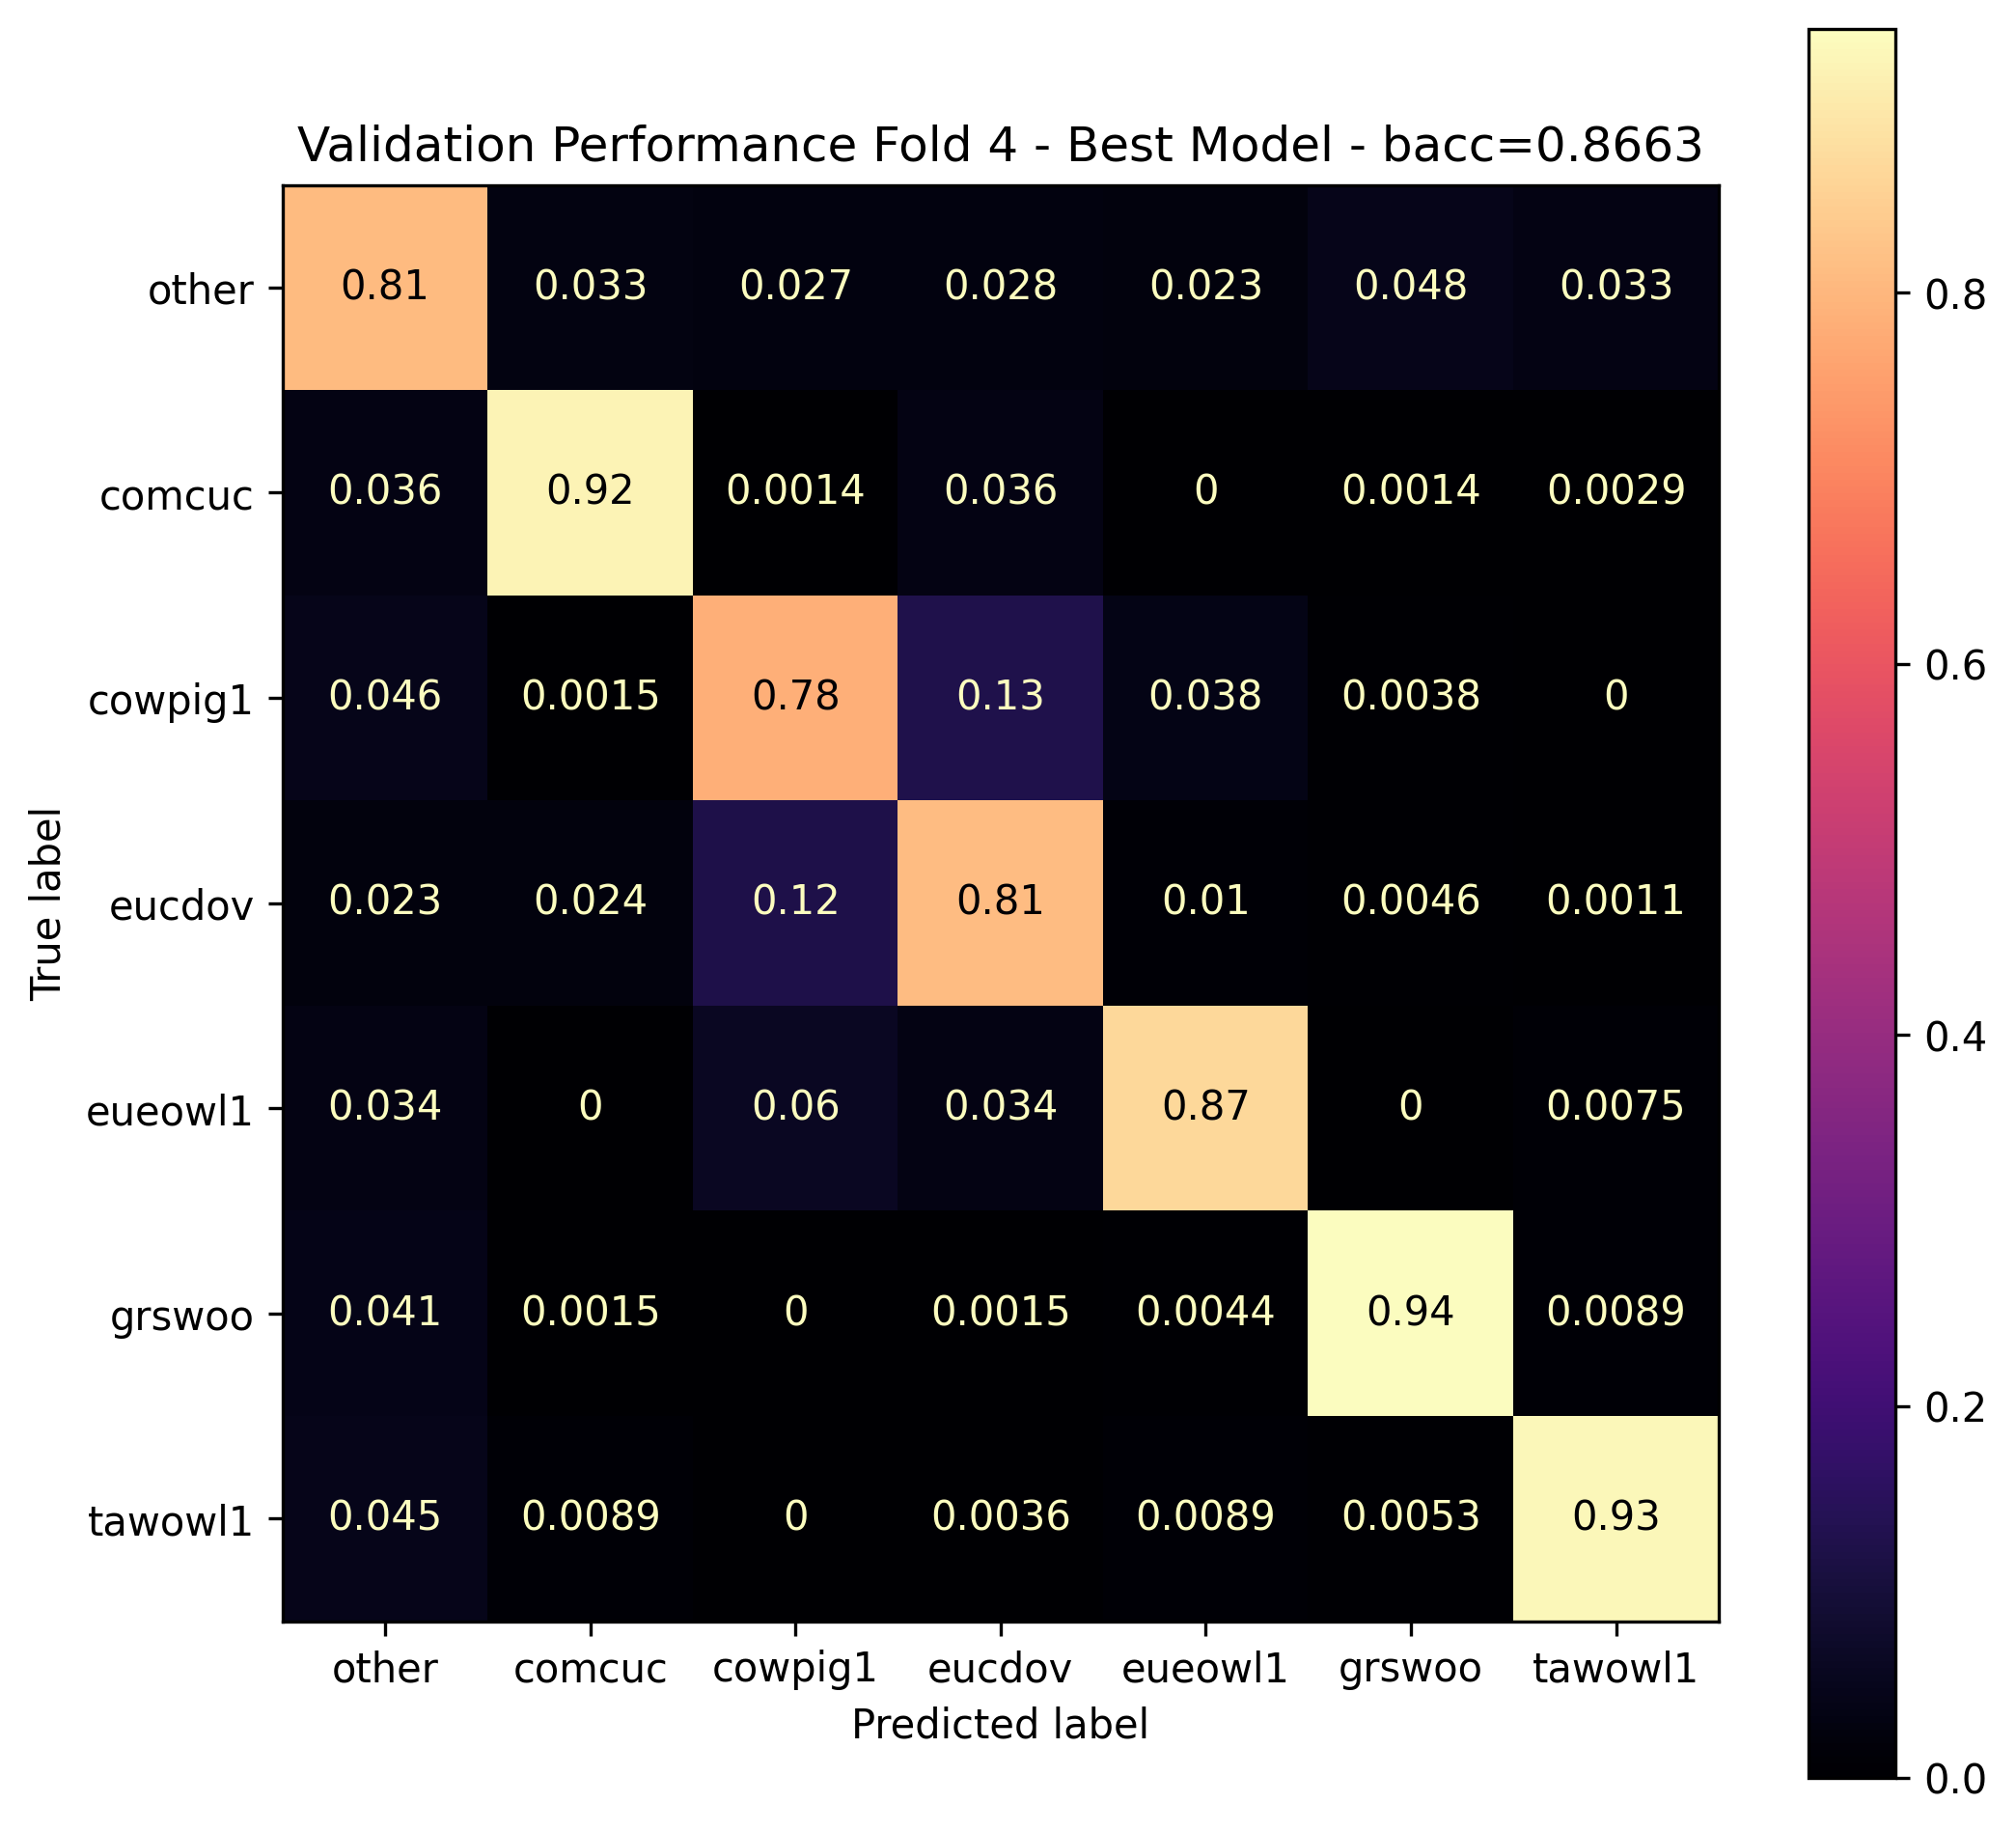

Executing CV for fold 5
Training fold 5
Training AttentionClassifier with 45635 parameters
train label counts = [74587, 4996, 8138, 7107, 2021, 4351, 3800]
loss weights = [1.0, 14.93, 9.17, 10.49, 36.91, 17.14, 19.63]
eval label counts = [10771, 837, 816, 1091, 303, 760, 422]
eval loss weights = [1.0, 12.87, 13.2, 9.87, 35.55, 14.17, 25.52]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct = 37292, acc = 0.355162, bacc = 0.137204
Evaluation Epoch   1/200: avg_loss = 0.000253, num_samples = 15000, num_correct =  6477, acc = 0.431800, bacc = 0.140630
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct = 25361, acc = 0.241533, bacc = 0.144178
Evaluation Epoch   2/200: avg_loss = 0.000259, num_samples = 15000, num_correct =  1472, acc = 0.098133, bacc = 0.142896
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  7994, acc = 0.076133, bacc = 0.144980
Evaluation Epoch   

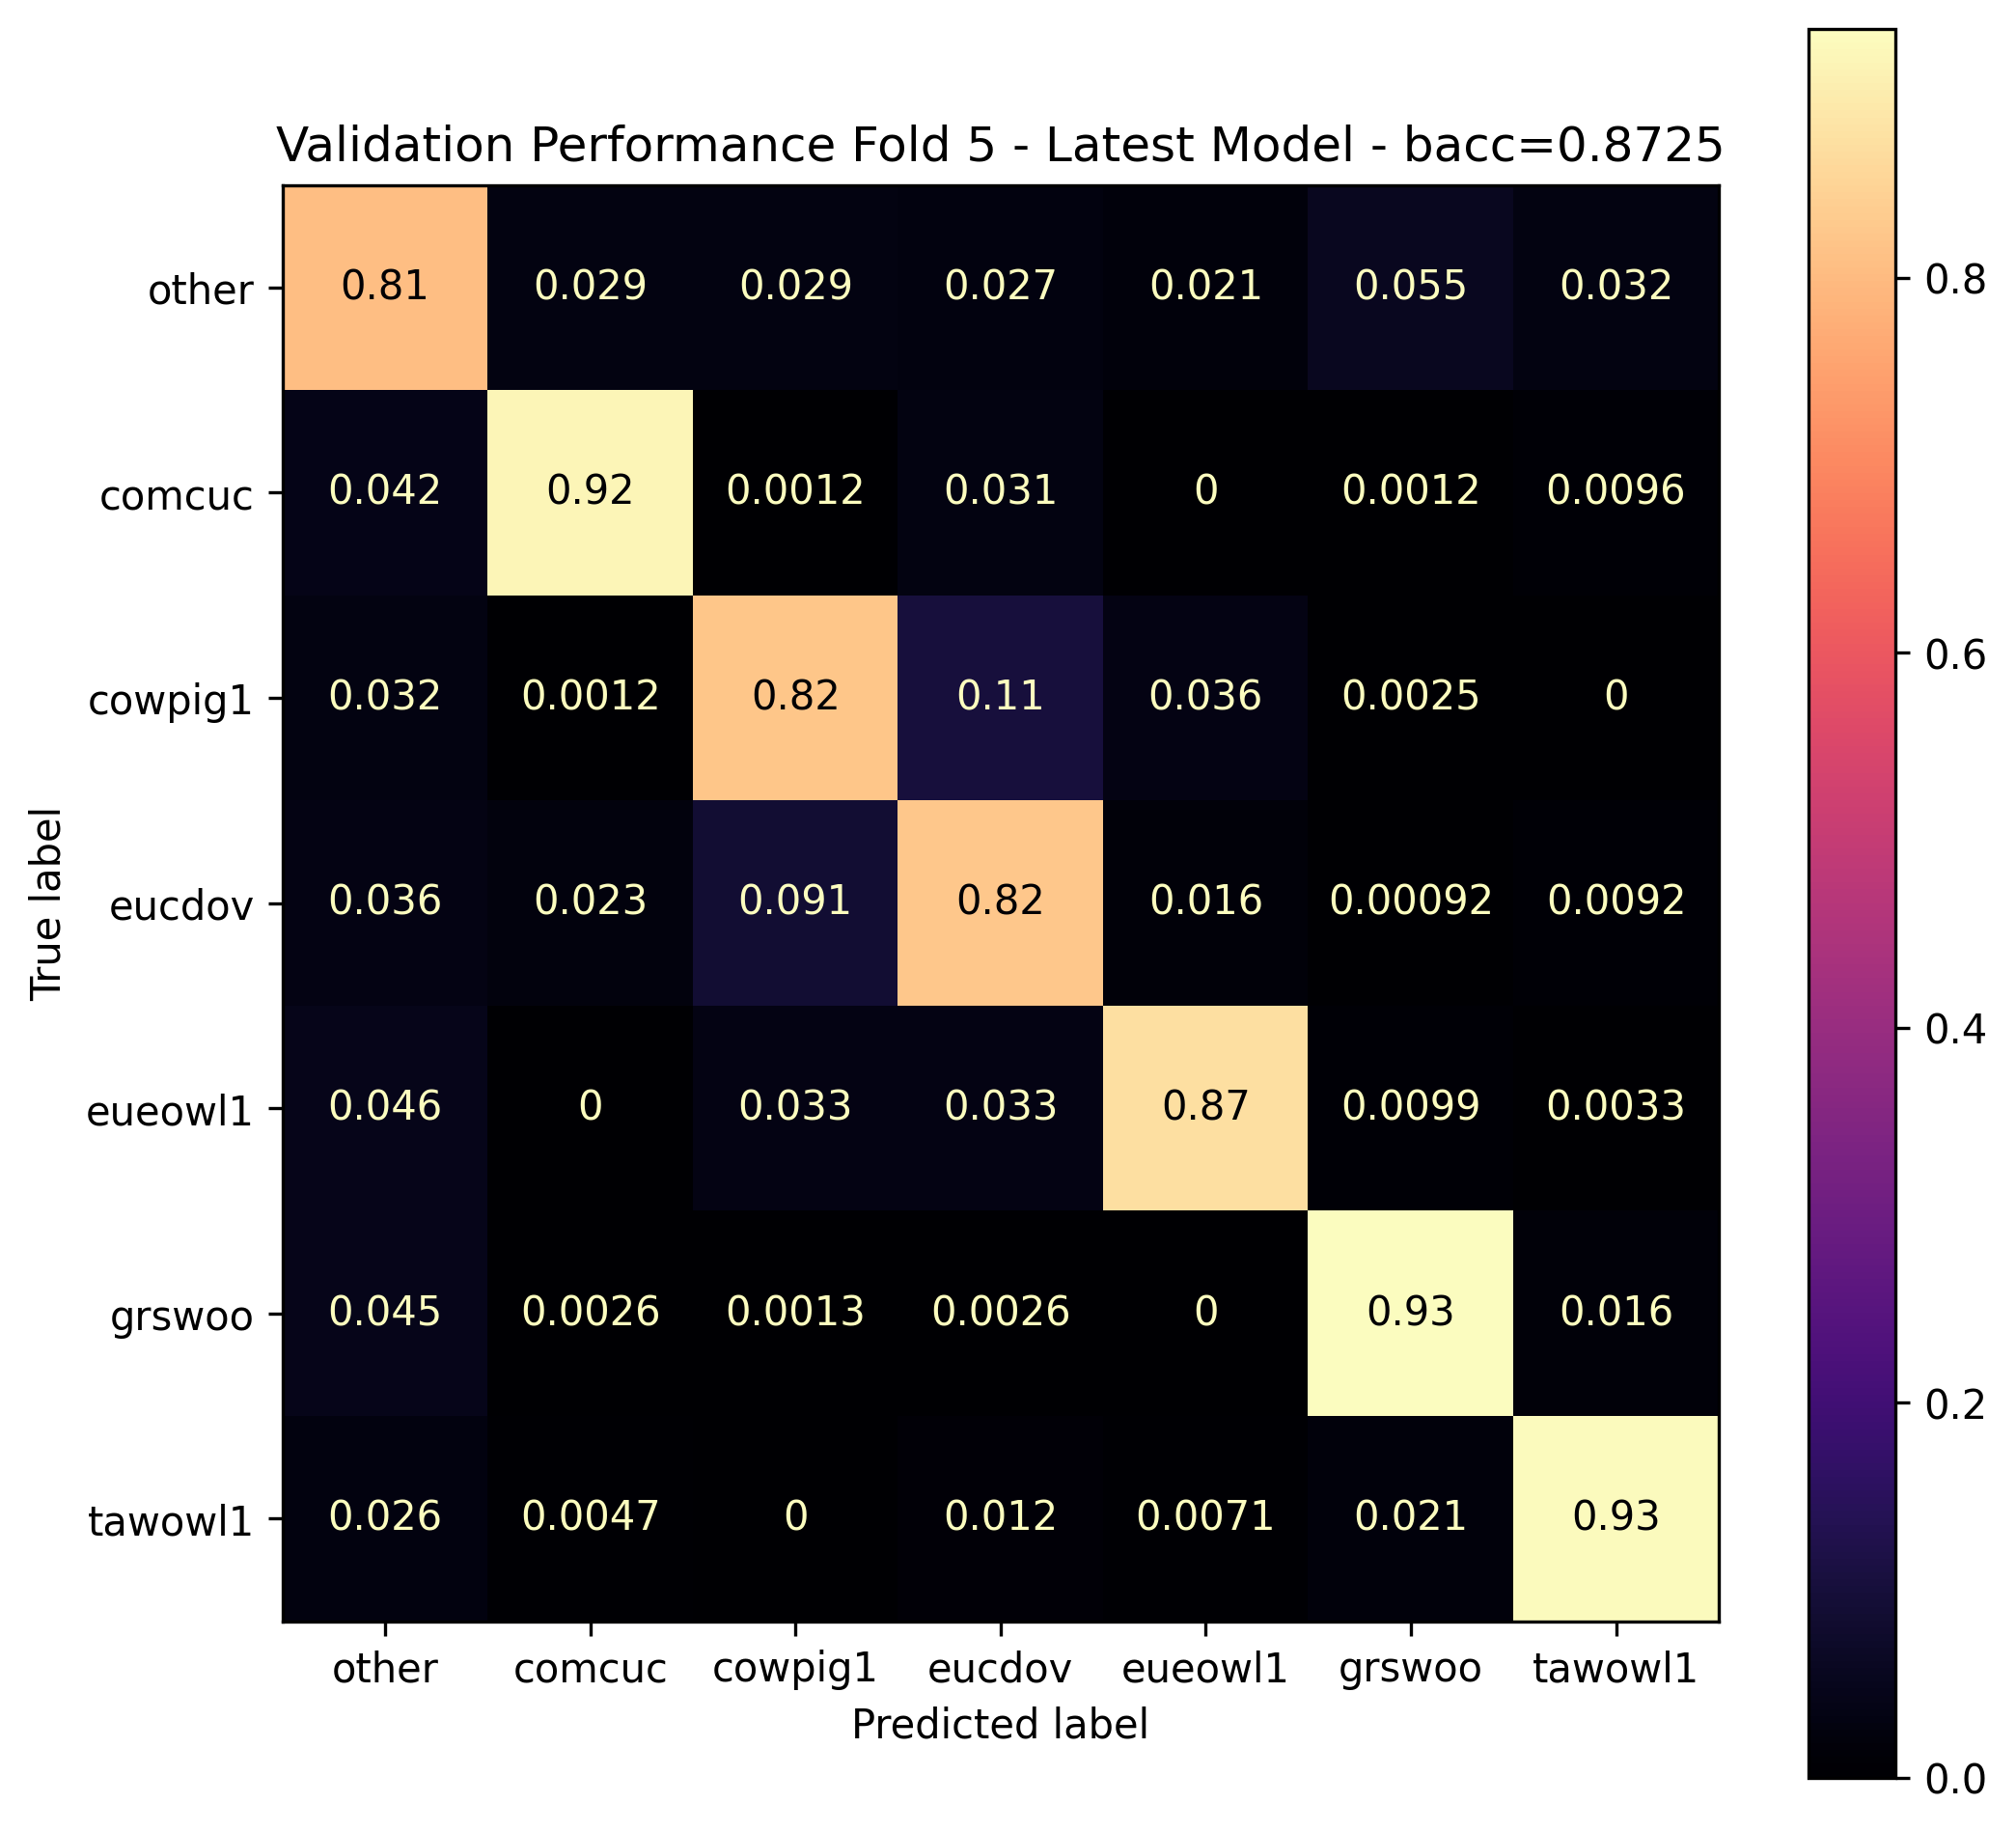

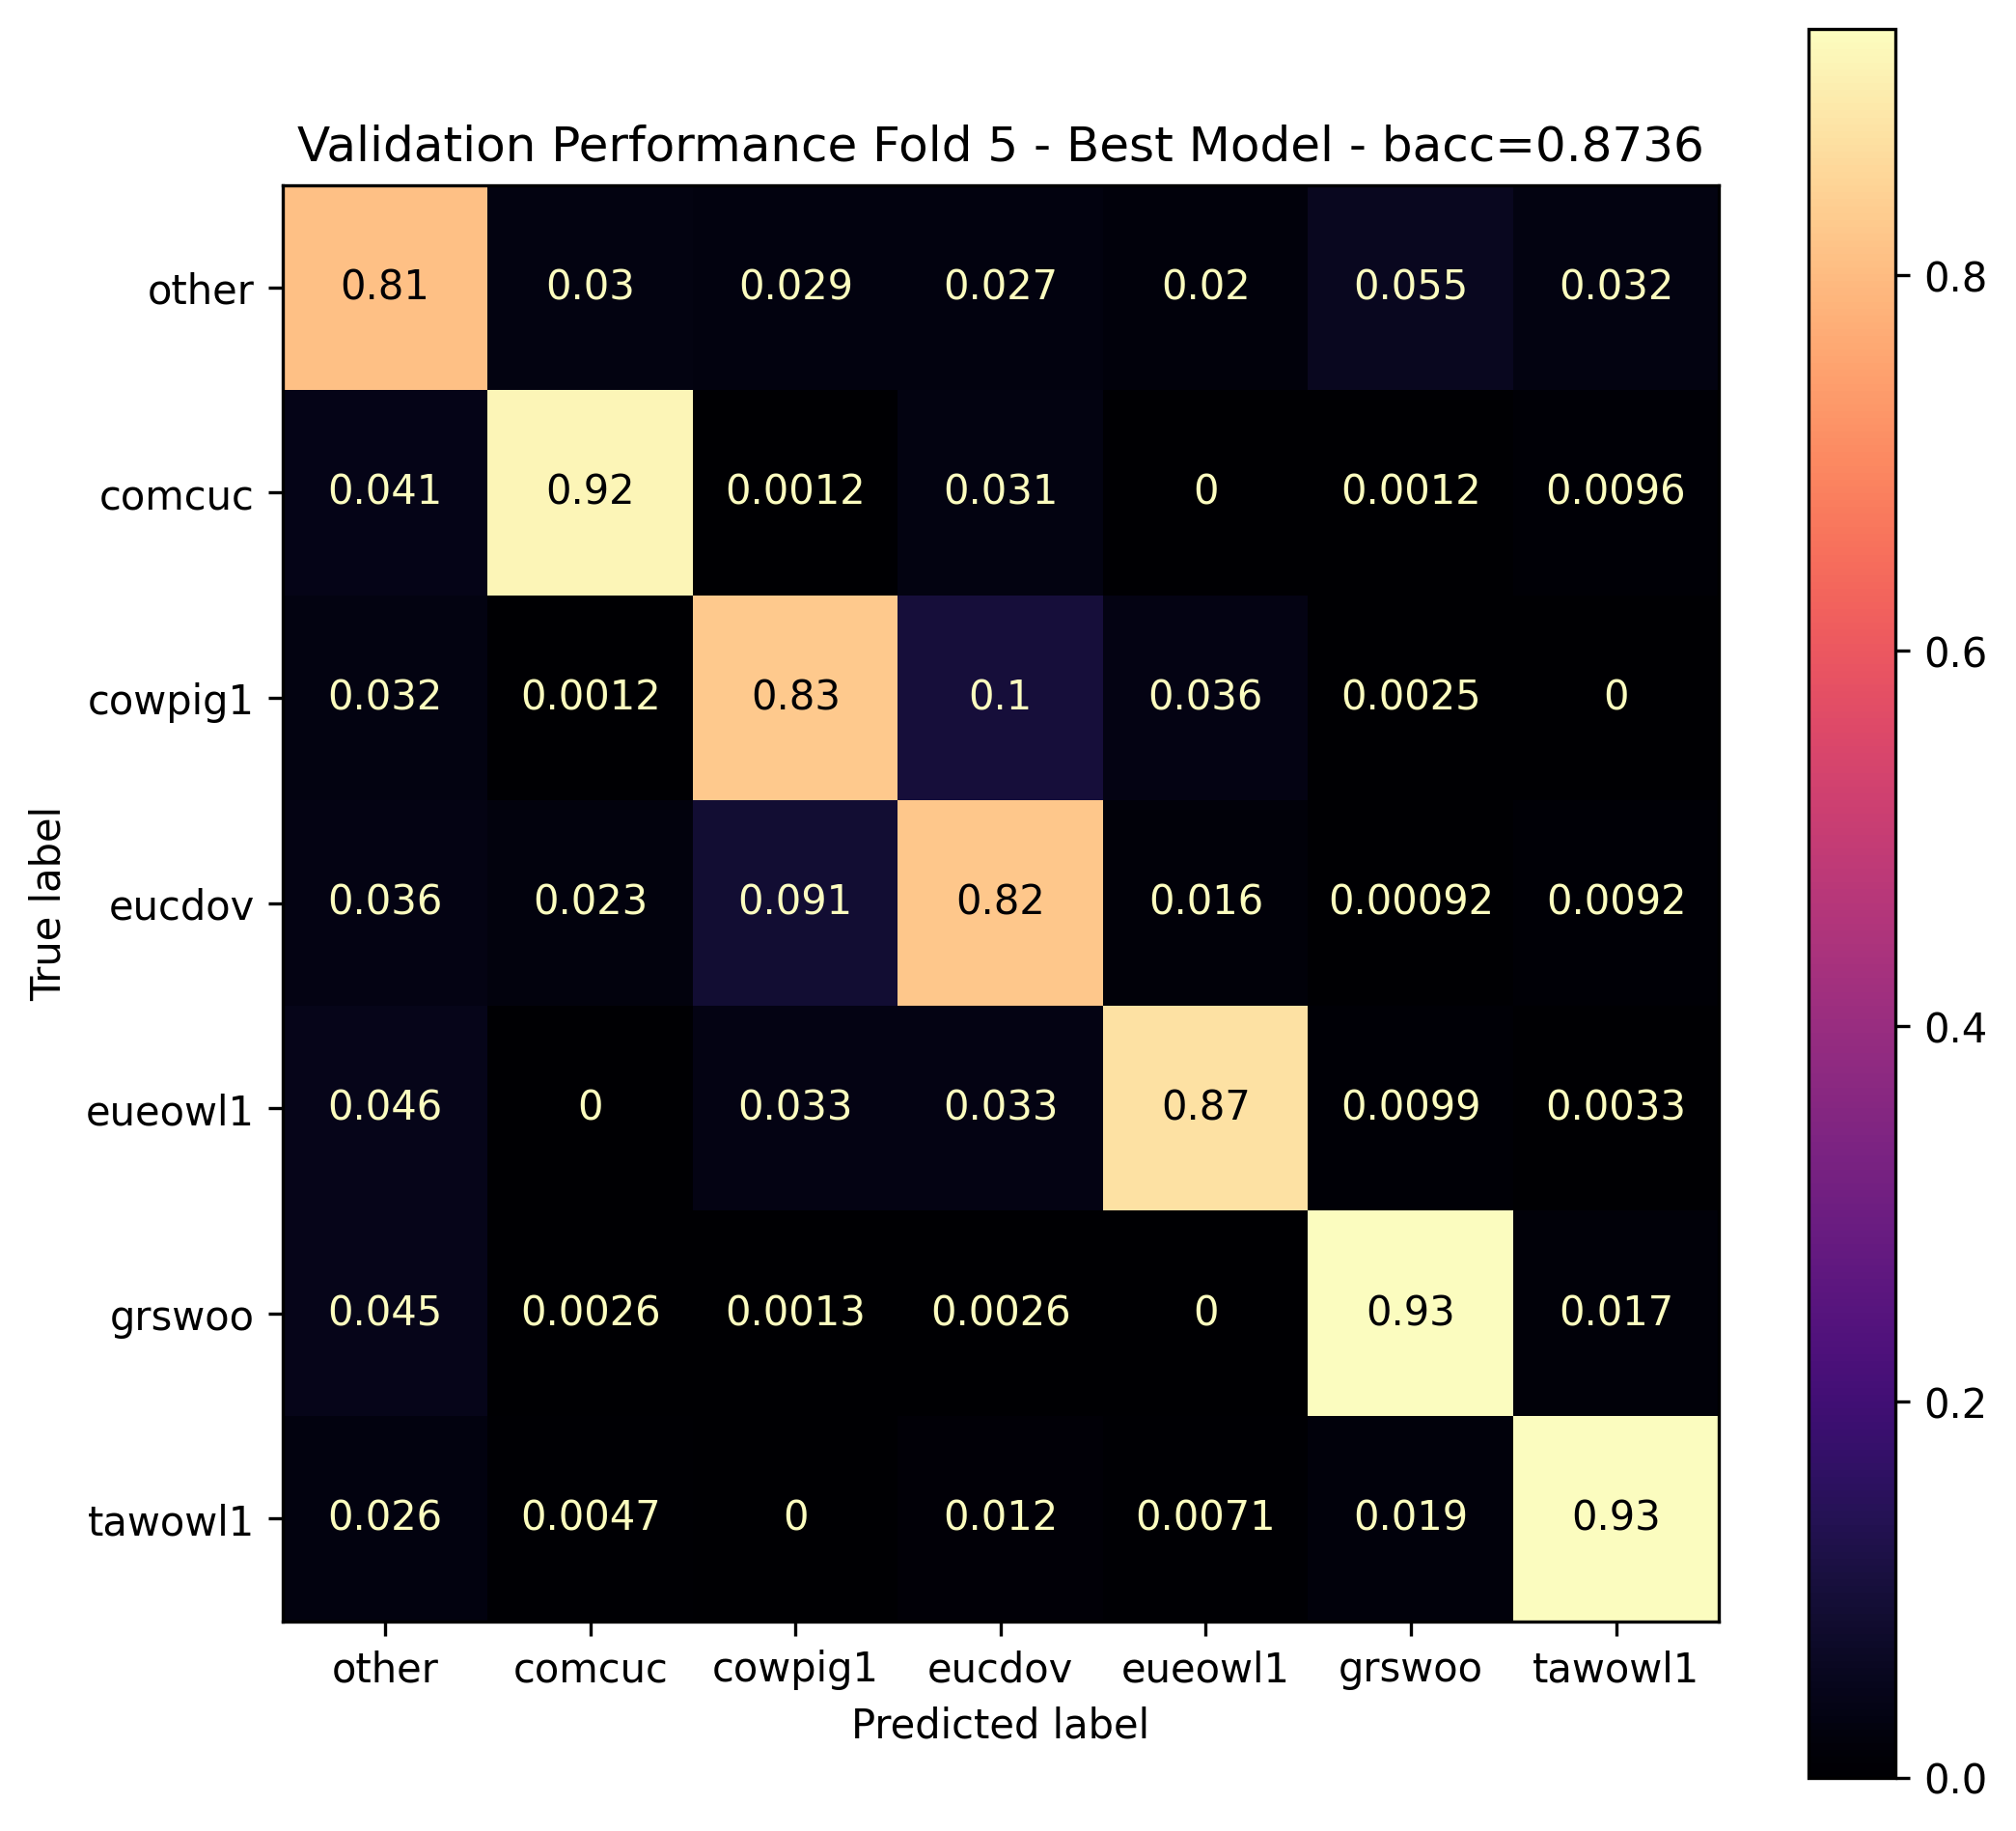

Executing CV for fold 6
Training fold 6
Training AttentionClassifier with 45635 parameters
train label counts = [74528, 5265, 7807, 7256, 1940, 4481, 3723]
loss weights = [1.0, 14.16, 9.55, 10.27, 38.42, 16.63, 20.02]
eval label counts = [10830, 568, 1147, 942, 384, 630, 499]
eval loss weights = [1.0, 19.07, 9.44, 11.5, 28.2, 17.19, 21.7]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  6325, acc = 0.060238, bacc = 0.138026
Evaluation Epoch   1/200: avg_loss = 0.000258, num_samples = 15000, num_correct =   383, acc = 0.025533, bacc = 0.141971
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  1979, acc = 0.018848, bacc = 0.142334
Evaluation Epoch   2/200: avg_loss = 0.000259, num_samples = 15000, num_correct =   463, acc = 0.030867, bacc = 0.142684
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000258, num_samples = 105000, num_correct = 11235, acc = 0.107000, bacc = 0.156333
Evaluation Epoch   3/

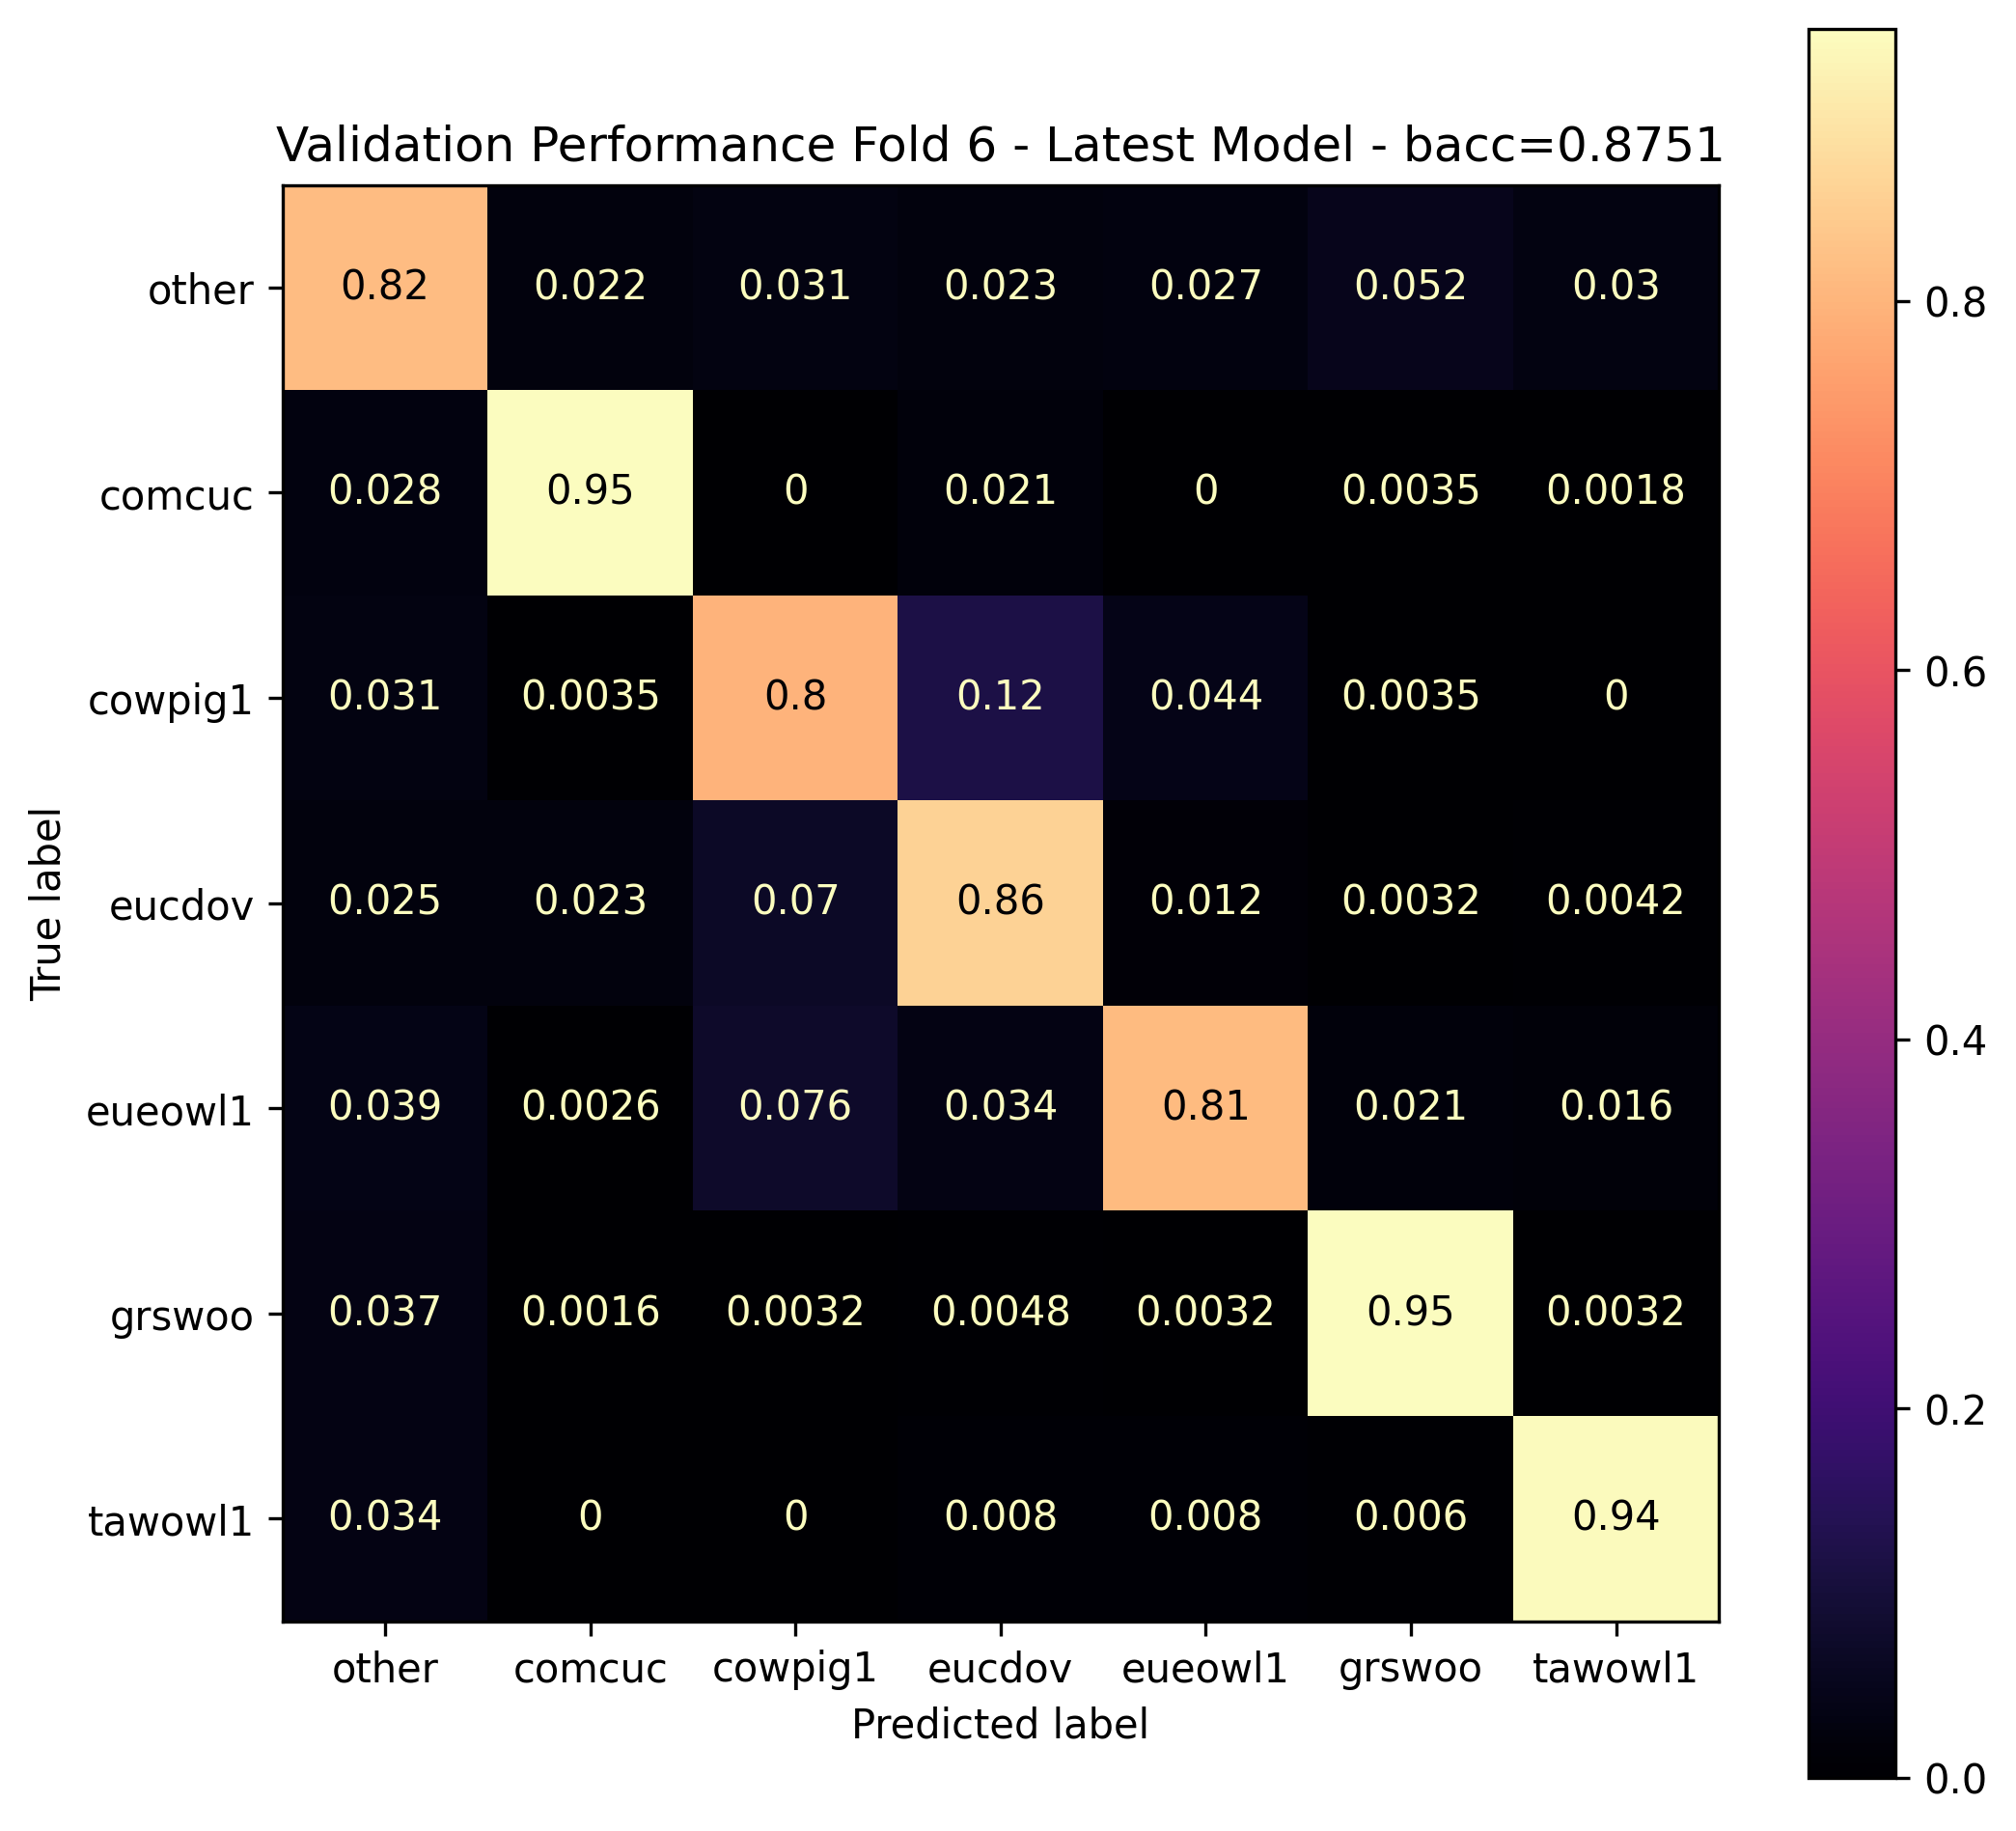

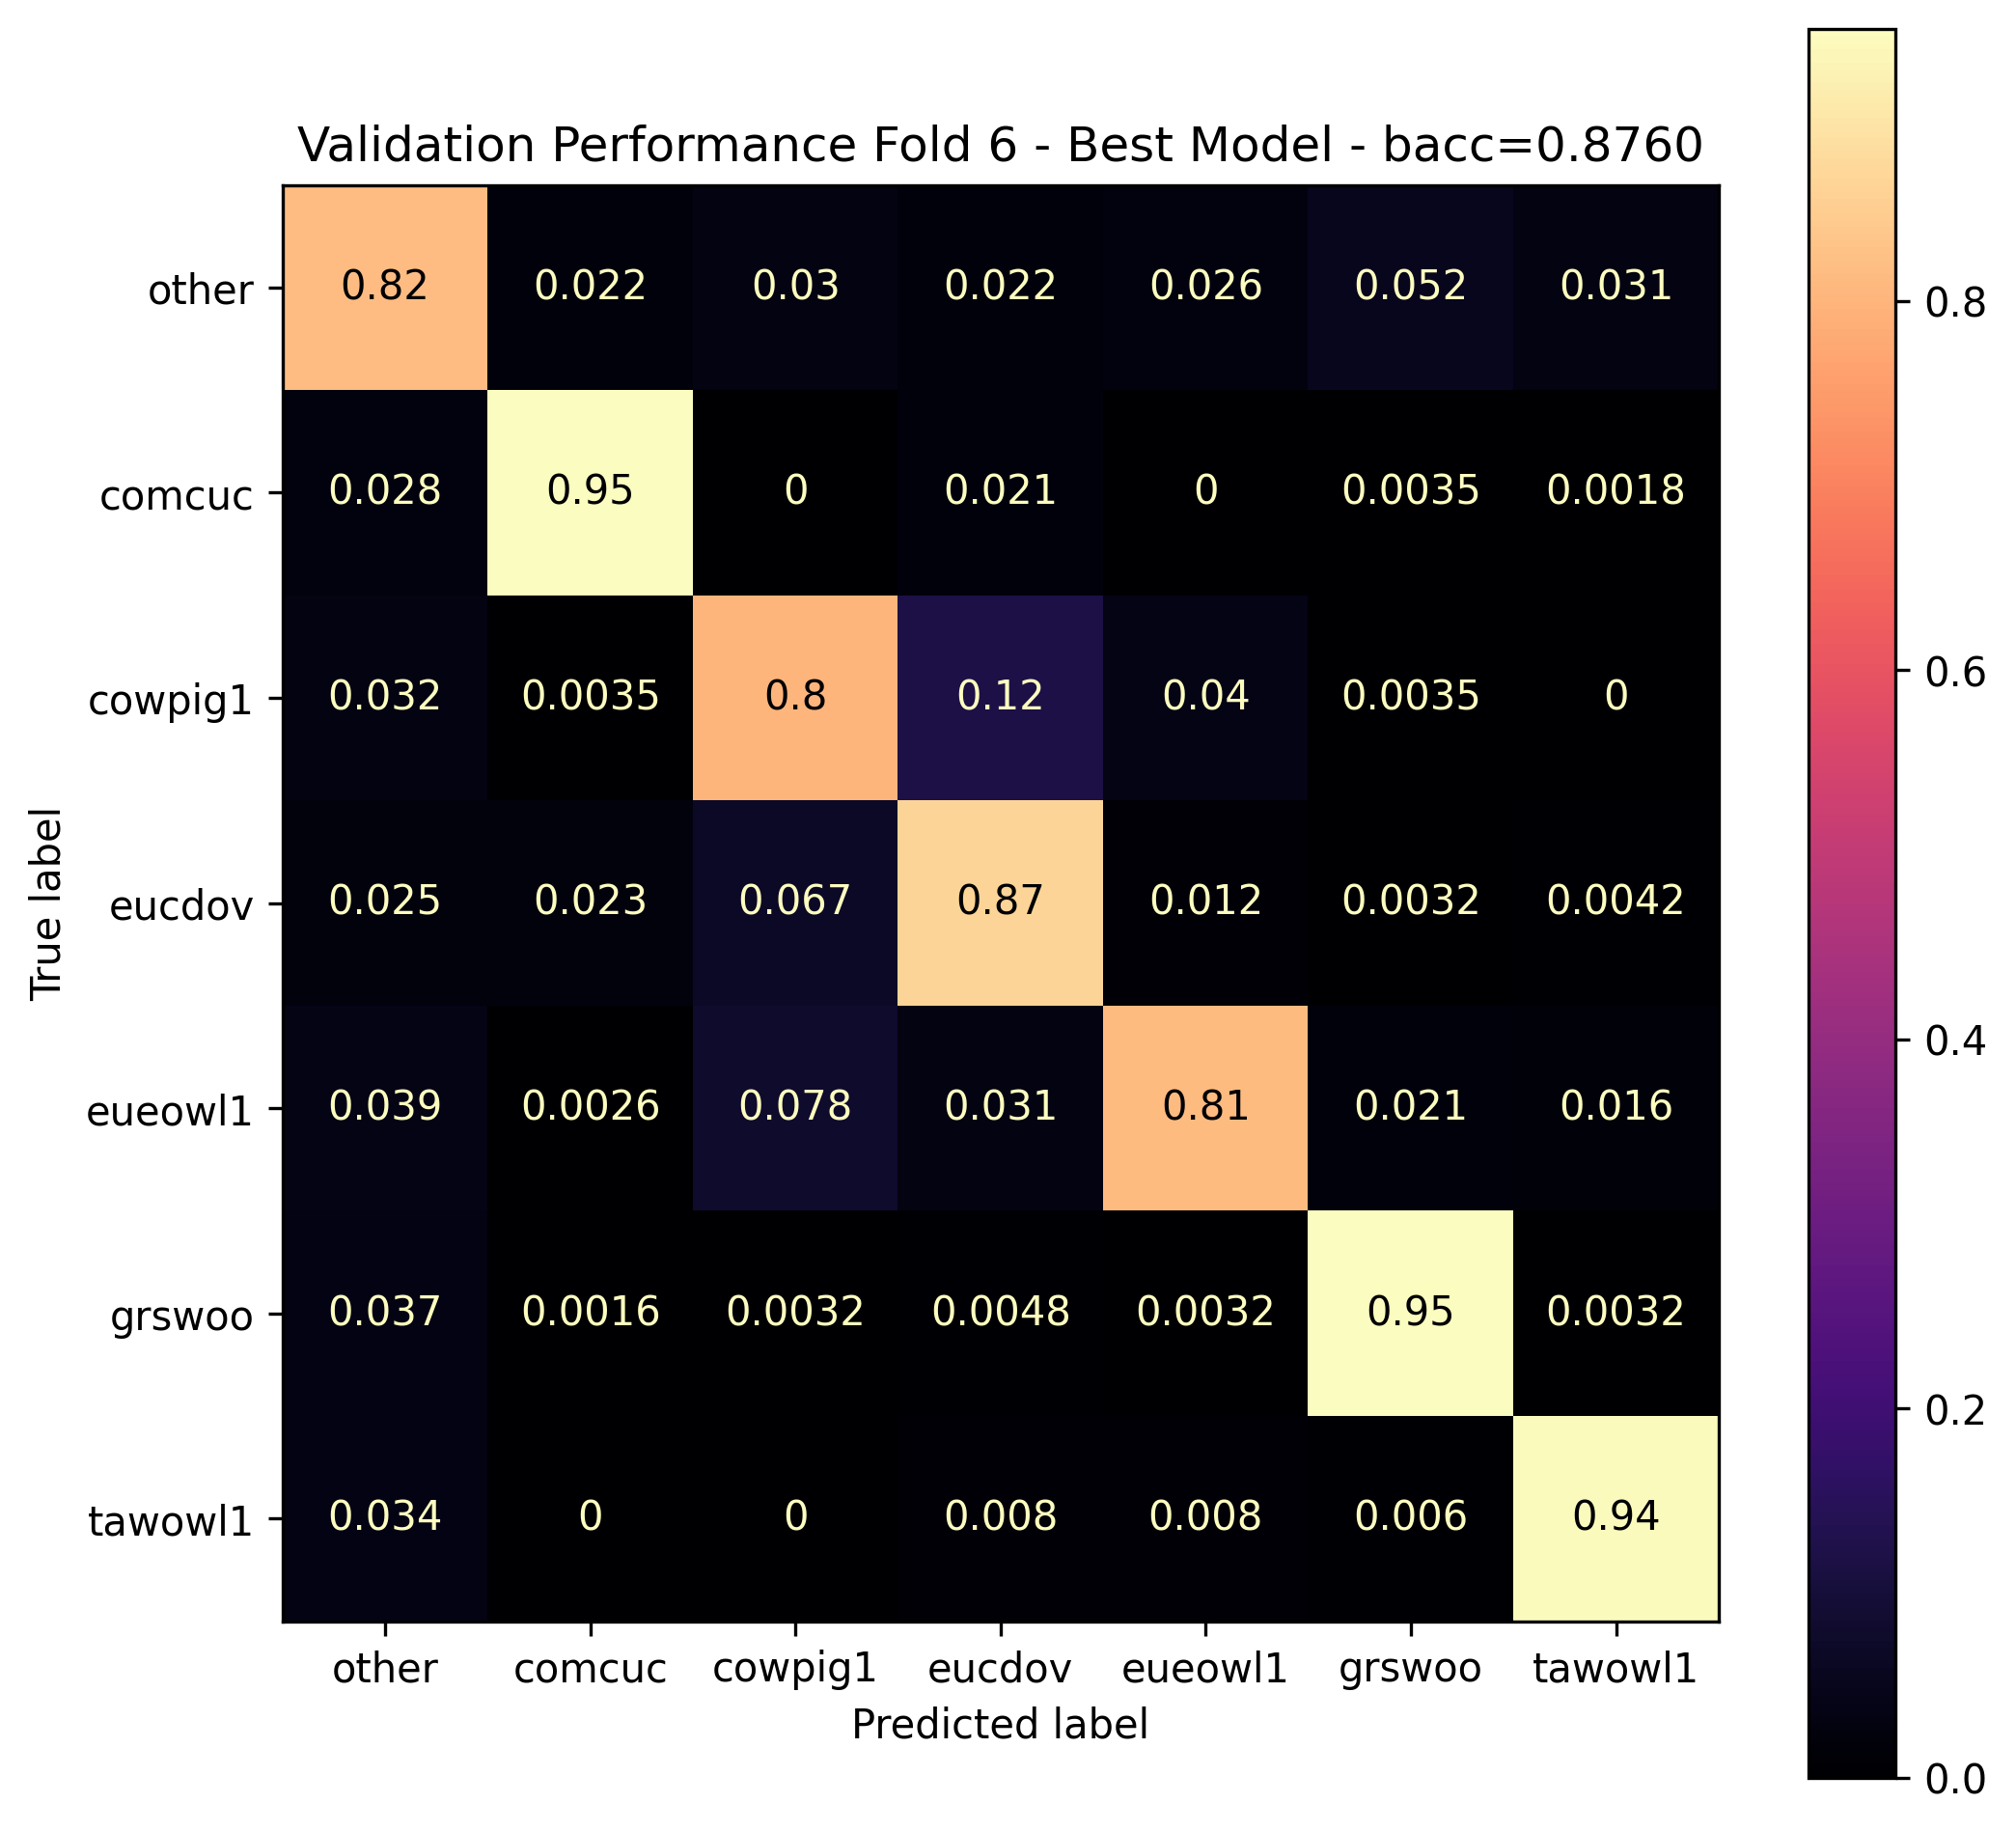

Executing CV for fold 7
Training fold 7
Training AttentionClassifier with 45635 parameters
train label counts = [74655, 4984, 8149, 7022, 2094, 4862, 3234]
loss weights = [1.0, 14.98, 9.16, 10.63, 35.65, 15.35, 23.08]
eval label counts = [10703, 849, 805, 1176, 230, 249, 988]
eval loss weights = [1.0, 12.61, 13.3, 9.1, 46.53, 42.98, 10.83]
Training Epoch   1/200: lr = 0.001, avg_loss = 0.000261, num_samples = 105000, num_correct =  5007, acc = 0.047686, bacc = 0.141655
Evaluation Epoch   1/200: avg_loss = 0.000267, num_samples = 15000, num_correct =   849, acc = 0.056600, bacc = 0.142857
Training Epoch   2/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  5561, acc = 0.052962, bacc = 0.143840
Evaluation Epoch   2/200: avg_loss = 0.000267, num_samples = 15000, num_correct =  1095, acc = 0.073000, bacc = 0.142187
Training Epoch   3/200: lr = 0.001, avg_loss = 0.000260, num_samples = 105000, num_correct =  6656, acc = 0.063390, bacc = 0.141629
Evaluation Epoch   3

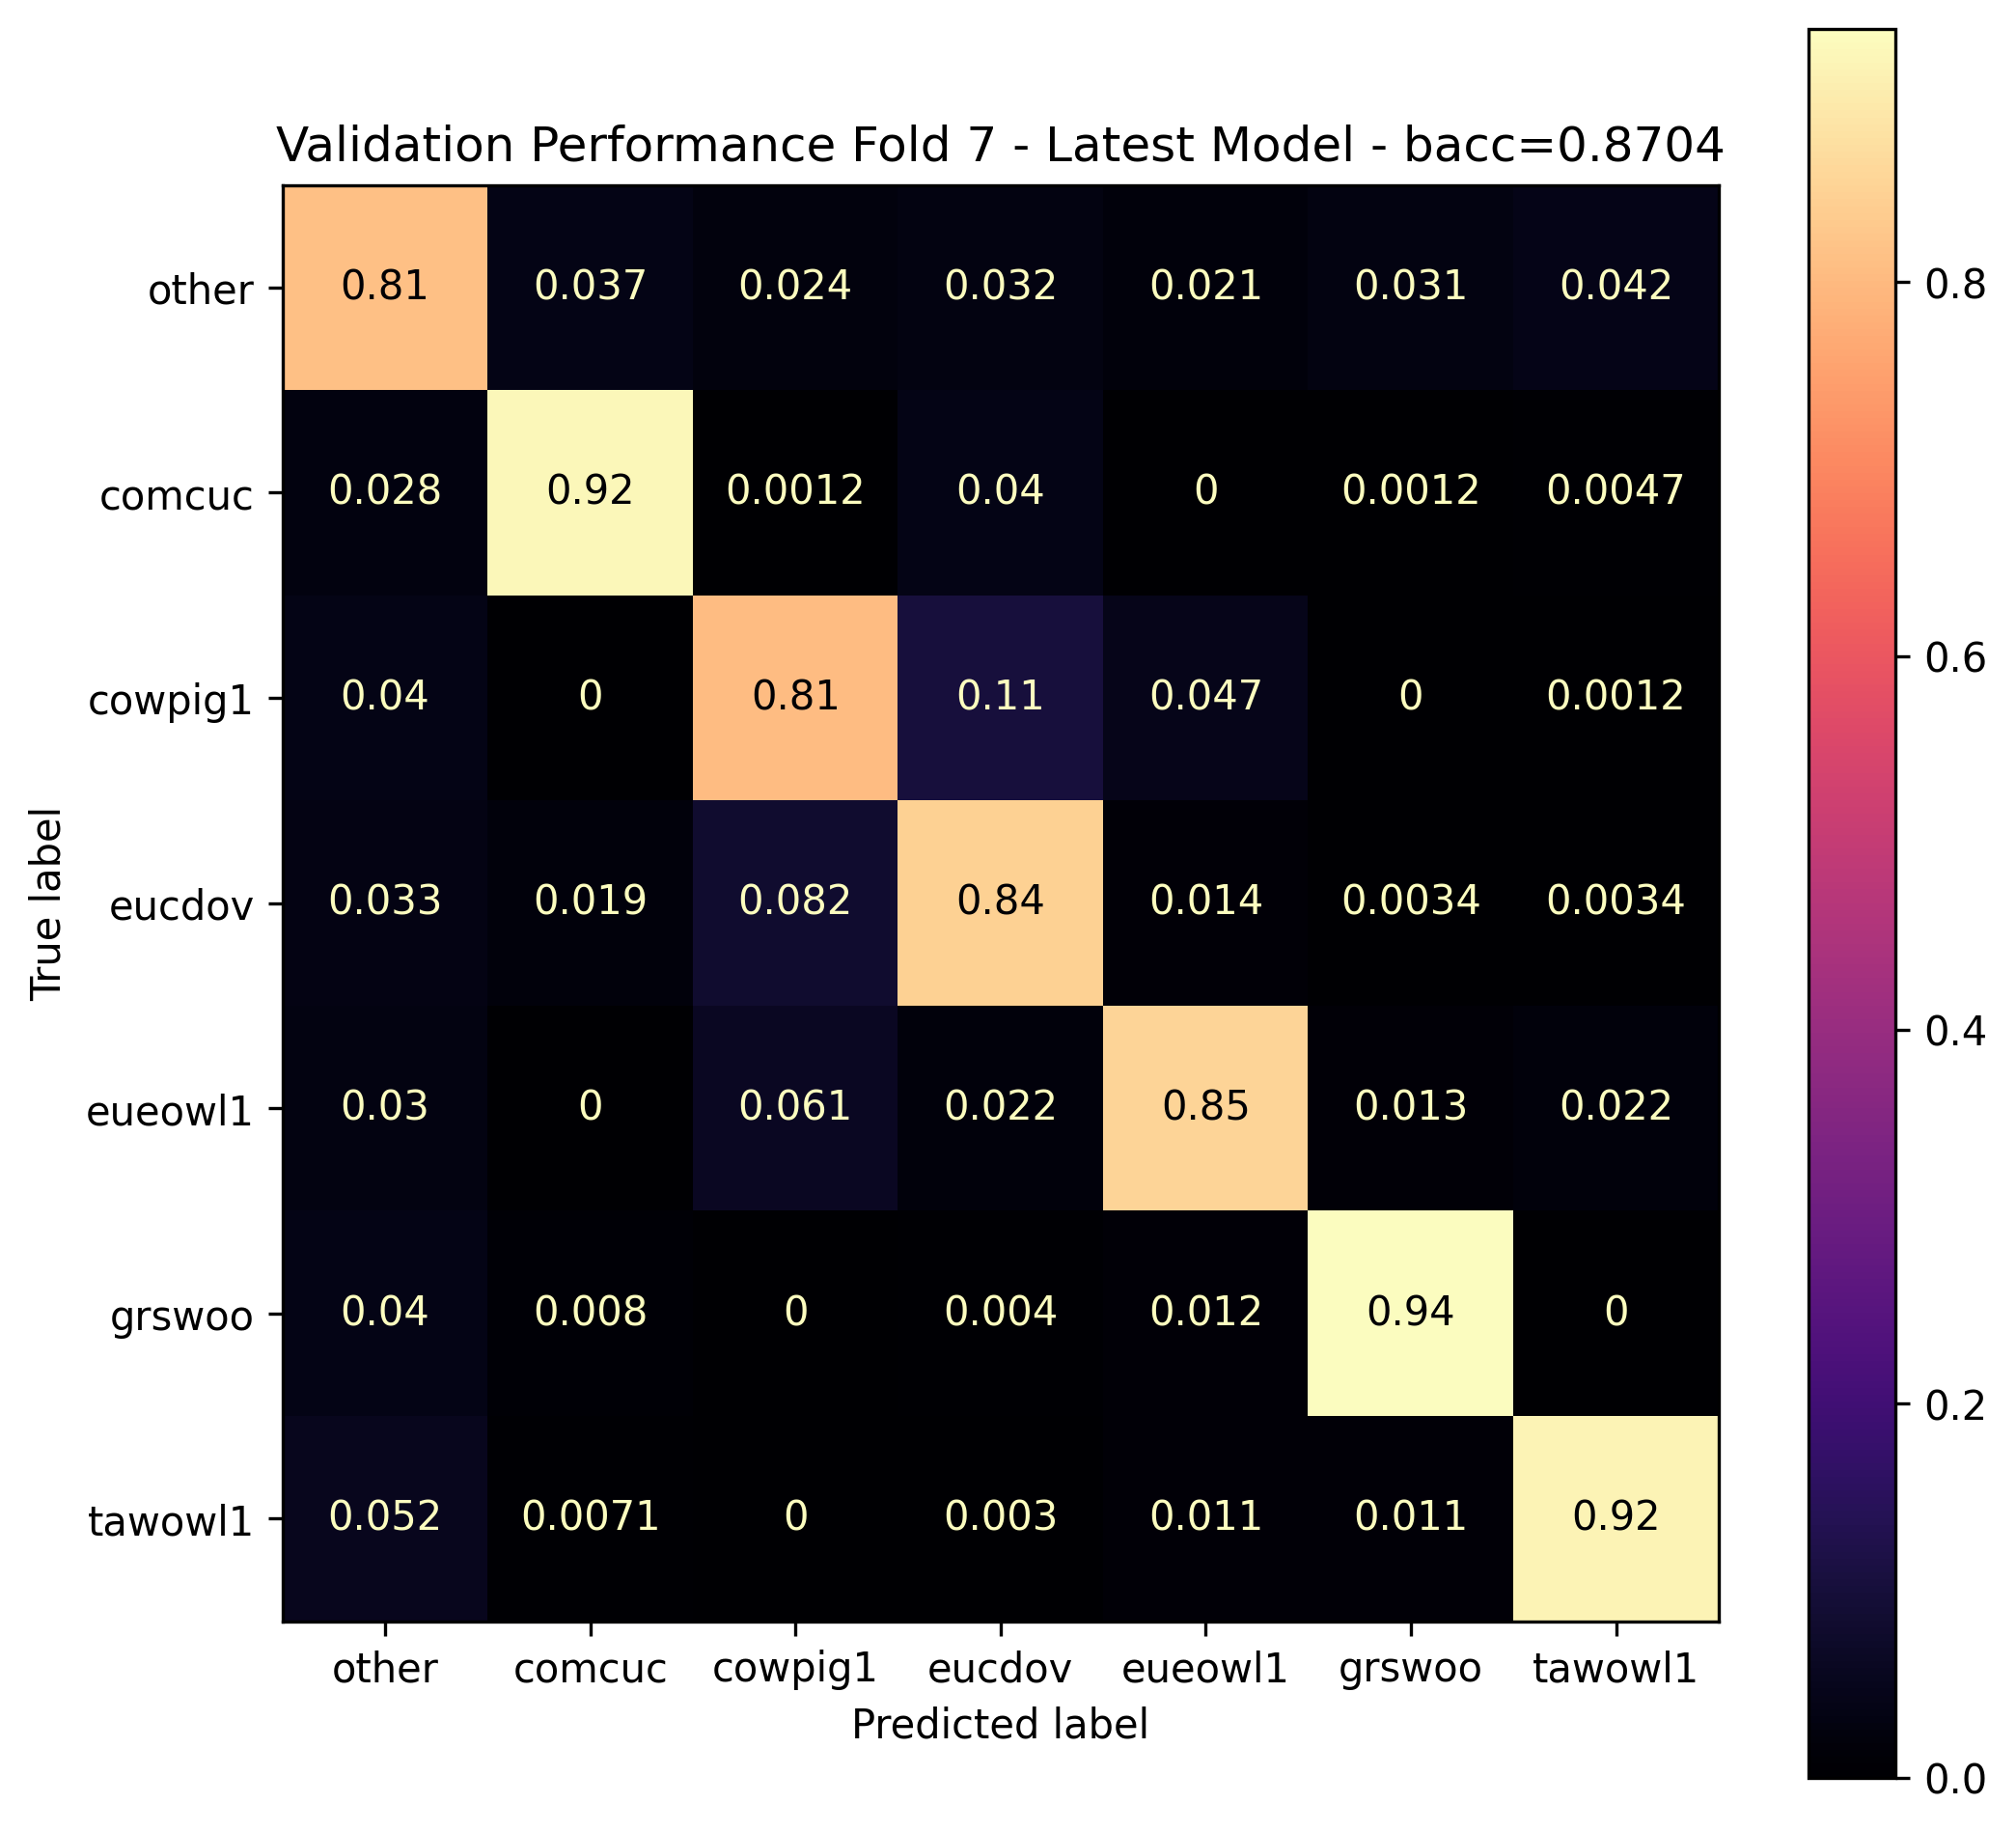

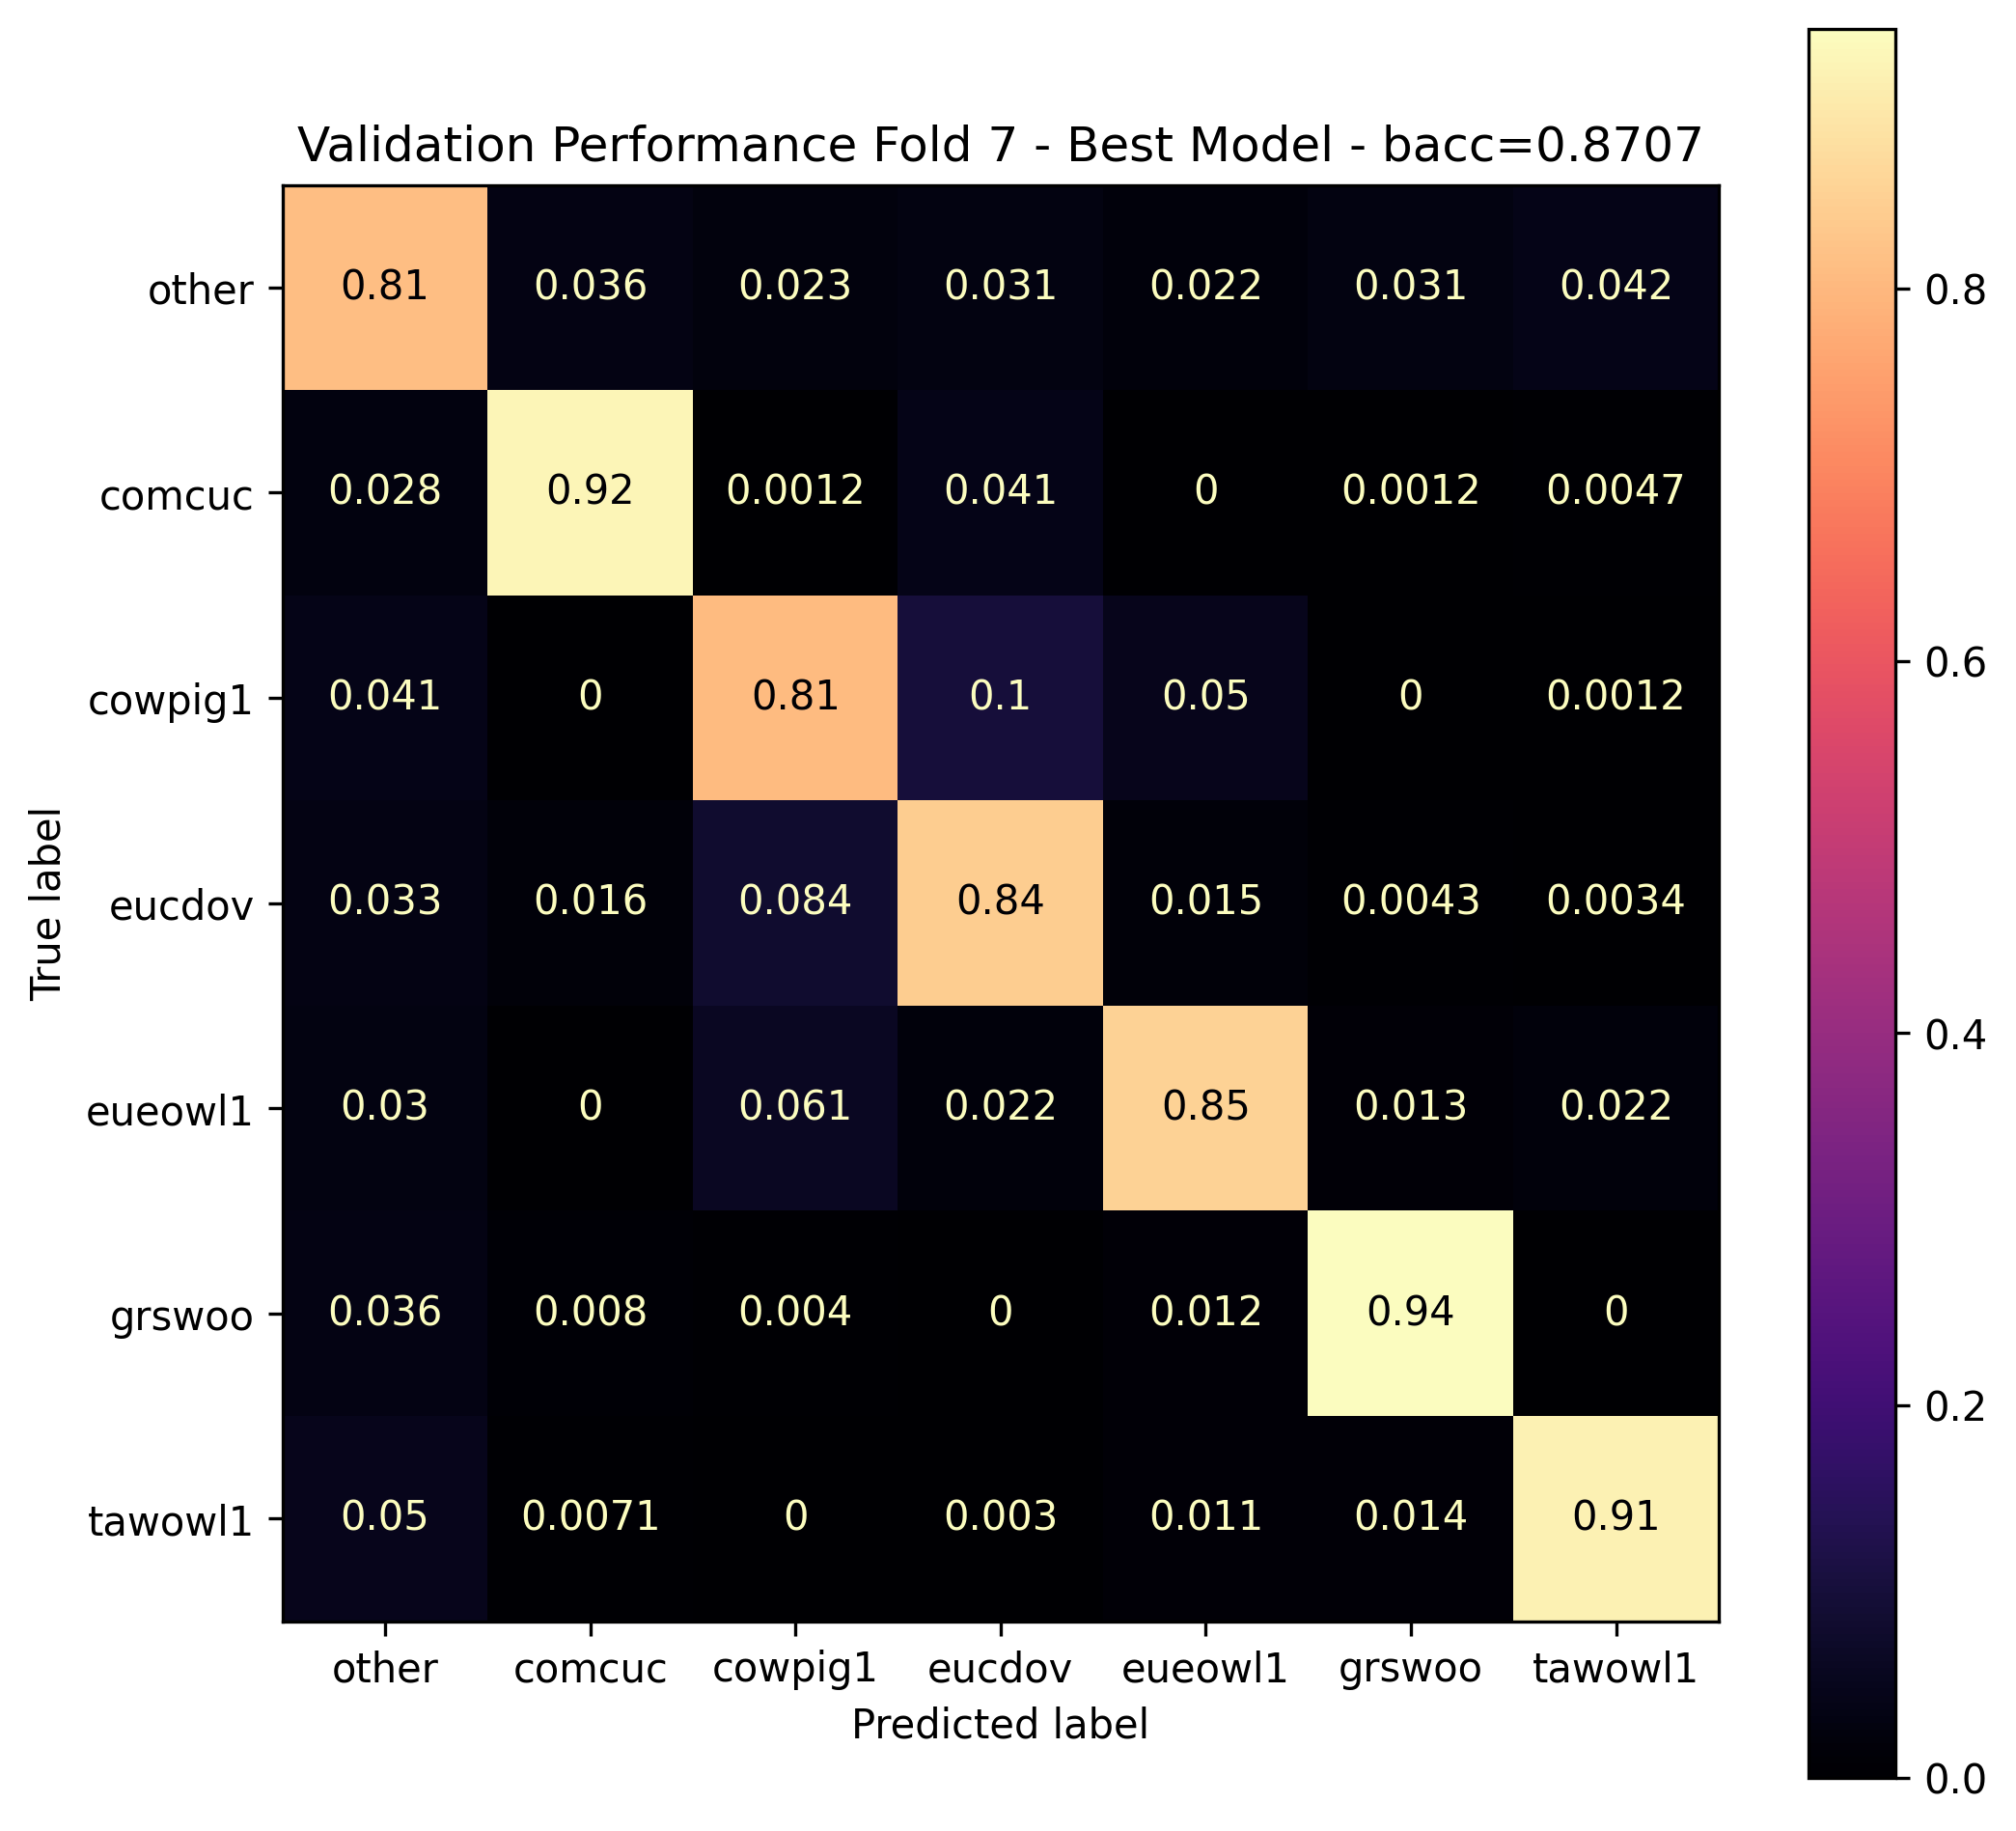

cv_final_epoch_avg_train_metrics      = avg_loss = 0.000037, num_samples = 105000.000000, num_correct = 88085.250000, acc = 0.838907, bacc = 0.910481
cv_final_epoch_avg_evaluation_metrics = avg_loss = 0.000072, num_samples = 15000.000000, num_correct = 12377.750000, acc = 0.825183, bacc = 0.871740


In [66]:
set_random_seed(43)

cv_training_hyper_parameters = create_training_hyper_parameters(
    epoch_multiplier=2, 
    lr_multiplier=0.1
)

cv_models_with_scalers, cv_folds_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    combined_ds,
    8,
    device,
    # cv_folds_permute_seed=42,
    save_models=None
)


## Metrics ##

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_evaluation_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics      = }')
print(f'{cv_final_epoch_avg_evaluation_metrics = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

## Final Train/Test

Training AttentionClassifier with 50643 parameters
train label counts = [68467, 4469, 7319, 6567, 1876, 3817, 3485]
loss weights = [1.0, 15.32, 9.35, 10.43, 36.5, 17.94, 19.65]
eval label counts = [16891, 1364, 1635, 1631, 448, 1294, 737]
eval loss weights = [1.0, 12.38, 10.33, 10.36, 37.7, 13.05, 22.92]
Training Epoch   1/80 : lr = 0.0075, avg_loss = 0.000643, num_samples = 96000, num_correct = 19584, acc = 0.204000, bacc = 0.233113
Evaluation Epoch   1/80 : avg_loss = 0.000605, num_samples = 24000, num_correct =  5383, acc = 0.224292, bacc = 0.176625
Training Epoch   2/80 : lr = 0.0075, avg_loss = 0.000734, num_samples = 96000, num_correct =  9575, acc = 0.099740, bacc = 0.221090
Evaluation Epoch   2/80 : avg_loss = 0.000788, num_samples = 24000, num_correct =   751, acc = 0.031292, bacc = 0.139563
Training Epoch   3/80 : lr = 0.0075, avg_loss = 0.000700, num_samples = 96000, num_correct =  3805, acc = 0.039635, bacc = 0.114401
Evaluation Epoch   3/80 : avg_loss = 0.000742, num_sampl

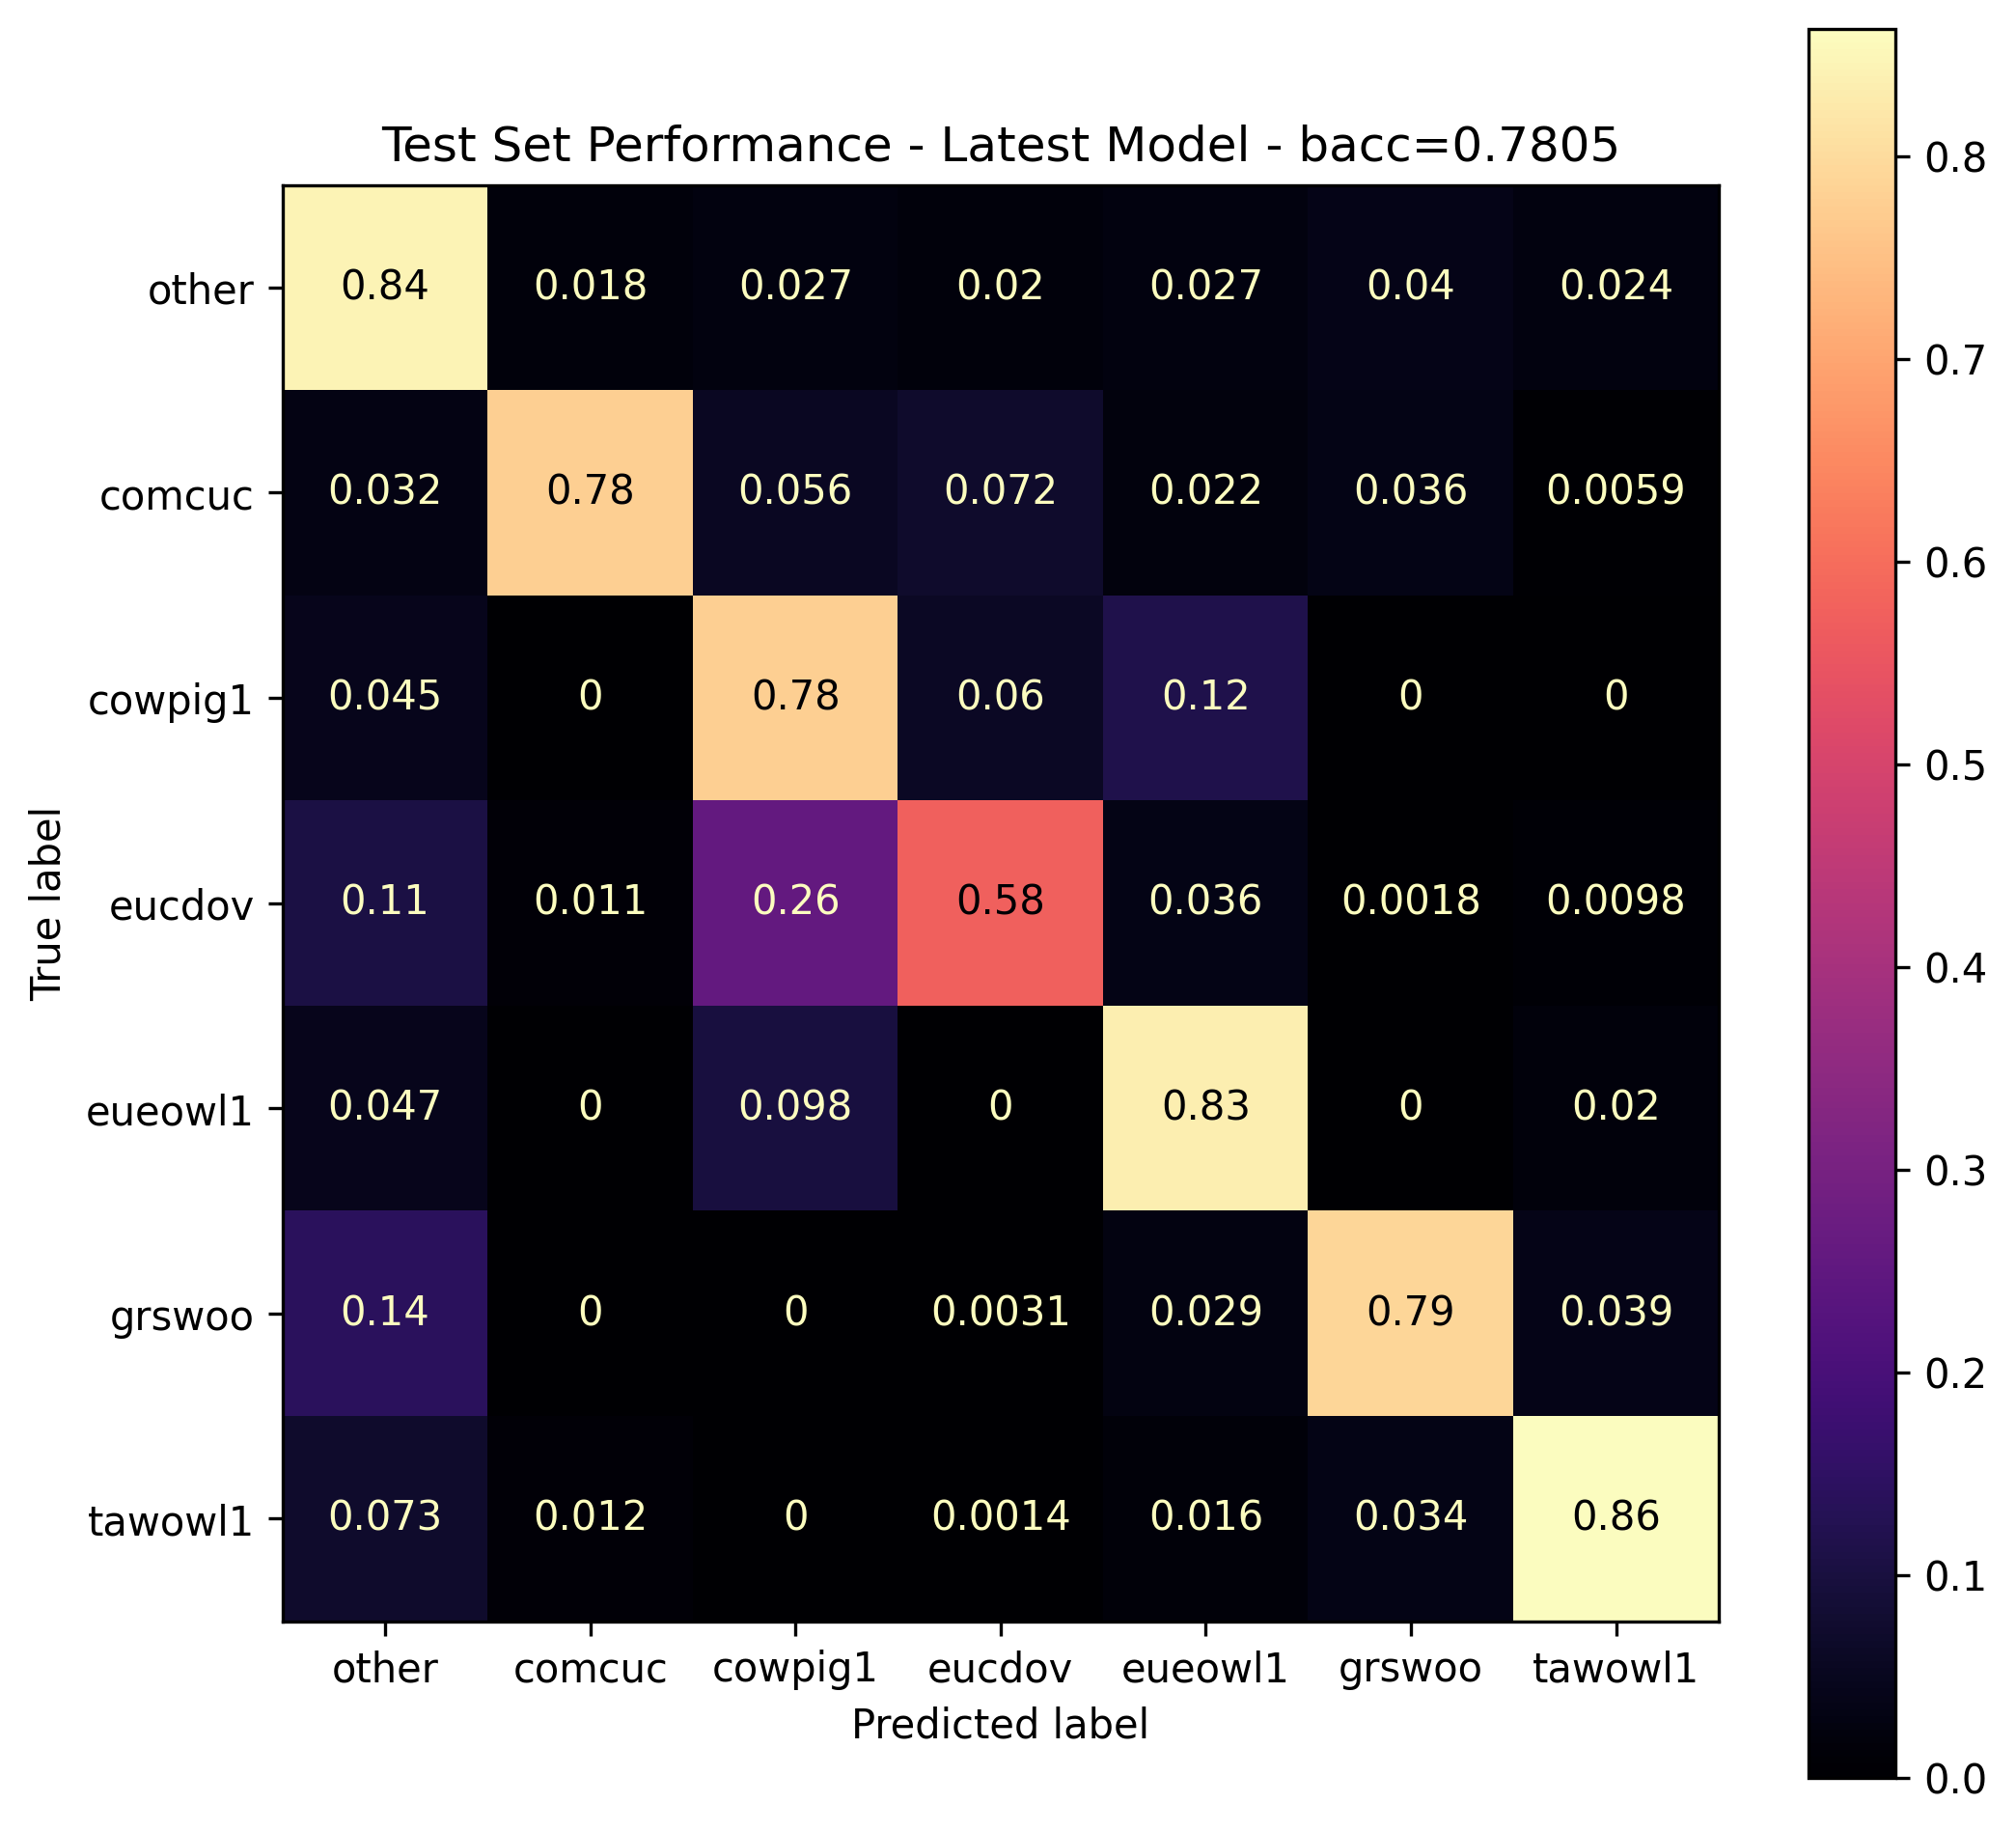

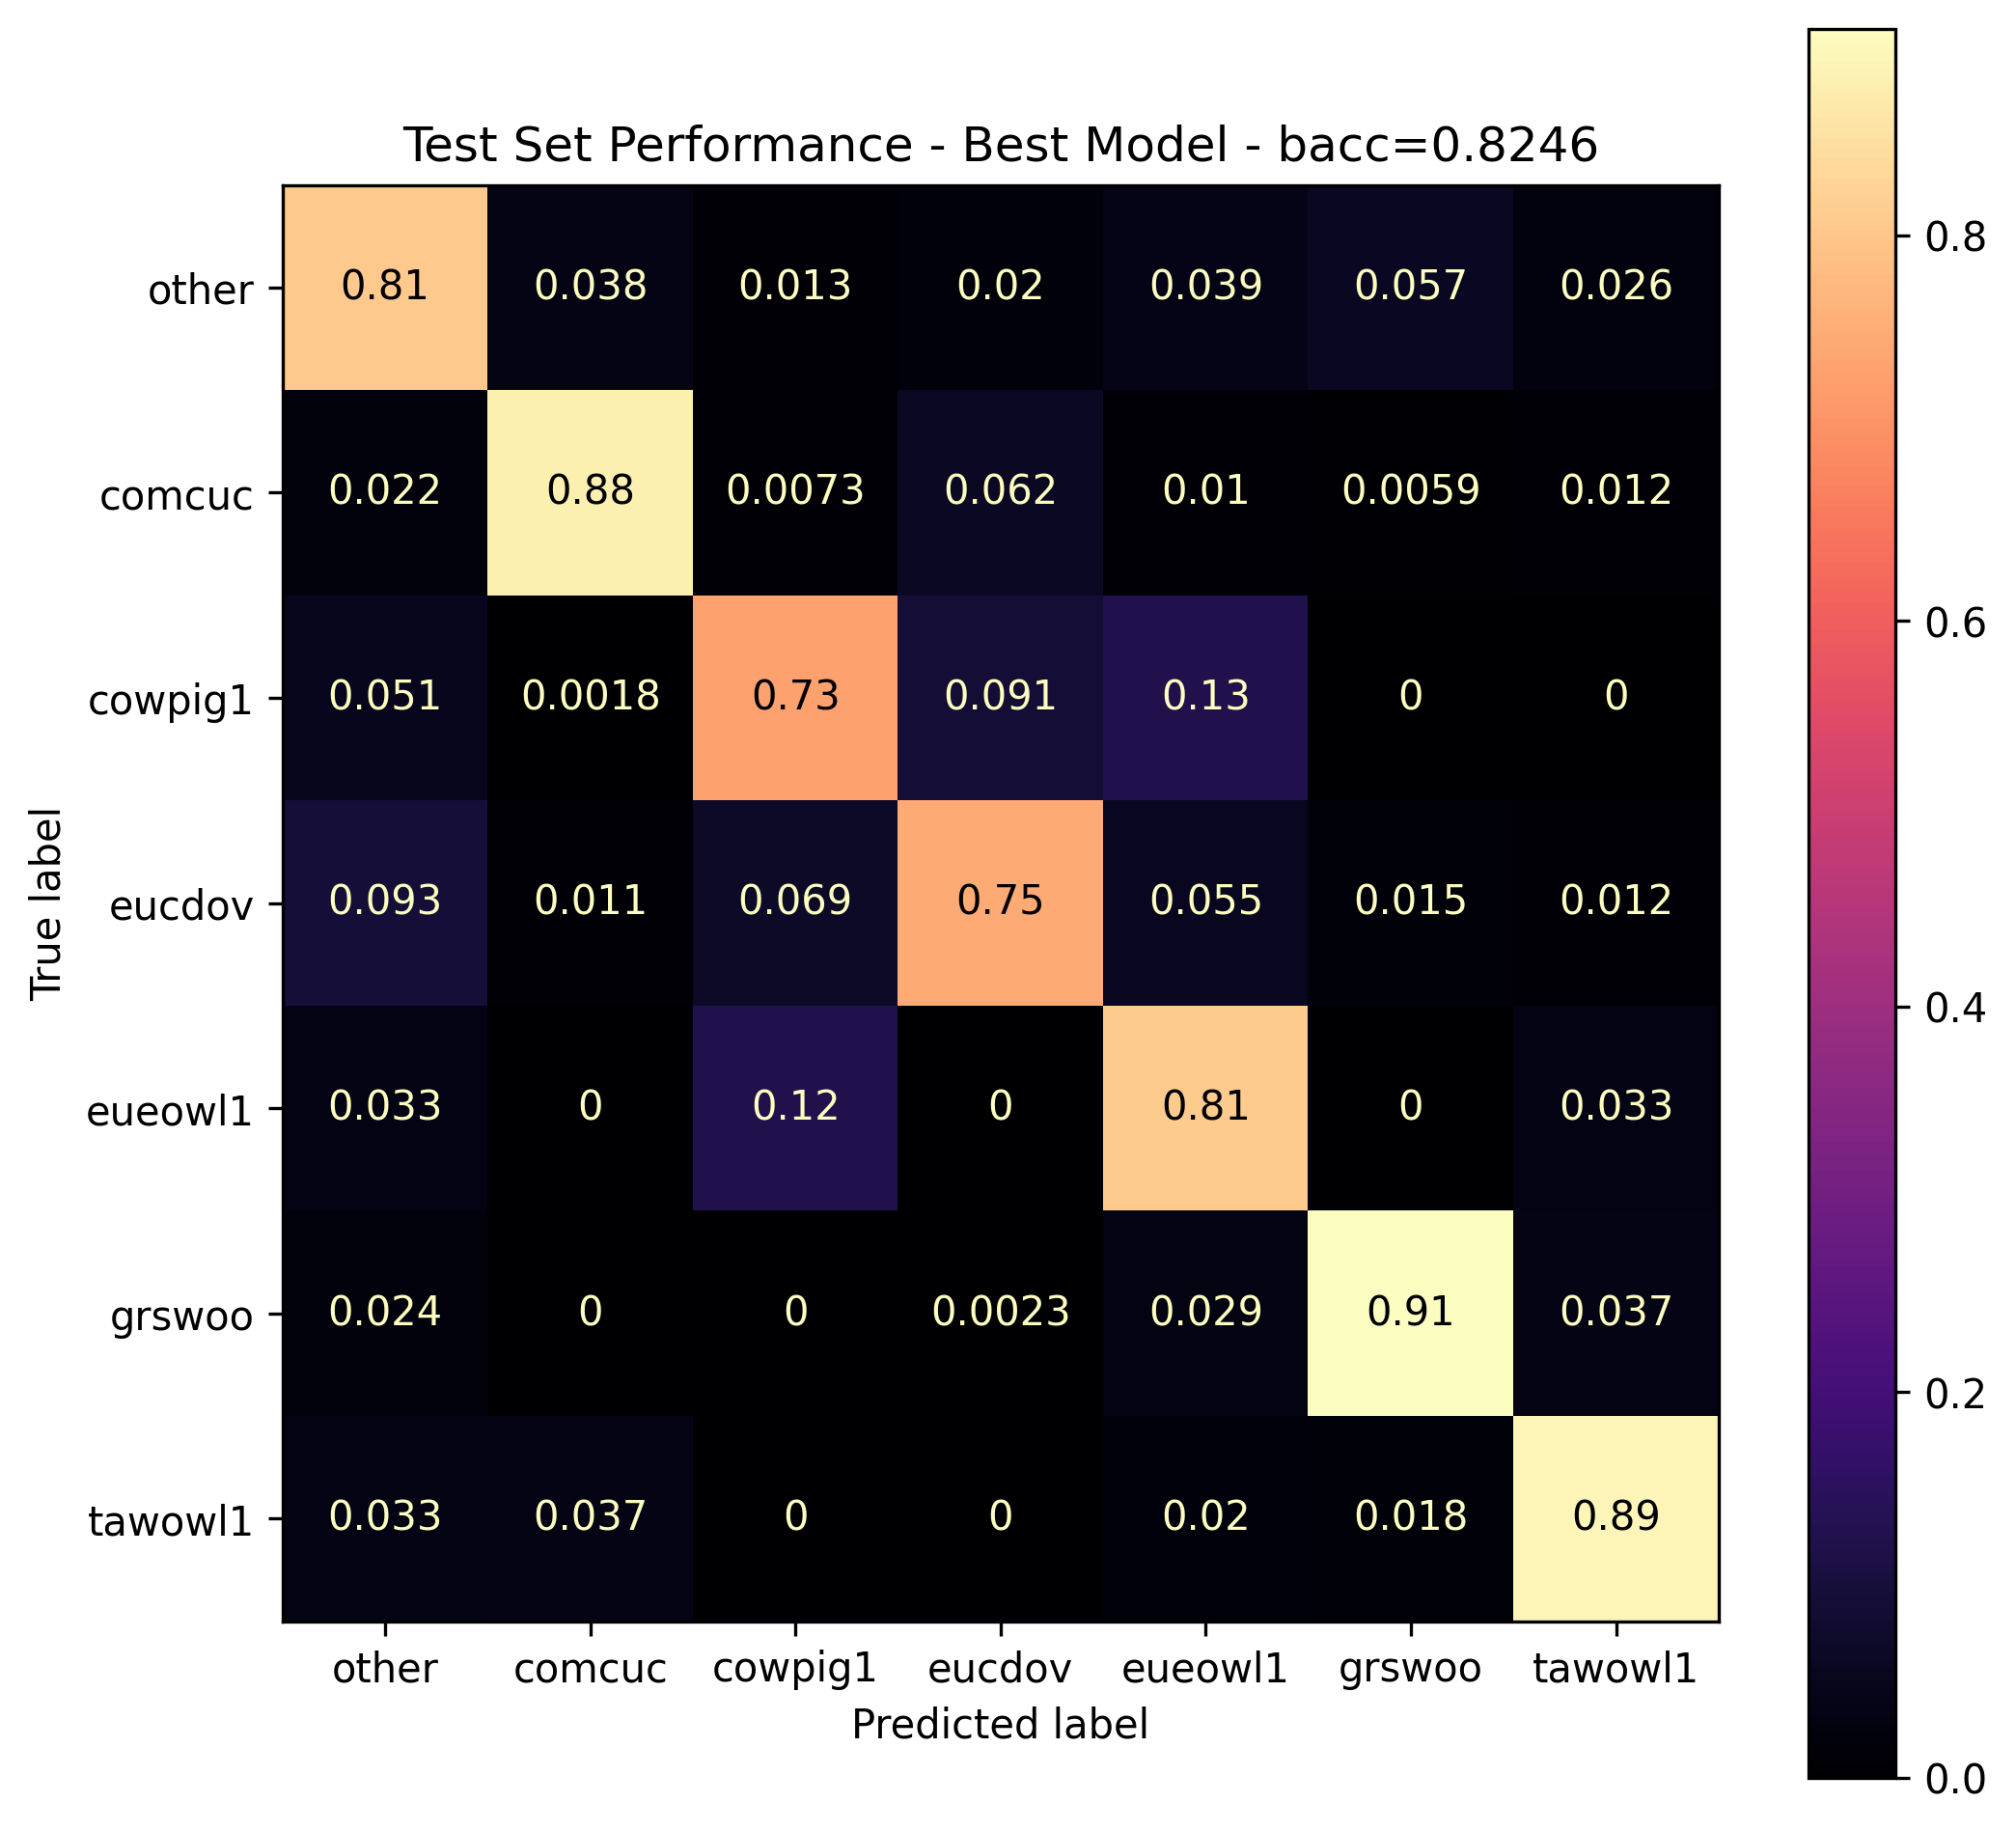

training_run_metrics[-1][0] = avg_loss = 0.000030, num_samples = 96000, num_correct = 86278, acc = 0.898729, bacc = 0.969797
test_metrics_latest_model   = avg_loss = 0.000264, num_samples = 24000, num_correct = 19575, acc = 0.815625, bacc = 0.780541
test_metrics_best_model     = avg_loss = 0.000219, num_samples = 24000, num_correct = 19426, acc = 0.809417, bacc = 0.824582


In [58]:
set_random_seed(42)

final_training_hyper_parameters = create_training_hyper_parameters(
    epoch_multiplier=0.8, 
    lr_multiplier=0.55
)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

latest_attention_classifier, training_run_metrics, best_attention_classifier, best_metrics = train_attention_classifier(
    hyper_parameters, 
    final_training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    NumpyDataset(data_test_normalized, labels_test),
    device
)

test_loader = create_data_loader(data_test_normalized, labels_test)

test_metrics_latest_model = evaluate_attention_classifier(
    latest_attention_classifier, 
    test_loader, 
    device, 
    show_confmat=True,
    confmat_title=f'Test Set Performance - Latest Model'
)
test_metrics_best_model = evaluate_attention_classifier(
    best_attention_classifier, 
    test_loader, 
    device, 
    show_confmat=True,
    confmat_title=f'Test Set Performance - Best Model'
)

print(f'{training_run_metrics[-1][0] = }')
print(f'{test_metrics_latest_model   = }')
print(f'{test_metrics_best_model     = }')

# Plots

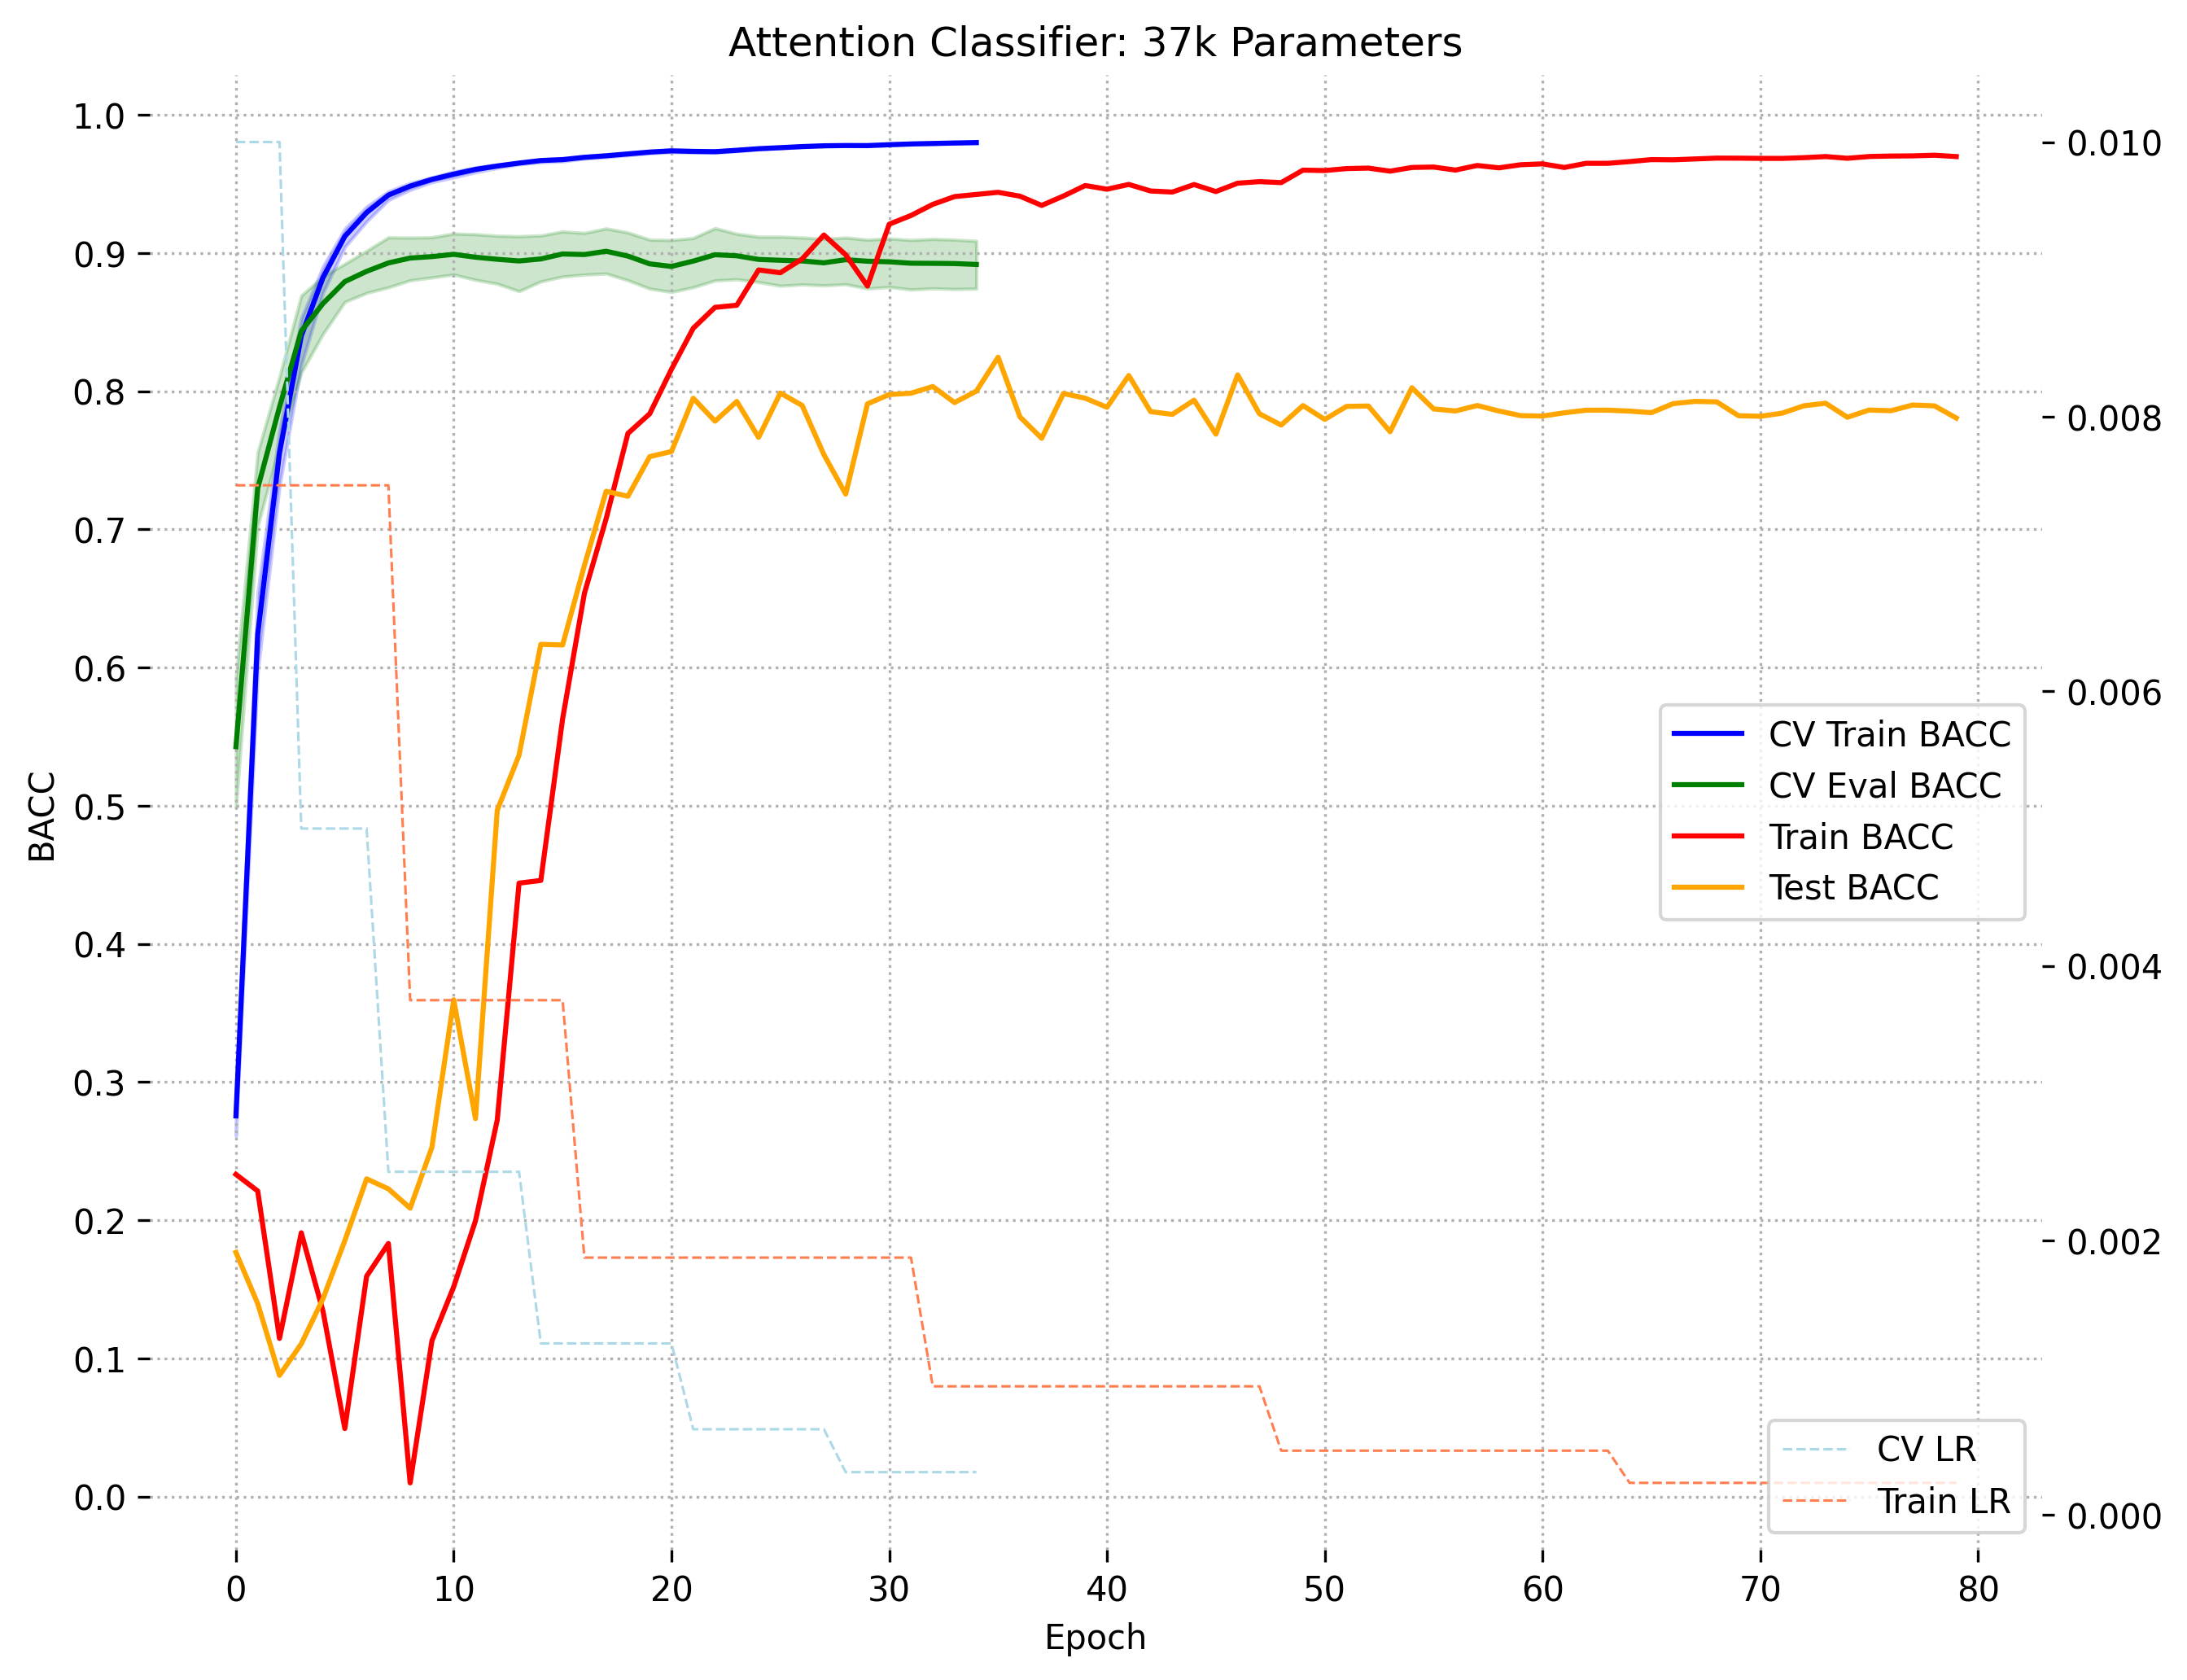

In [59]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    final_train_epoch_range = np.arange(0, final_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])

    ax.plot(final_train_epoch_range, list(map(lambda m: m[0].bacc, training_run_metrics)), label='Train BACC', c='red')
    ax.plot(final_train_epoch_range, list(map(lambda m: m[1].bacc, training_run_metrics)), label='Test BACC', c='orange')
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)
    twin_ax.plot(final_train_epoch_range, create_lrs_over_epochs(final_training_hyper_parameters), label='Train LR', c='coral', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

plot_baccs_over_epochs('Attention Classifier: 37k Parameters')

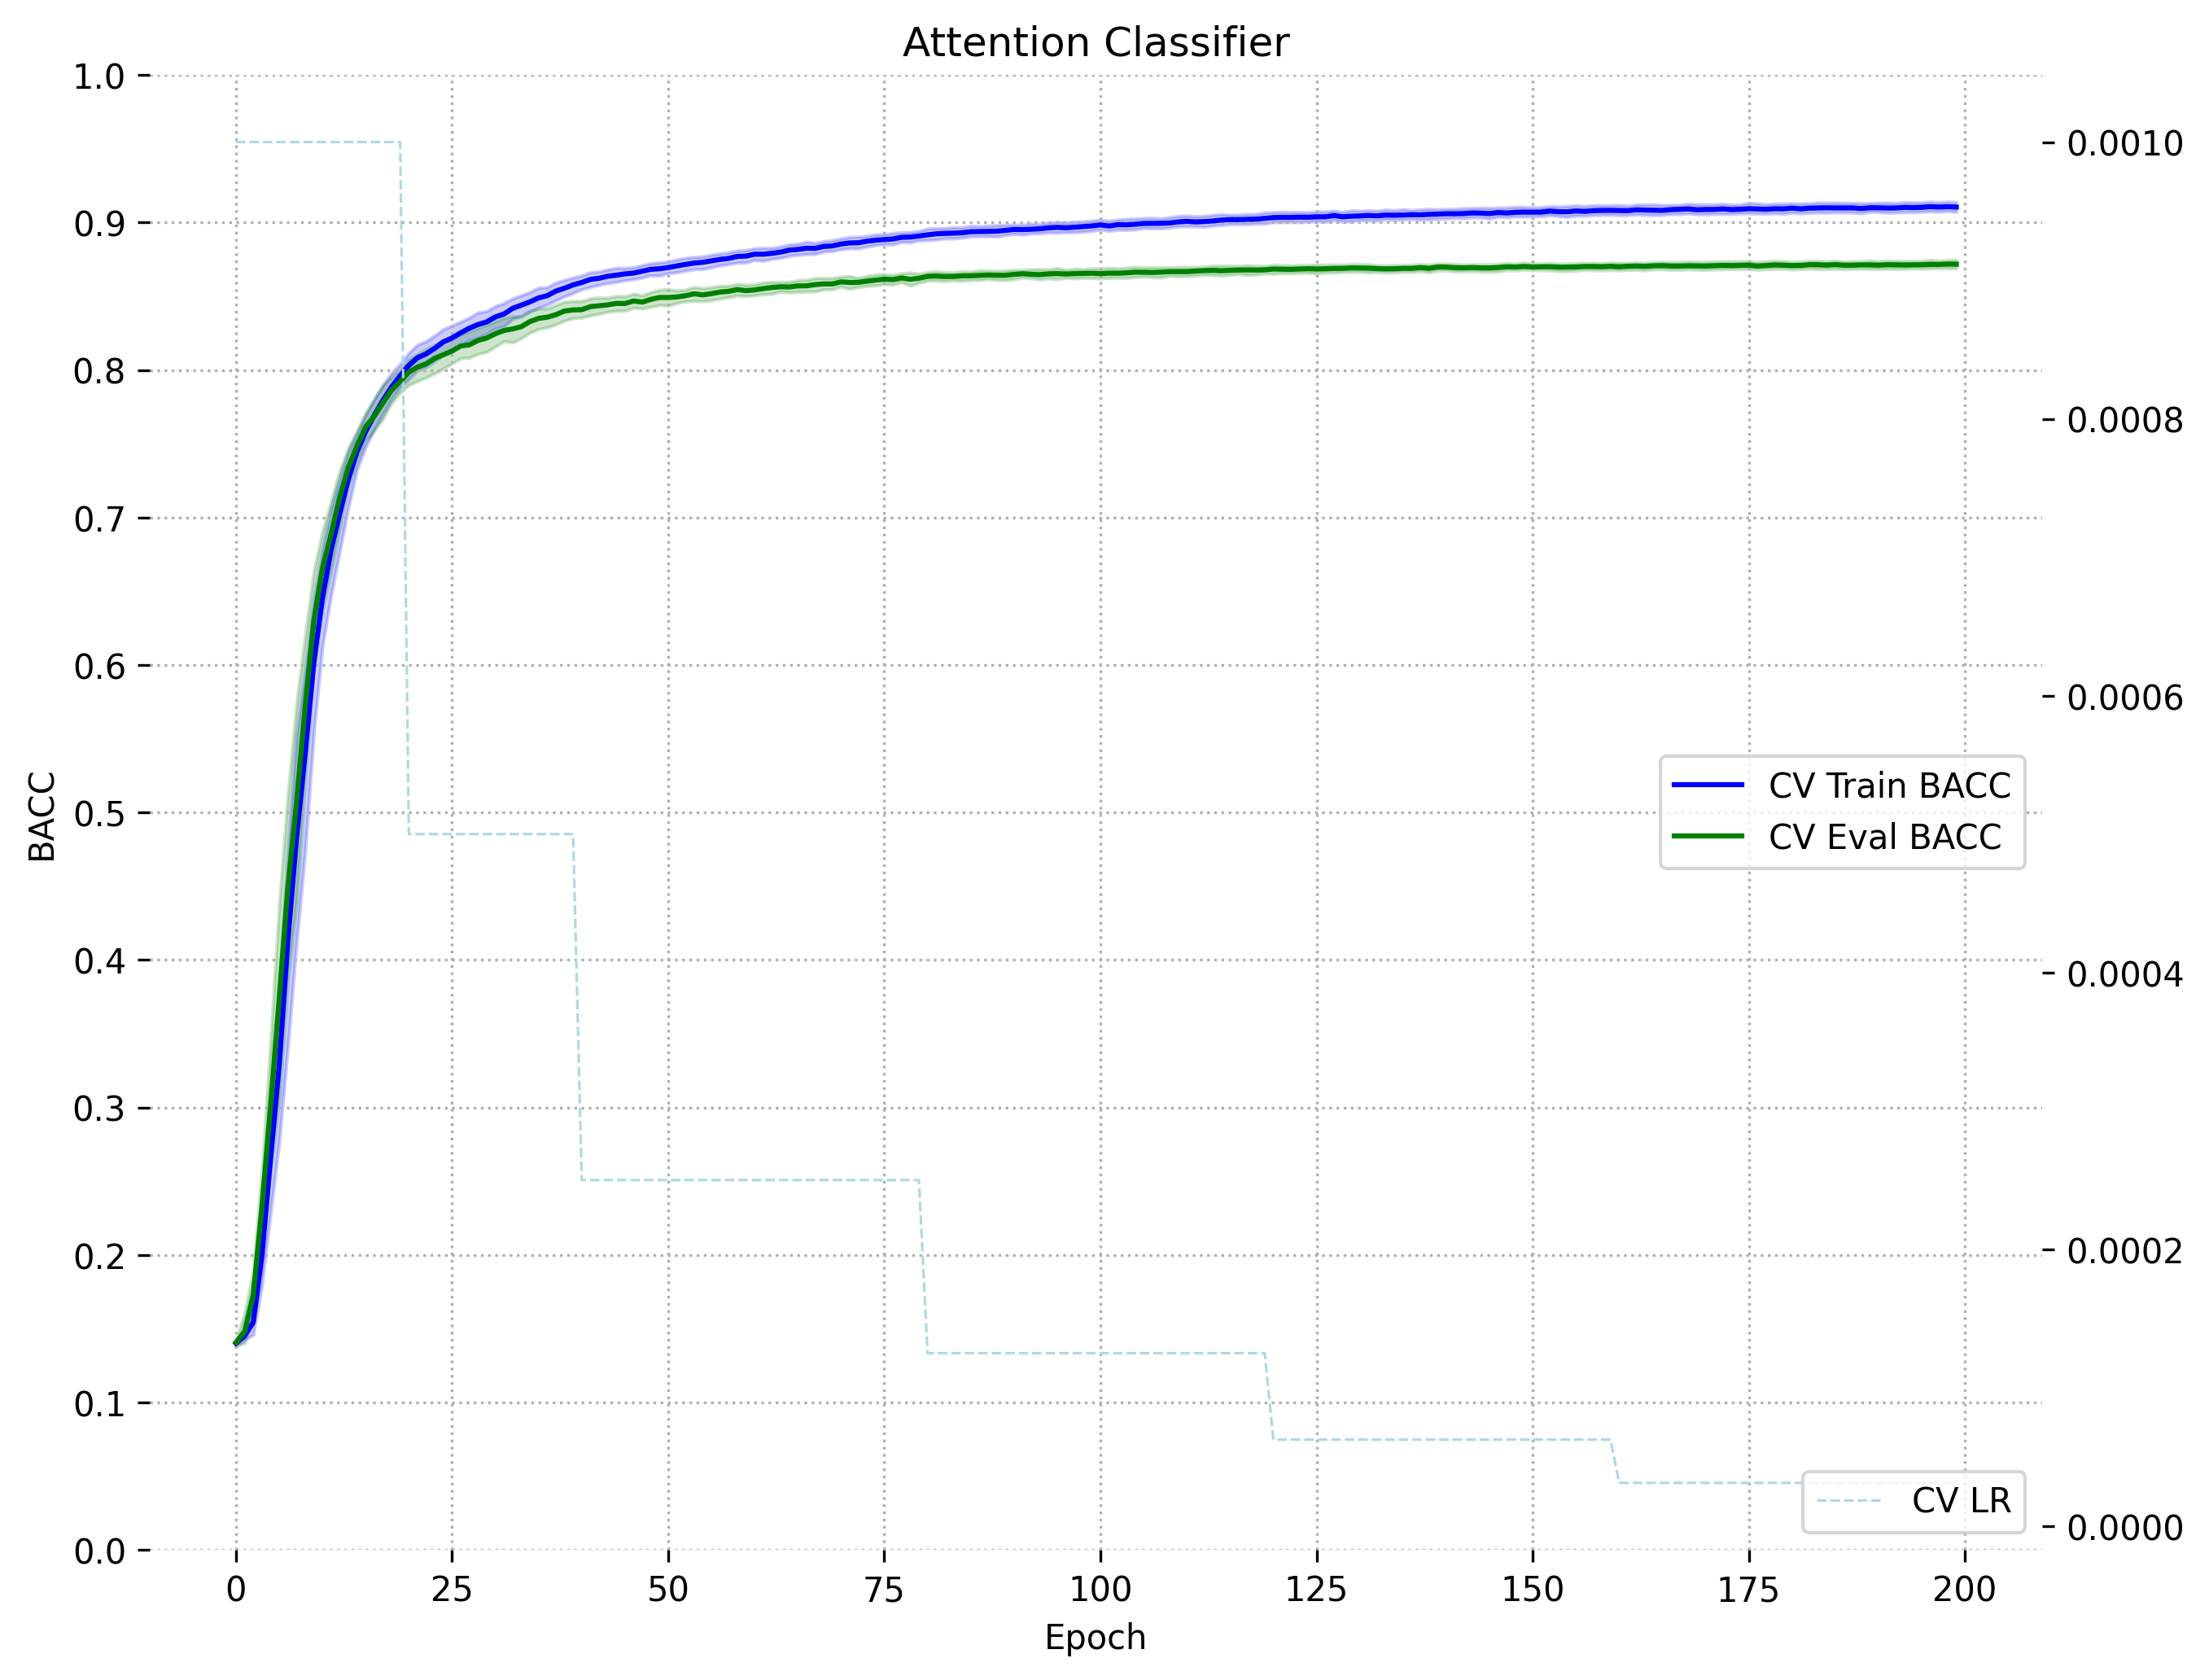

In [68]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

plot_baccs_over_epochs('Attention Classifier')